In [ ]:
from IPython.display import HTML
from IPython.display import Image

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Stacking House Prices - Walkthrough to Top 5%

### Arun Godwin Patel

***

In [ ]:
Image(filename='../input/stacking-exp/stacking.gif.png', width = 800)

You may be thinking... **"What does a strange looking, 6 armed brick-layer have to do with predicting house prices?"**

Stick with it, all will be revealed throughout this walkthrough. But for now...

***

## Introduction

This kernel is intended to be a guide for education on the famous... Stacking technique. I used this technique to achieve a top 5% entry in the **House Prices: Advanced Regression Techniques** competition. I'll be focusing mainly on data preparation, feature engineering and the building of a stacking model. This is an ongoing project that I will update regularly, so stay tuned.

If you have any comments, thoughts or notice anything that could be improved, please feel free to comment.

Enjoy!

First of all I like to do some research on the project at hand, in this case House Prices. So **what characteristics help to boost the value of a house?**

In [ ]:
Image(filename='../input/top10/top10.png')

From this research, there are several key things that stood out:
- **Location** - location is key for high valuations, therefore having a safe, well facilitated and well positioned house within a good neighbourhood, is also a large contributing factor.
- **Size** - The more space, rooms and land that the house contains, the higher the valuation.
- **Features** - the latest utilities and extras (such as a garage) ae highly desirable.

This insight will held guide my feature engineering.

***

## Content

1. **[Import packages](#import_packages)**
2. **[Load data](#load_data)**
3. **[Data preparation](#data_preparation)**
    - 3.1 - [Remove outliers](#remove_outliers)
    - 3.2 - [Treat missing values](#treat_missing_values)   
4. **[Exploratory Data Analysis](#exploratory_data_analysis)**
    - 4.1 - [Correlation matrix](#correlation_matrix)
    - 4.2 - [Feature engineering](#feature_engineering)
        - 4.2.1 - [Polynomials](#polynomials)
        - 4.2.2 - [Interior](#interior)
        - 4.2.3 - [Architectural & Structural](#architectural_&_structural)
        - 4.2.4 - [Exterior](#exterior)
        - 4.2.5 - [Location](#location)
        - 4.2.6 - [Land](#land)
        - 4.2.7 - [Access](#access)
        - 4.2.8 - [Utilities](#utilities)
        - 4.2.9 - [Miscellaneous](#miscellaneous)
    - 4.3 - [Target variable](#target_variable)
    - 4.4 - [Treating skewed features](#treating_skewed_features)
5. **[Modeling](#modeling)**
    - 5.1 - [Preparation of datasets](#preparation_of_datasets)
    - 5.2 - [Training](#training)
    - 5.3 - [Optimisation](#optimisation)
    - 5.4 - [Stacking](#stacking)
    - 5.5 - [Ensemble](#ensemble)
    - 5.6 - [Submission](#submission)
6. **[Conclusion](#conclusion)**   

***

<a id='import_packages'></a>
# 1. 
## Import packages

In [186]:
# This first set of packages include Pandas, for data manipulation, numpy for mathematical computation and matplotlib & seaborn, for visualisation.
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
print('Data Manipulation, Mathematical Computation and Visualisation packages imported!')

# Statistical packages used for transformations
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr
print('Statistical packages imported!')

# Metrics used for measuring the accuracy and performance of the models
#from sklearn import metrics
#from sklearn.metrics import mean_squared_error
print('Metrics packages imported!')

# Algorithms used for modeling
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
print('Algorithm packages imported!')

# Pipeline and scaling preprocessing will be used for models that are sensitive
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print('Pipeline and preprocessing packages imported!')

# Model selection packages used for sampling dataset and optimising parameters
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
print('Model selection packages imported!')

# Set visualisation colours
mycols = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycols, n_colors = 4)
print('My colours are ready! :)')

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warning will be ignored!')

Data Manipulation, Mathematical Computation and Visualisation packages imported!
Statistical packages imported!
Metrics packages imported!
Algorithm packages imported!
Pipeline and preprocessing packages imported!
Model selection packages imported!
My colours are ready! :)
Deprecation warning will be ignored!


***

<a id='load_data'></a>
# 2. 
## Load data

- The Pandas package helps us work with our datasets. We start by reading the training and test datasets into DataFrames.
- We want to save the 'Id' columns from both datasets for later use when preparing the submission data.
- But we can drop them from the training and test datasets as they are redundant.

In [187]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the  'Id' column as it's redundant for modeling
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print(train.shape)
print(test.shape)
train.head()

(1460, 80)
(1459, 79)


MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig    ...     PoolArea PoolQC Fence  \
0         Lvl    AllPub    Inside    ...            0    NaN   NaN   
1         Lvl    AllPub       FR2    ...            0    NaN   NaN   
2         Lvl    AllPub    Inside    ...            0    NaN   NaN   
3         Lvl    AllPub    Corner    ...            0    NaN   NaN   
4         Lvl    AllPub       FR2    ...            0    NaN   NaN   

  MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0         NaN       0      2    2008        WD         Normal     208500  
1         NaN       0      5    2007        WD         Normal     181500  
2         NaN       0      9    2008        WD         Normal     223500  
3         NaN       0      2    2006        WD        Abnorml     140000  
4         NaN       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

- This dataset was constructed by **Dean De Cock** for use in Data Science education. It is viewed as a modern alternative to the Boston Housing dataset.
- As expressed within the competition, this datasets includes 79 descriptive features about the houses.
- A data description is included within competition, I highly recommend referring to this file frequently during data preparation and feature engineering.
- This file also gives guidance to how missing values should be treated, which I will address in section 3.3.

***

<a id='data_preparation'></a>
# 3. 
## Data preparation

<a id='remove_outliers'></a>
### 3.1 - Remove outliers

<img style="float: center;" src="Outliers-Matter.jpg" width="80%">

***Outliers can be a Data Scientists nightmare.*** 

- By definition, an outlier is something that is outside of the expected response. How far you're willing to consider something to be an outlier, is down to the individual and the problem.
- From this definition, this outlier will therefore sit way outside of the distribution of data points. Hence, this will skew the distribution of the data and potential calculations.
- Let's see how this will affect predictions of the future.

<img style="float: center;" src="outliers.png" width="100%">

The **data points** are shown in **light blue** on the left hand side of the grey dashed line. The **orange points** represent the **true future values**, and the **solid dark blue line** shows the **prediction** from the data points. 

- When the outliers are left in the model, the **model overfits** and is sensitive to these points. Therefore, it predicts values much higher than the true future values. *This is what we want to avoid.*
- However, when outliers are removed, it **predicts much more accurately** with a generalised model that splits the distribution of the data points evenly.
- ***This is very important in Machine Learning because our goal is to create robust models that are able to generalise to future situations.*** If we create a model that is very sensitive and tuned to fit outliers, this will result in a model that over or underfits. If we can create models that are able to cancel out the distractions and noise of outliers, this is usually a better situation.

By referring to the **Ames Housing Dataset** link provided in the **Acknowledgements**, you'll see that the author outlines there are some outliers that must be treated: 

*" Although all known errors were corrected in the data, no observations have been removed due to unusual values and all final residential sales from the initial data set are included in the data presented with this article. There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students. "*

- First, let's plot the two features stated against one another, to identify the outliers. Then we will remove them. The chart on the left shows the data before removing the outliers, and the chart on the right shows after.

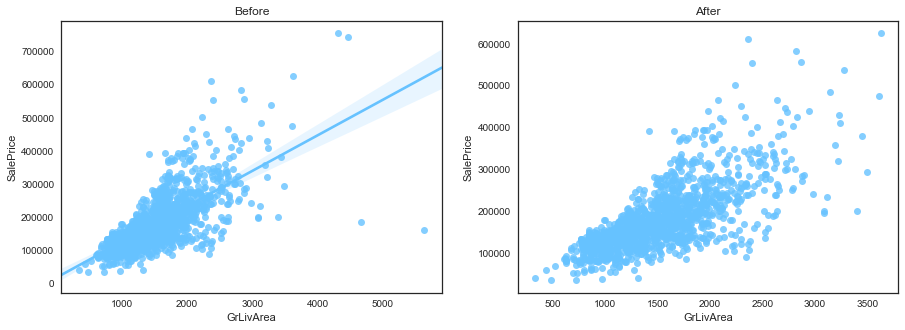

In [188]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
#fit_reg是指回归线
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=True).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)    
#直接用train = train.drop(train['GrLivArea']>4000)就可以啦
train = train.drop(train[(train['GrLivArea']>4000)].index)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("After")

***

<a id='treat_missing_values'></a>
### 3.2 - Treat missing values

***Missing values are the Data Scientists other nightmare.***

A missing value is an entry in a column that has no assigned value. This can mean multiple things:
- A missing value may be the **result of an error during the production of the dataset**. This could be a human error, or machinery error depending on where the data comes from. 
- A missing value in some cases, may just mean a that a **'zero'** should be present. In which case, it can be replaced by a 0. The data description provided helps to address situations like these.
- However, missing values represent no information. Therefore, **does the fact that you don't know what value to assign an entry, mean that filling it with a 'zero' is always a good fit?** 

Some algorithms do not like missing values. Some are capable of handling them, but others are not. Therefore since we are using a variety of algorithms, it's best to treat them in an appropriate way.

**If you have missing values, you have two options**:
- Delete the entire row
- Fill the missing entry with an imputed value

In order to treat this dataset, first of all I will create a dataset of the training and test data in order to make changes consistent across both. Then, I will cycle through each feature with missing values and treat them individually based on the data description, or my judgement.

In [189]:
# First of all, save the length of the training and test data for use later
ntrain = train.shape[0]
ntest = test.shape[0]

# Also save the target value, as we will remove this
y_train = train.SalePrice.values

# concatenate training and test data into all_data
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data shape: {}".format(all_data.shape))

all_data shape: (2915, 79)


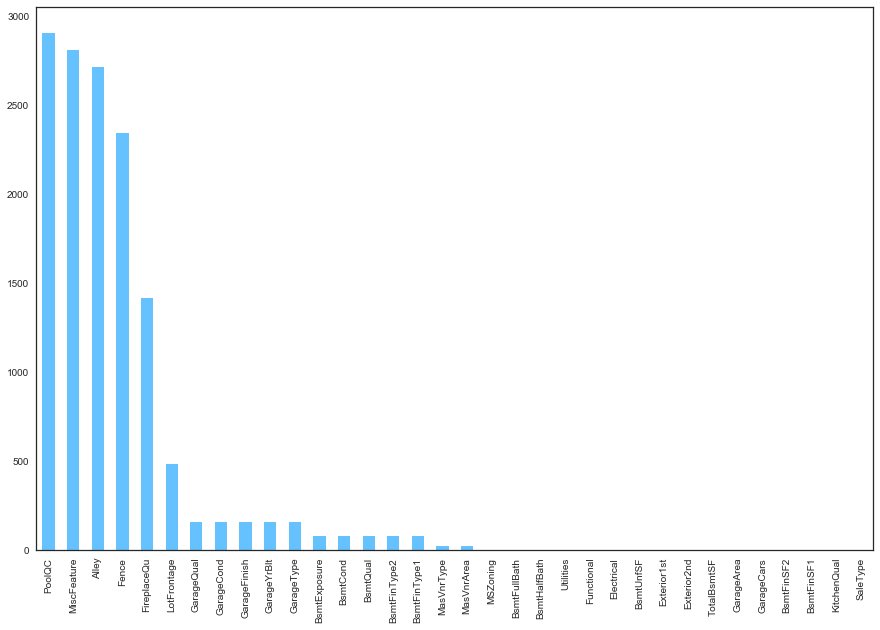

In [190]:
# aggregate all null values 
all_data_na = all_data.isnull().sum()
#统计是否有缺失，若没有缺失，则sum为0，抛弃
# get rid of all the values with 0 missing values
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.subplots(figsize =(15, 10))
all_data_na.plot(kind='bar');

Above you can see where the missing values sit. **Note** it may look like some of the features have 0 missing values, but actually they have 1 by closer inspection.

- Through reference of the data description, this gives guidance on how to treat missing values for some columns. For ones where guidance isn't provided, I have used intuition which I will explain. Below, you will see how I treated each feature.

In [191]:
# Using data description, fill these missing values with "None"
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
           "GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
            "BsmtFinType2", "MSSubClass", "MasVnrType"):
    all_data[col] = all_data[col].fillna("None")
print("'None' - treated...")

# The area of the lot out front is likely to be similar to the houses in the local neighbourhood
# Therefore, let's use the median value of the houses in the neighbourhood to fill this feature
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
print("'LotFrontage' - treated...")

# Using data description, fill these missing values with 0 
for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)
print("'0' - treated...")


# Fill these features with their mode, the most commonly occuring value. This is okay since there are a low number of missing values for these features
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])
print("'mode' - treated...")

all_data_na = all_data.isnull().sum()
print("Features with missing values: ", all_data_na.drop(all_data_na[all_data_na == 0].index))

'None' - treated...
'LotFrontage' - treated...
'0' - treated...
'mode' - treated...
Features with missing values:  Utilities    2
dtype: int64


Here we see that we have 1 remaining feature with missing values, Utilities.

- Let's inspect this closer to see how to treat it.

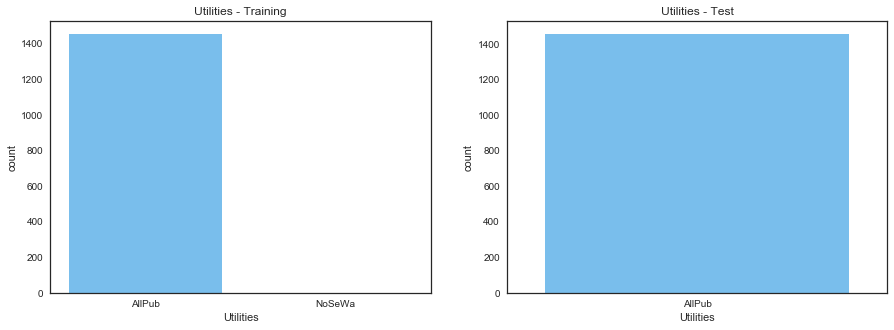

In [192]:
plt.subplots(figsize =(15, 5))

plt.subplot(1, 2, 1)
g = sns.countplot(x = "Utilities", data = train).set_title("Utilities - Training")

plt.subplot(1, 2, 2)
g = sns.countplot(x = "Utilities", data = test).set_title("Utilities - Test")

This tell us that within the training dataset, Utilities has two unique values: "AllPub" and "NoSeWa". With "AllPub" being by far the most common.
- However, the test dataset has only 1 value for this column, which means that it holds no predictive power because it is a constant for all test observations.

Therefore, we can drop this column

In [193]:
# From inspection, we can remove Utilities
all_data = all_data.drop(['Utilities'], axis=1)

all_data_na = all_data.isnull().sum()
print("Features with missing values: ", len(all_data_na.drop(all_data_na[all_data_na == 0].index)))

Features with missing values:  0


***

<a id='exploratory_data_analysis'></a>
# 4. 
## Exploratory Data Analysis

<a id='correlation_matrix'></a>
### 4.1 - Correlation matrix

Now that missing values and outliers have been treated, I will analyse each feature in more detail. This will give guidance on how to prepare this feature for modeling. I will analyse the features based on the different aspects of the house available in the dataset.



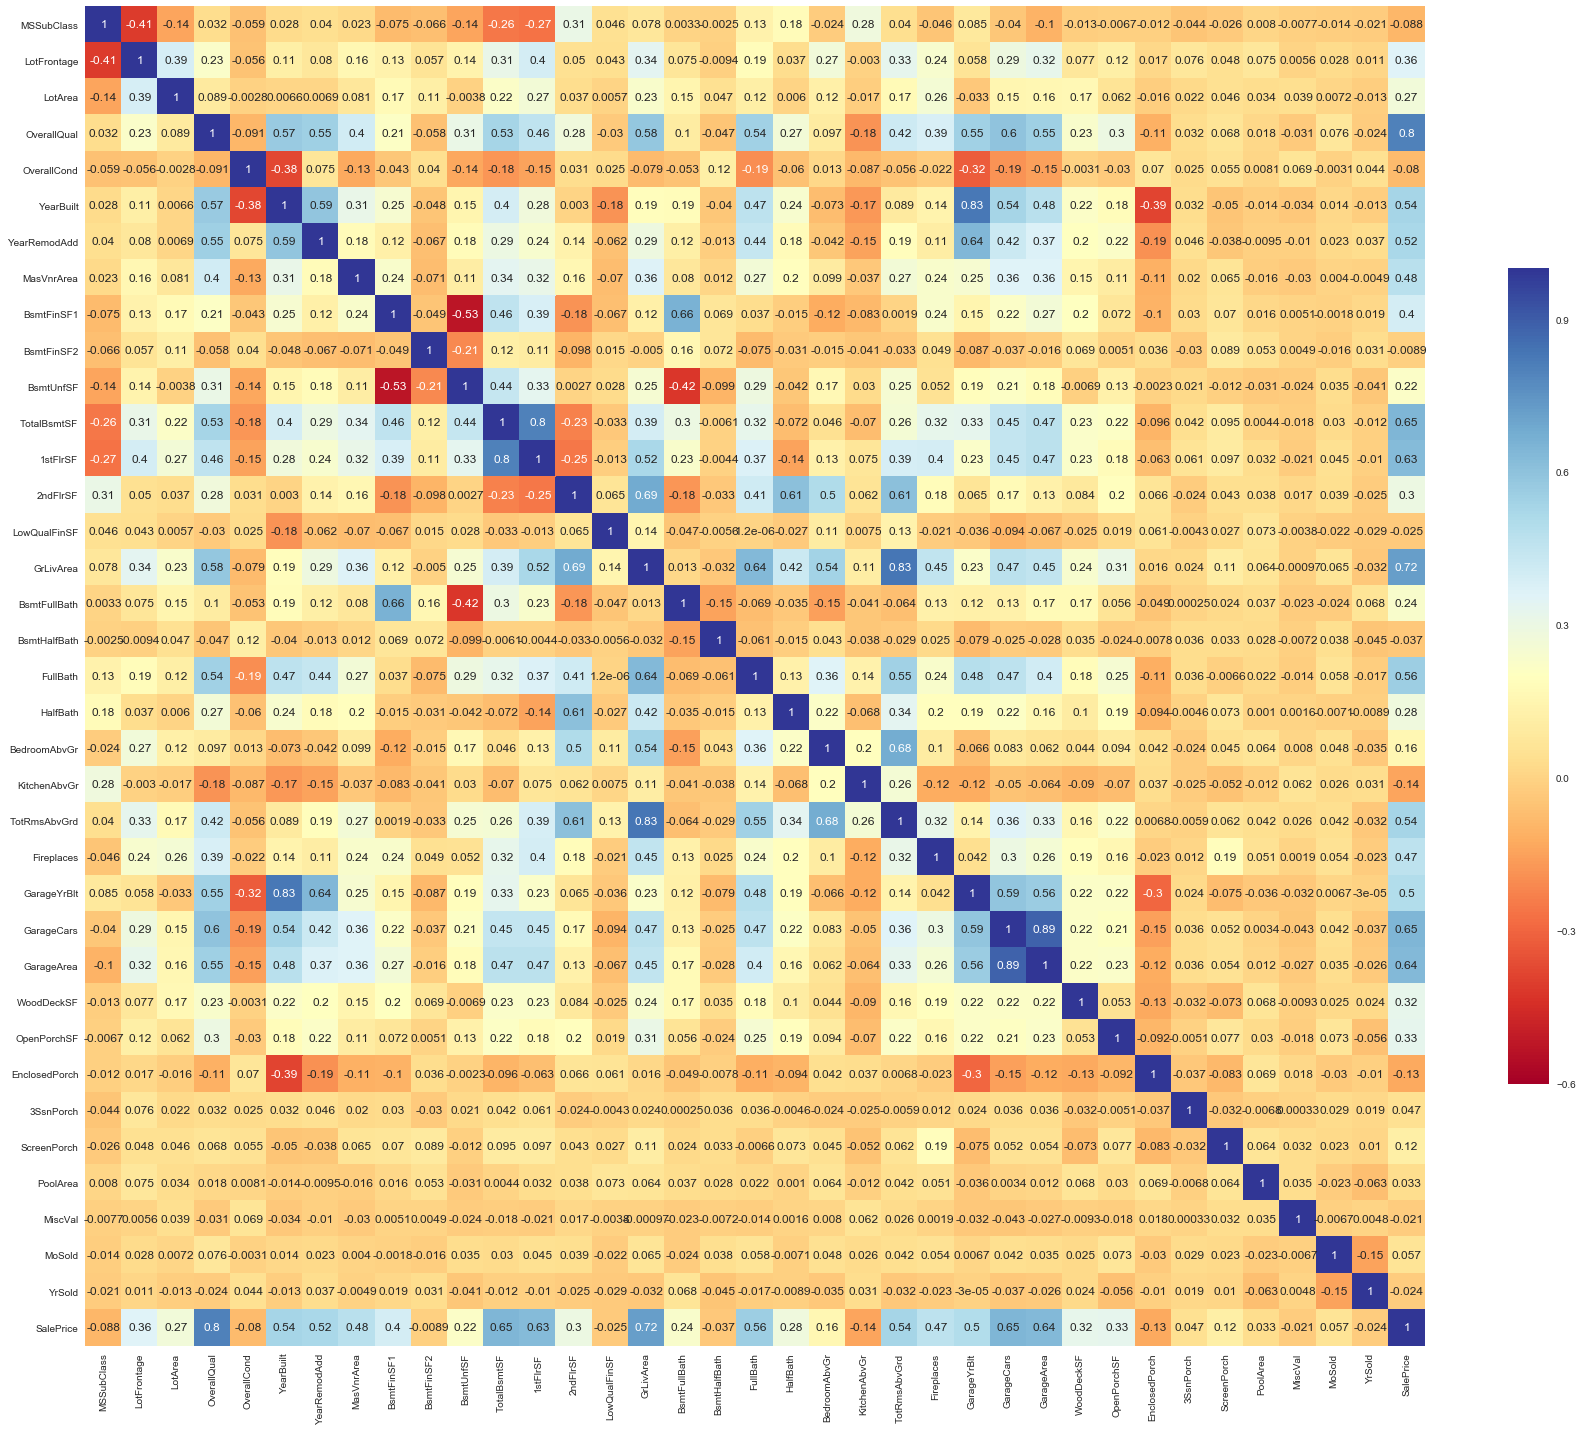

In [194]:
corr = train.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True);

- Using this correlation matrix, I am able to visualise the raw highly influencing factors on SalePrice.
- I am looking for these because I will create polynomial features from the highly correlating features, in an attempt to capture the complex non-linear relationships within the data.

***

<a id='feature_engineering'></a>
### 4.2 - Feature engineering

This section is quite lengthy, so I have added hyperlinks to each subsection below in case you want to skip through...

- 4.2.1 - [Polynomials](#polynomials)
- 4.2.2 - [Interior](#interior)
- 4.2.3 - [Architectural & Structural](#architectural_&_structural)
- 4.2.4 - [Exterior](#exterior)
- 4.2.5 - [Location](#location)
- 4.2.6 - [Land](#land)
- 4.2.7 - [Access](#access)
- 4.2.8 - [Utilities](#utilities)
- 4.2.9 - [Miscellaneous](#miscellaneous)

<a id='polynomials'></a>
#### 4.2.1 - Polynomials

The most common relationship we may think of between two variables, would be a straight line or a linear relationship. What this means is that if we increase the predictor by 1 unit, the response always increases by X units. However, not all data has a linear relationship and therefore it may be necessary for your model to fit the more complex relationships in the data. 

But how do you fit a model to data with complex relationships, unexplainable by a linear function? There are a variety of curve-fitting methods you can choose from to help you with this.

- The most common way to fit curves to the data is to include polynomial terms, such as squared or cubed predictors.
- Typically, you choose the model order by the number of bends you need in your line. Each increase in the exponent produces one more bend in the curved fitted line. It’s very rare to use more than a cubic term.

- If your response data follows a pattern that descends down to a lower bound, or ascends up to an upper bound, you can fit this type of relationship by including the reciprocal (1/x) of one or more predictor variables in the model.
    - Generally, you want to use this form when the size of effect for a predictor variable decreases as its value increases. 
- Because the gradient is a function of 1/x, the gradient gets flatter as x increases. For this type of model, x can never equal 0 because you can’t divide by zero.

*So... now that you're armed with this information, what's important to know is that in order to model non-linear, complex relationships between response and predictor variables, we can create combinations of these variables with increasing order, or reciprocal orders.*

- Since we have such a high number of variables in the dataset, it's overkill to create polynomials of each feature. Therefore, I will look at the top 10 correlating features with the target variable from the training dataset and create polynomials of these features, or equivalently the new combinations I have created from them.

Using the correlation matrix, the top influencing factors that I will use to create polynomials are:
1. **OverallQual**
2. **GrLivArea**
3. **GarageCars**
4. **GarageArea**
5. **TotalBsmtSF**
6. **1stFlrSF**
7. **FullBath**
8. **TotRmsAbvGrd**
9. **Fireplaces**
10. **MasVnrArea**
11. **BsmtFinSF1**
12. **LotFrontage**
13. **WoodDeckSF**
14. **OpenPorchSF**
15. **2ndFlrSF**

In [195]:
# Quadratic
all_data["OverallQual-2"] = all_data["OverallQual"] ** 2
all_data["GrLivArea-2"] = all_data["GrLivArea"] ** 2
all_data["GarageCars-2"] = all_data["GarageCars"] ** 2
all_data["GarageArea-2"] = all_data["GarageArea"] ** 2
all_data["TotalBsmtSF-2"] = all_data["TotalBsmtSF"] ** 2
all_data["1stFlrSF-2"] = all_data["1stFlrSF"] ** 2
all_data["FullBath-2"] = all_data["FullBath"] ** 2
all_data["TotRmsAbvGrd-2"] = all_data["TotRmsAbvGrd"] ** 2
all_data["Fireplaces-2"] = all_data["Fireplaces"] ** 2
all_data["MasVnrArea-2"] = all_data["MasVnrArea"] ** 2
all_data["BsmtFinSF1-2"] = all_data["BsmtFinSF1"] ** 2
all_data["LotFrontage-2"] = all_data["LotFrontage"] ** 2
all_data["WoodDeckSF-2"] = all_data["WoodDeckSF"] ** 2
all_data["OpenPorchSF-2"] = all_data["OpenPorchSF"] ** 2
all_data["2ndFlrSF-2"] = all_data["2ndFlrSF"] ** 2
print("Quadratics done!...")

# Cubic
all_data["OverallQual-3"] = all_data["OverallQual"] ** 3
all_data["GrLivArea-3"] = all_data["GrLivArea"] ** 3
all_data["GarageCars-3"] = all_data["GarageCars"] ** 3
all_data["GarageArea-3"] = all_data["GarageArea"] ** 3
all_data["TotalBsmtSF-3"] = all_data["TotalBsmtSF"] ** 3
all_data["1stFlrSF-3"] = all_data["1stFlrSF"] ** 3
all_data["FullBath-3"] = all_data["FullBath"] ** 3
all_data["TotRmsAbvGrd-3"] = all_data["TotRmsAbvGrd"] ** 3
all_data["Fireplaces-3"] = all_data["Fireplaces"] ** 3
all_data["MasVnrArea-3"] = all_data["MasVnrArea"] ** 3
all_data["BsmtFinSF1-3"] = all_data["BsmtFinSF1"] ** 3
all_data["LotFrontage-3"] = all_data["LotFrontage"] ** 3
all_data["WoodDeckSF-3"] = all_data["WoodDeckSF"] ** 3
all_data["OpenPorchSF-3"] = all_data["OpenPorchSF"] ** 3
all_data["2ndFlrSF-3"] = all_data["2ndFlrSF"] ** 3
print("Cubics done!...")

# Square Root
all_data["OverallQual-Sq"] = np.sqrt(all_data["OverallQual"])
all_data["GrLivArea-Sq"] = np.sqrt(all_data["GrLivArea"])
all_data["GarageCars-Sq"] = np.sqrt(all_data["GarageCars"])
all_data["GarageArea-Sq"] = np.sqrt(all_data["GarageArea"])
all_data["TotalBsmtSF-Sq"] = np.sqrt(all_data["TotalBsmtSF"])
all_data["1stFlrSF-Sq"] = np.sqrt(all_data["1stFlrSF"])
all_data["FullBath-Sq"] = np.sqrt(all_data["FullBath"])
all_data["TotRmsAbvGrd-Sq"] = np.sqrt(all_data["TotRmsAbvGrd"])
all_data["Fireplaces-Sq"] = np.sqrt(all_data["Fireplaces"])
all_data["MasVnrArea-Sq"] = np.sqrt(all_data["MasVnrArea"])
all_data["BsmtFinSF1-Sq"] = np.sqrt(all_data["BsmtFinSF1"])
all_data["LotFrontage-Sq"] = np.sqrt(all_data["LotFrontage"])
all_data["WoodDeckSF-Sq"] = np.sqrt(all_data["WoodDeckSF"])
all_data["OpenPorchSF-Sq"] = np.sqrt(all_data["OpenPorchSF"])
all_data["2ndFlrSF-Sq"] = np.sqrt(all_data["2ndFlrSF"])
print("Roots done!...")

Quadratics done!...
Cubics done!...
Roots done!...


<a id='interior'></a>
#### 4.2.2 - Interior

***BsmtQual***

- Evaluates the height of the basement.

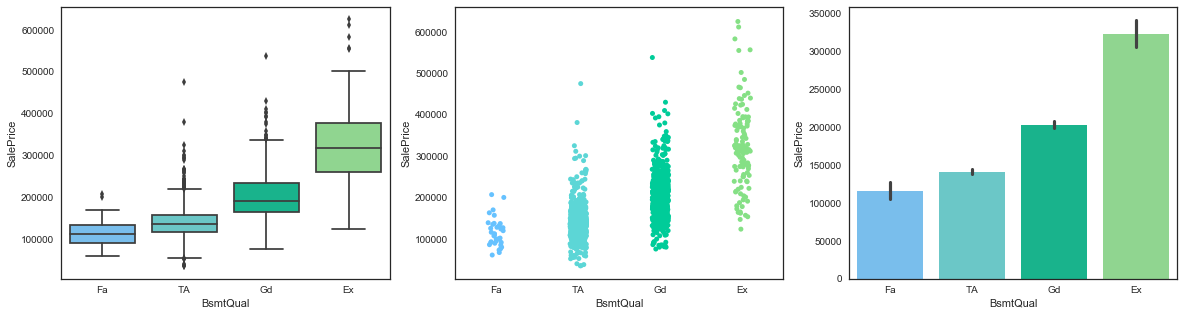

In [196]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtQual", y="SalePrice", data=train, order=['Fa', 'TA', 'Gd', 'Ex']);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtQual", y="SalePrice", data=train, size = 5, jitter = True, order=['Fa', 'TA', 'Gd', 'Ex']);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtQual", y="SalePrice", data=train, order=['Fa', 'TA', 'Gd', 'Ex']);

- SalePrice is clearly affected by BsmtQual, with the better the quality being meaning the higher the price. 
- However, it looks as though most houses have either 'Good' or 'Typical' sized basements.
- Since this feature is ordinal, i.e. the categories represent different levels of order, I will replace the values by hand.

In [197]:
all_data['BsmtQual'] = all_data['BsmtQual'].map({"None":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['BsmtQual'] = all_data['BsmtQual'].astype(int)
all_data['BsmtQual'].unique()

array([3, 2, 4, 0, 1], dtype=int64)

***BsmtCond***
- Evaluates the general condition of the basement.

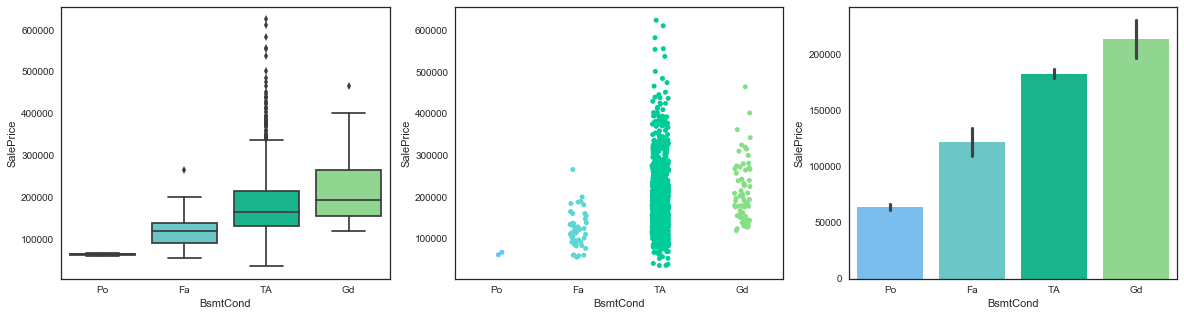

In [198]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtCond", y="SalePrice", data=train, order=['Po', 'Fa', 'TA', 'Gd']);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtCond", y="SalePrice", data=train, size = 5, jitter = True, order=['Po', 'Fa', 'TA', 'Gd']);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtCond", y="SalePrice", data=train, order=['Po', 'Fa', 'TA', 'Gd']);

- As the condition of the basement improves, the SalePrice also increases.
- However, we see some very high SalePrice values for the houses with "Typical" basement conditions. This perhaps suggests that although these two features correlate positively, BsmtCond may not have a largely influential contribution on SalePrice.
- We also see the largest number of houses falling into the "TA" category.
- Since this feature is ordinal, I will replace the values by hand.

In [199]:
all_data['BsmtCond'] = all_data['BsmtCond'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['BsmtCond'] = all_data['BsmtCond'].astype(int)
all_data['BsmtCond'].unique()

array([3, 4, 0, 2, 1], dtype=int64)

***BsmtExposure***
- Refers to walkout or garden level walls

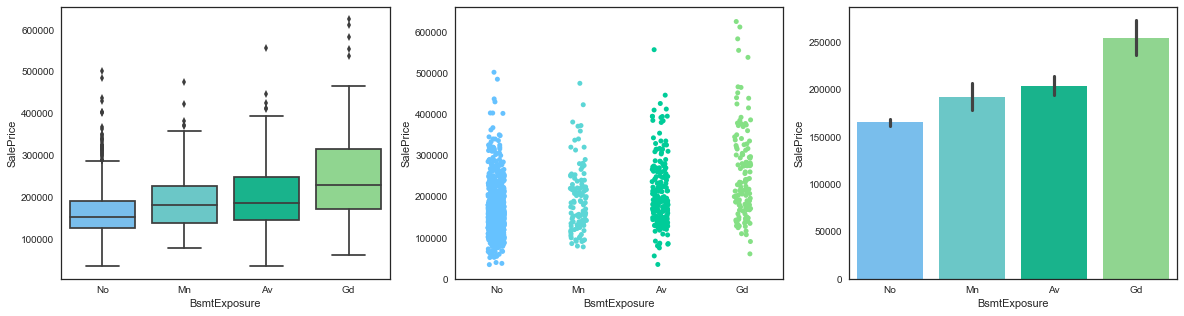

In [200]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtExposure", y="SalePrice", data=train, order=['No', 'Mn', 'Av', 'Gd']);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtExposure", y="SalePrice", data=train, size = 5, jitter = True, order=['No', 'Mn', 'Av', 'Gd']);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtExposure", y="SalePrice", data=train, order=['No', 'Mn', 'Av', 'Gd']);

- As the amount of exposure increases, so does hte typical SalePrice. Interestingly, the average difference of SalePrice between categories is quite low here, telling me that some houses sold for very high prices, even with no exposure.
- From this analysis I would say that it is positively correlating with SalePrice, but it isn't massively influential.
- Since this feature is ordinal, I will replace values by hand.

In [201]:
all_data['BsmtExposure'] = all_data['BsmtExposure'].map({"None":0, "No":1, "Mn":2, "Av":3, "Gd":4})
all_data['BsmtExposure'] = all_data['BsmtExposure'].astype(int)
all_data['BsmtExposure'].unique()

array([1, 4, 2, 3, 0], dtype=int64)

***BsmtFinType1***
- Rating of basement finished area

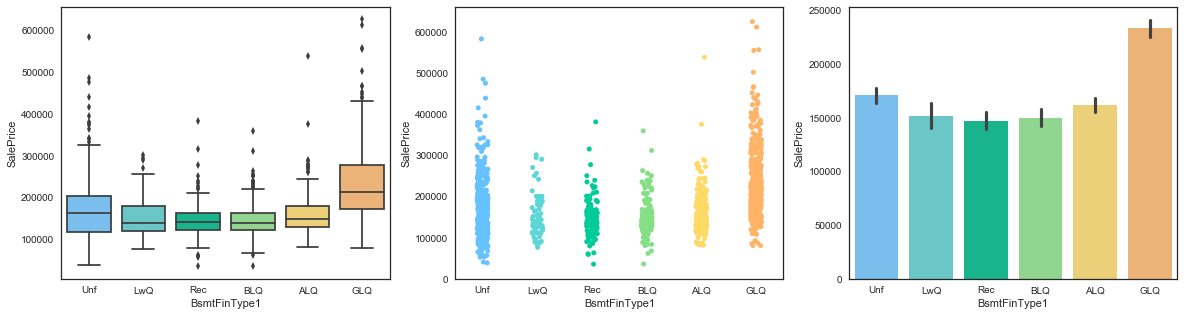

In [202]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtFinType1", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtFinType1", y="SalePrice", data=train, size = 5, jitter = True, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtFinType1", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

- This is very interesting, it seems as though houses with an unfinished basement on average sold for more money than houses having up to an average rating...
- However, houses with a good finish within the basement still demand more money than unfinished ones.
- This is an ordinal feature, however as you can see this order does not necessarily cause a higher SalePrice. By creating an ordinal variable it was suggest that as the order of the feature increases then the target variable would also. We can see that this is not the case. Therefore, I will create dummy variables from this feature.

In [203]:
all_data = pd.get_dummies(all_data, columns = ["BsmtFinType1"], prefix="BsmtFinType1")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFinSF1  BsmtFinSF2        ...        WoodDeckSF-Sq  \
0             1       706.0         0.0        ...             0.000000   
1             4       978.0         0.0        ...            17.262677   
2             2       486.0         0.0        ...             0.000000   

   OpenPorchSF-Sq  2ndFlrSF-Sq  BsmtFinType1_ALQ  BsmtFinType1_BLQ  \
0        7.810250    29.223278                 0                 0   
1        0.000000     0.000000                 1                 0   
2        6.480741    29.427878                 0                 0   

  BsmtFinType1_GLQ BsmtFinType1_LwQ BsmtFinType1_None BsmtFinType1_Rec  \
0                1                0                 0                0   
1                0                0                 0                0   
2                1                0                 0                0   

   BsmtFinType1_Unf  
0                 0  
1                 0  
2                 0  

[3 rows x 129 columns]

***BsmtFinSF1***
- Type 1 finished square feet.

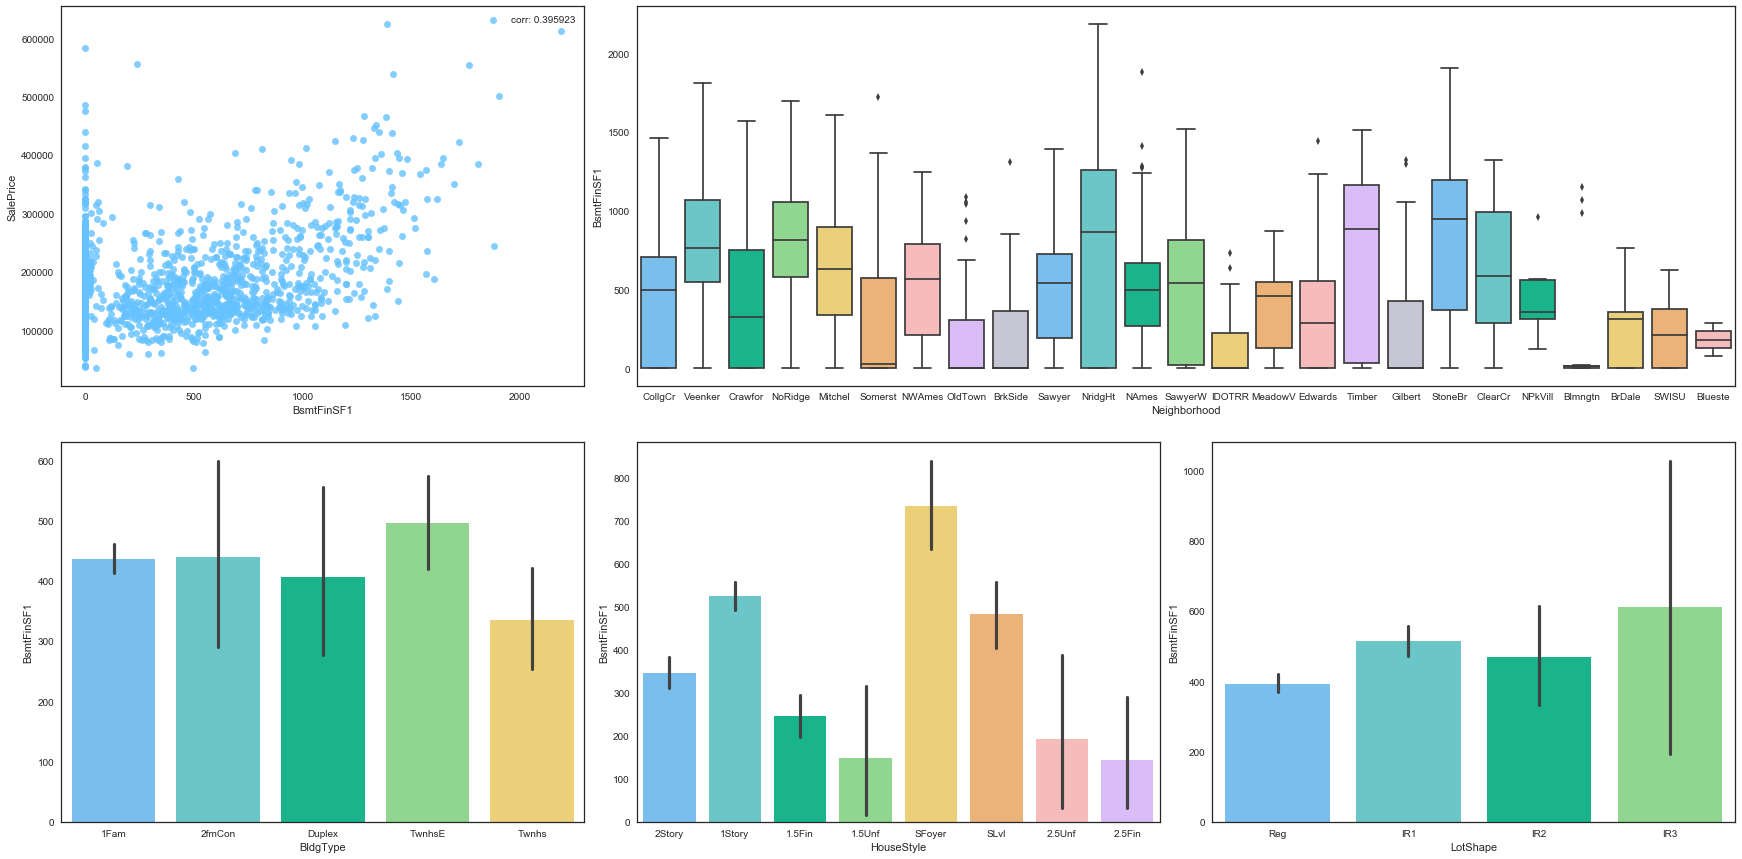

In [204]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['BsmtFinSF1'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['BsmtFinSF1'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="BsmtFinSF1", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="BsmtFinSF1", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="BsmtFinSF1", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="BsmtFinSF1", data=train, palette = mycols);

- This feature has a positive correlation with SalePrice and the spread of data points is quite large. 
- It is also clear that the local area (Neighborhood) and style of building (BldgType, HouseStyle and LotShape) has a varying effect on this feature.
- Since this is a continuous numeric feature, I will bin this into several categories and create dummy features.

In [205]:
all_data['BsmtFinSF1_Band'] = pd.cut(all_data['BsmtFinSF1'], 4)
all_data['BsmtFinSF1_Band'].unique()

[(-4.01, 1002.5], (1002.5, 2005.0], (2005.0, 3007.5], (3007.5, 4010.0]]
Categories (4, interval[float64]): [(-4.01, 1002.5] < (1002.5, 2005.0] < (2005.0, 3007.5] < (3007.5, 4010.0]]

In [206]:
all_data.loc[all_data['BsmtFinSF1']<=1002.5, 'BsmtFinSF1'] = 1
all_data.loc[(all_data['BsmtFinSF1']>1002.5) & (all_data['BsmtFinSF1']<=2005), 'BsmtFinSF1'] = 2
all_data.loc[(all_data['BsmtFinSF1']>2005) & (all_data['BsmtFinSF1']<=3007.5), 'BsmtFinSF1'] = 3
all_data.loc[all_data['BsmtFinSF1']>3007.5, 'BsmtFinSF1'] = 4
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].astype(int)

all_data.drop('BsmtFinSF1_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["BsmtFinSF1"], prefix="BsmtFinSF1")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFinSF2 BsmtFinType2     ...       BsmtFinType1_BLQ  \
0             1         0.0          Unf     ...                      0   
1             4         0.0          Unf     ...                      0   
2             2         0.0          Unf     ...                      0   

   BsmtFinType1_GLQ  BsmtFinType1_LwQ  BsmtFinType1_None BsmtFinType1_Rec  \
0                 1                 0                  0                0   
1                 0                 0                  0                0   
2                 1                 0                  0                0   

  BsmtFinType1_Unf BsmtFinSF1_1 BsmtFinSF1_2  BsmtFinSF1_3 BsmtFinSF1_4  
0                0            1            0             0            0  
1                0            1            0             0            0  
2                0            1            0             0            0  

[3 rows x 132 columns]

***BsmtFinType2***
- Rating of basement finished area (if multiple types)

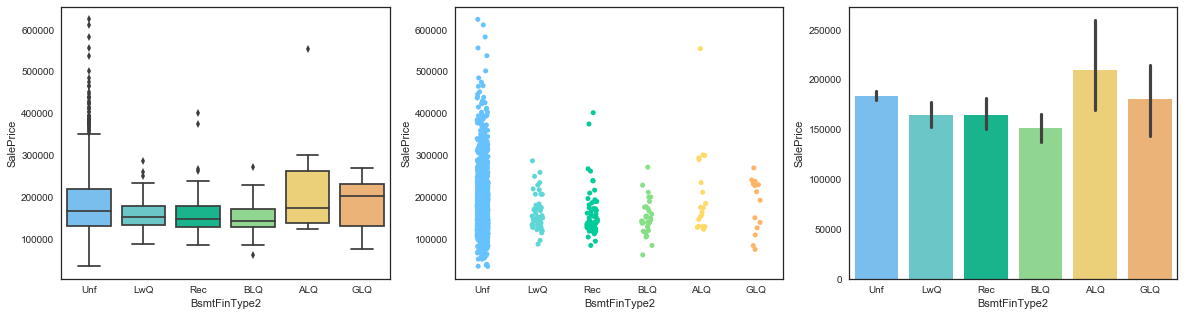

In [207]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BsmtFinType2", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="BsmtFinType2", y="SalePrice", data=train, size = 5, jitter = True, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="BsmtFinType2", y="SalePrice", data=train, order=["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], palette = mycols);

- There seems as though there are a lot of houses with unfinished second basements, and this may cause the skew in terms og SalePrice's being relatively high for these...
- There also looks to be only a few values for each of the other categories, with the highest average SalePrice coming from the second best category.
- Although this is intended to be an ordinal feature, we can see that the SalePrice does not necessarily increase with order. Hence, I will cerate dummy variables here.

In [208]:
all_data = pd.get_dummies(all_data, columns = ["BsmtFinType2"], prefix="BsmtFinType2")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFinSF2  BsmtFullBath       ...         BsmtFinSF1_2  \
0             1         0.0           1.0       ...                    0   
1             4         0.0           0.0       ...                    0   
2             2         0.0           1.0       ...                    0   

   BsmtFinSF1_3  BsmtFinSF1_4 BsmtFinType2_ALQ BsmtFinType2_BLQ  \
0             0             0                0                0   
1             0             0                0                0   
2             0             0                0                0   

  BsmtFinType2_GLQ BsmtFinType2_LwQ  BsmtFinType2_None BsmtFinType2_Rec  \
0                0                0                  0                0   
1                0                0                  0                0   
2                0                0                  0                0   

  BsmtFinType2_Unf  
0                1  
1                1  
2                1  

[3 rows x 138 columns]

***BsmtFinSF2***
- Type 2 finished square feet.

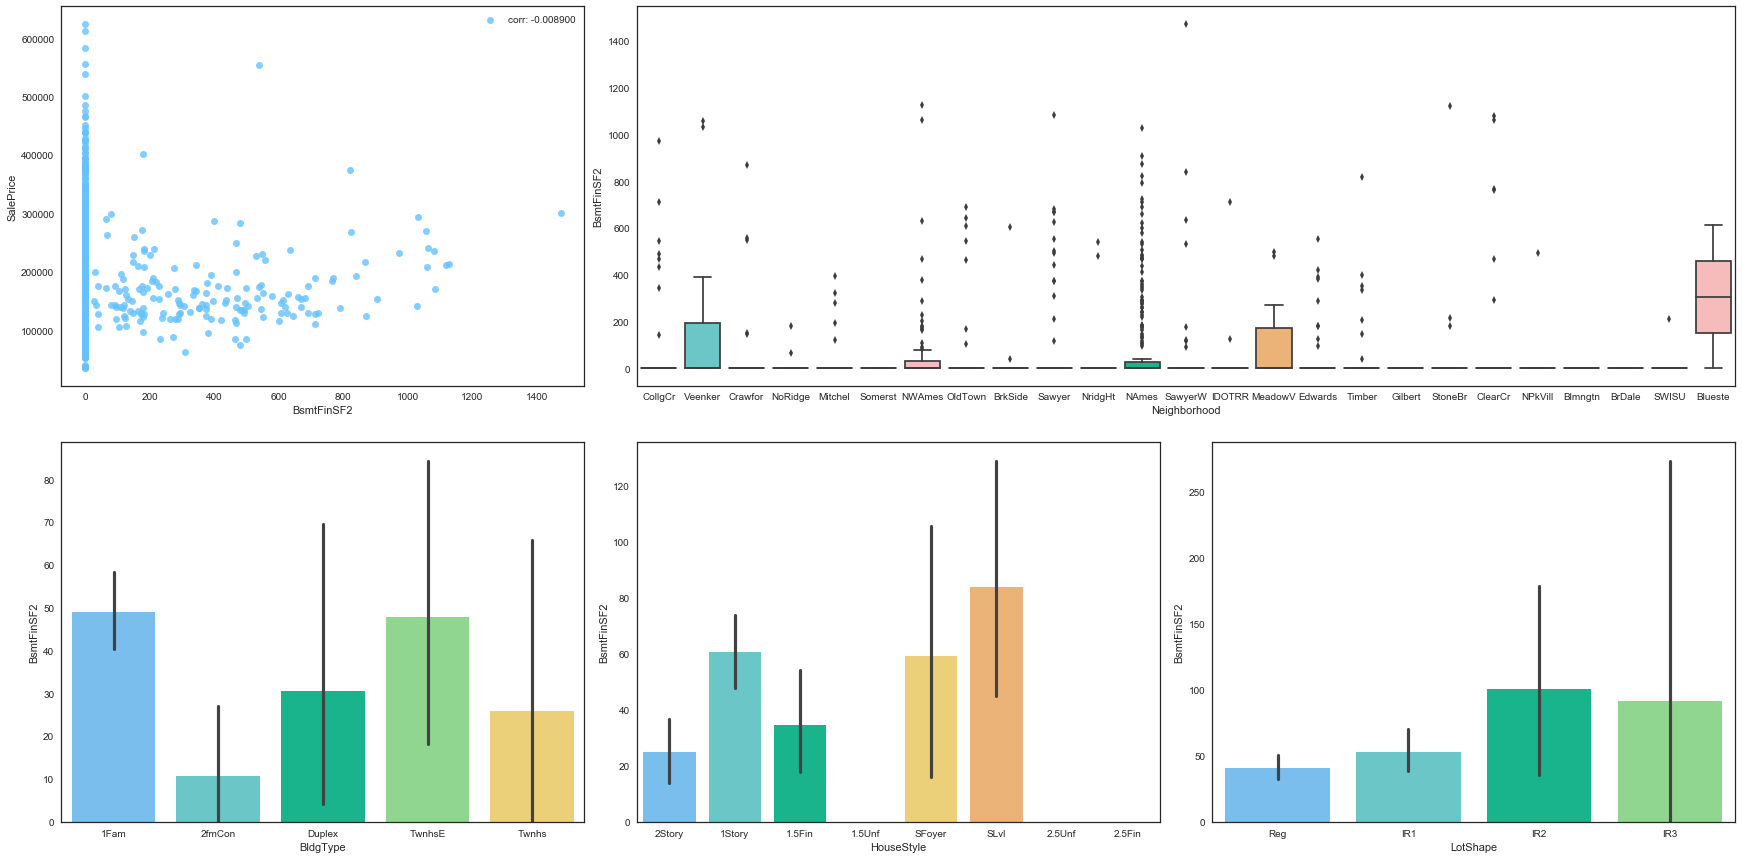

In [209]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['BsmtFinSF2'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['BsmtFinSF2'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="BsmtFinSF2", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="BsmtFinSF2", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="BsmtFinSF2", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="BsmtFinSF2", data=train, palette = mycols);

- There are a large number of data points with this feature = 0. Outside of this, there is no significant correlation with SalePrice and a large spread of values.
- Hence, I will replace this feature with a flag.

In [210]:
all_data['BsmtFinSf2_Flag'] = all_data['BsmtFinSF2'].map(lambda x:0 if x==0 else 1)
all_data.drop('BsmtFinSF2', axis=1, inplace=True)

***BsmtUnfSF***
- Unfinished square feet of basement area

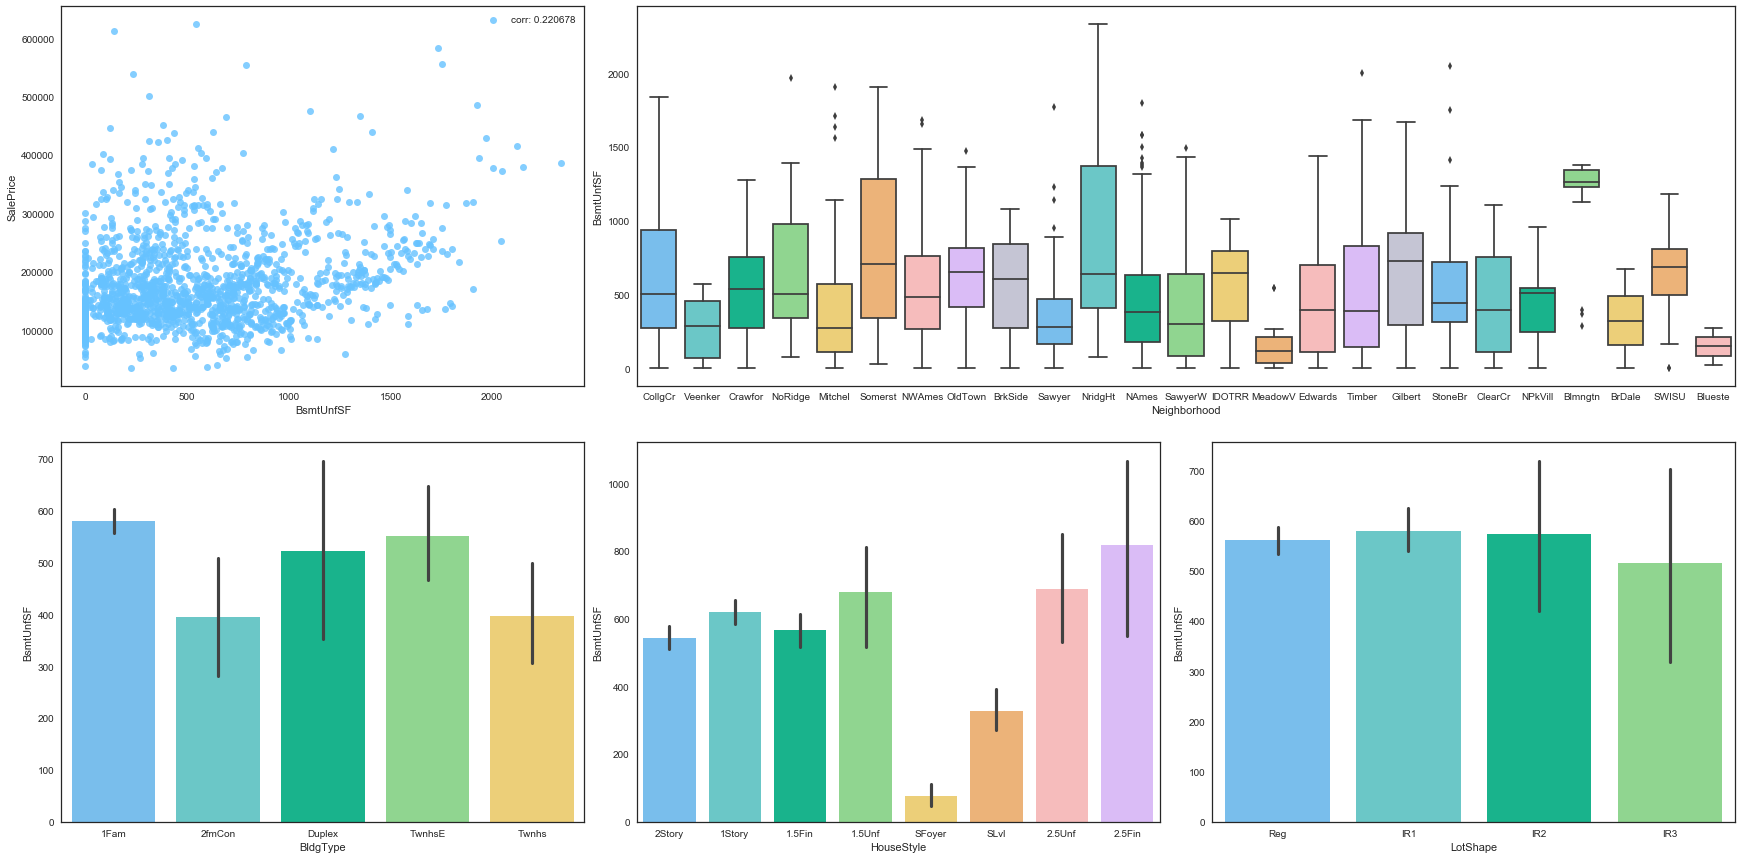

In [211]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['BsmtUnfSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['BsmtUnfSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="BsmtUnfSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="BsmtUnfSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="BsmtUnfSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="BsmtUnfSF", data=train, palette = mycols);

- This feature has a significant positive correlation with SalePrice, with a small proportion of data points having a value of 0. This tells me that most houses will have some amount of square feet unfinished within the basement, and this actually positively contributes towards SalePrice. 
- The amount of unfinished square feet also varies widely based on location and style. 
- Whereas the average unfinished square feet within the basement is fairly consistent across the different lot shapes.
- Since this is a continuous numeric feature with a significant correlation, I will bin this and create dummy variables. 

In [212]:
all_data['BsmtUnfSF_Band'] = pd.cut(all_data['BsmtUnfSF'], 3)
all_data['BsmtUnfSF_Band'].unique()

[(-2.336, 778.667], (778.667, 1557.333], (1557.333, 2336.0]]
Categories (3, interval[float64]): [(-2.336, 778.667] < (778.667, 1557.333] < (1557.333, 2336.0]]

In [213]:
all_data.loc[all_data['BsmtUnfSF']<=778.667, 'BsmtUnfSF'] = 1
all_data.loc[(all_data['BsmtUnfSF']>778.667) & (all_data['BsmtUnfSF']<=1557.333), 'BsmtUnfSF'] = 2
all_data.loc[all_data['BsmtUnfSF']>1557.333, 'BsmtUnfSF'] = 3
all_data['BsmtUnfSF'] = all_data['BsmtUnfSF'].astype(int)

all_data.drop('BsmtUnfSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["BsmtUnfSF"], prefix="BsmtUnfSF")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFullBath  BsmtHalfBath     ...      BsmtFinType2_BLQ  \
0             1           1.0           0.0     ...                     0   
1             4           0.0           1.0     ...                     0   
2             2           1.0           0.0     ...                     0   

  BsmtFinType2_GLQ BsmtFinType2_LwQ BsmtFinType2_None BsmtFinType2_Rec  \
0                0                0                 0                0   
1                0                0                 0                0   
2                0                0                 0                0   

   BsmtFinType2_Unf BsmtFinSf2_Flag BsmtUnfSF_1 BsmtUnfSF_2 BsmtUnfSF_3  
0                 1               0           1           0           0  
1                 1               0           1           0           0  
2                 1               0           1           0           0  

[3 rows x 140 columns]

***TotalBsmtSF***
- Total square feet of basement area.

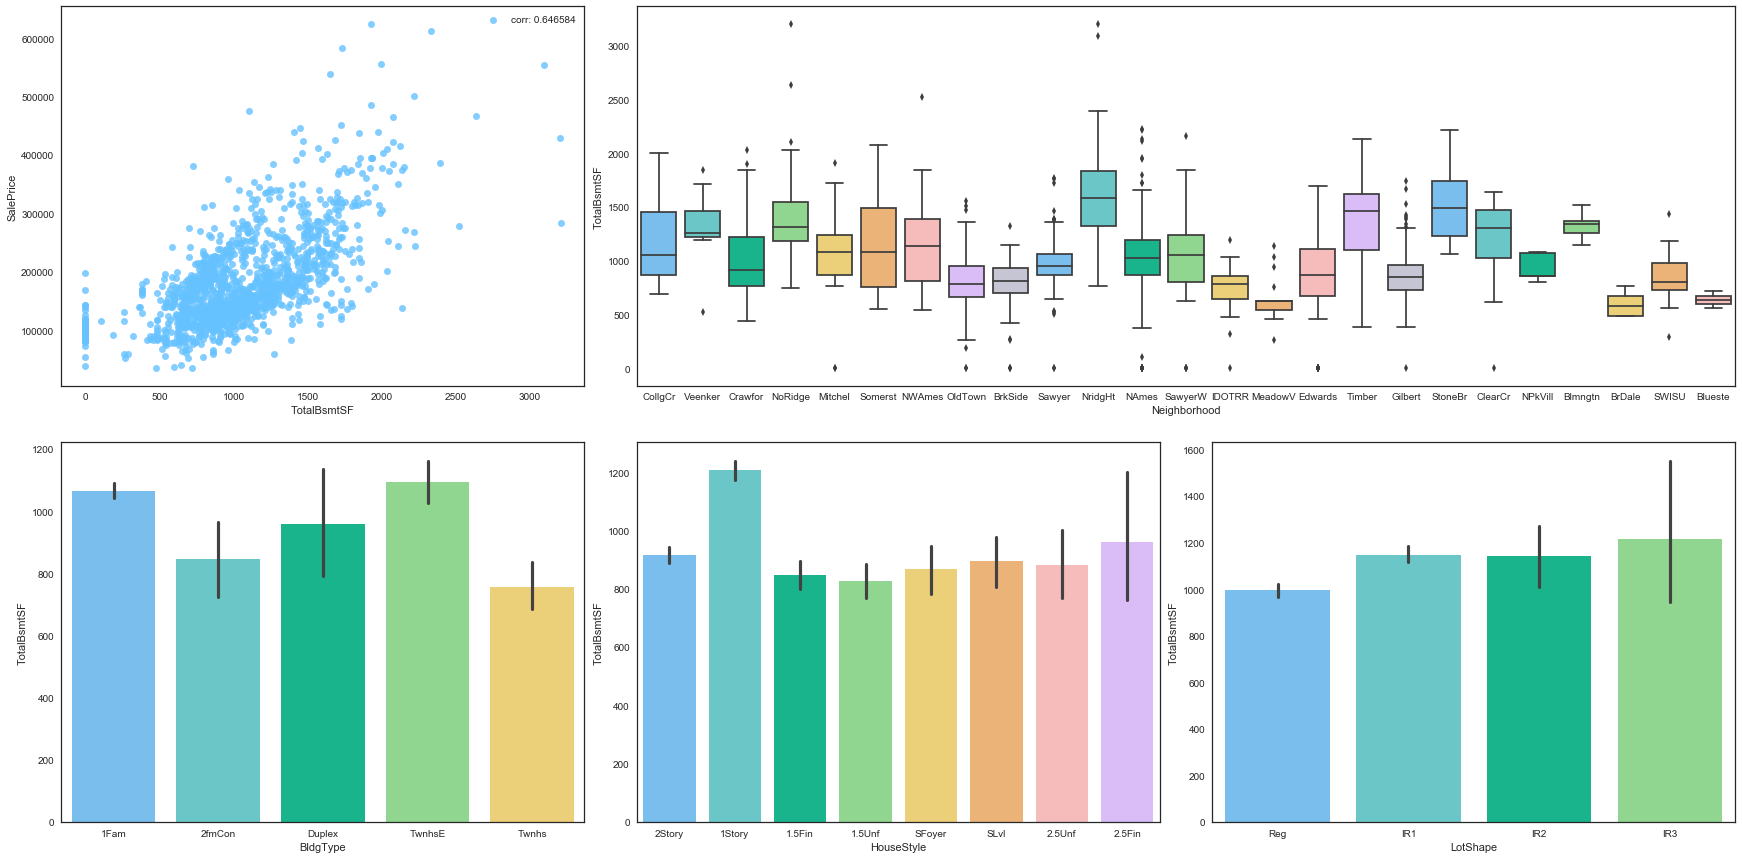

In [214]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['TotalBsmtSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['TotalBsmtSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="TotalBsmtSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="TotalBsmtSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="TotalBsmtSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="TotalBsmtSF", data=train, palette = mycols);

- This will be a very important feature within my analysis, due to such a high correlation with Saleprice.
- We can see that it varies widely based on location, however the average basement size has a lower variance based on type, style and lot shape.
- Due to this being a continuous numeric feature and also being a very significant feature when describing SalePrice, I believe there could be more value to be mined within this feature. Hence, I will create some binnings and dummy variables. 

In [215]:
all_data['TotalBsmtSF_Band'] = pd.cut(all_data['TotalBsmtSF'], 10)
all_data['TotalBsmtSF_Band'].unique()

[(509.5, 1019.0], (1019.0, 1528.5], (1528.5, 2038.0], (-5.095, 509.5], (2038.0, 2547.5], (3057.0, 3566.5], (2547.5, 3057.0], (4585.5, 5095.0]]
Categories (8, interval[float64]): [(-5.095, 509.5] < (509.5, 1019.0] < (1019.0, 1528.5] < (1528.5, 2038.0] < (2038.0, 2547.5] < (2547.5, 3057.0] < (3057.0, 3566.5] < (4585.5, 5095.0]]

In [216]:
all_data.loc[all_data['TotalBsmtSF']<=509.5, 'TotalBsmtSF'] = 1
all_data.loc[(all_data['TotalBsmtSF']>509.5) & (all_data['TotalBsmtSF']<=1019), 'TotalBsmtSF'] = 2
all_data.loc[(all_data['TotalBsmtSF']>1019) & (all_data['TotalBsmtSF']<=1528.5), 'TotalBsmtSF'] = 3
all_data.loc[(all_data['TotalBsmtSF']>1528.5) & (all_data['TotalBsmtSF']<=2038), 'TotalBsmtSF'] = 4
all_data.loc[(all_data['TotalBsmtSF']>2038) & (all_data['TotalBsmtSF']<=2547.5), 'TotalBsmtSF'] = 5
all_data.loc[(all_data['TotalBsmtSF']>2547.5) & (all_data['TotalBsmtSF']<=3057), 'TotalBsmtSF'] = 6
all_data.loc[(all_data['TotalBsmtSF']>3057) & (all_data['TotalBsmtSF']<=3566.5), 'TotalBsmtSF'] = 7
all_data.loc[all_data['TotalBsmtSF']>3566.5, 'TotalBsmtSF'] = 8
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].astype(int)

all_data.drop('TotalBsmtSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["TotalBsmtSF"], prefix="TotalBsmtSF")
all_data.head(3)

1stFlrSF  2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  \
0       856       854          0  None             3     1Fam         3   
1      1262         0          0  None             3     1Fam         3   
2       920       866          0  None             3     1Fam         3   

   BsmtExposure  BsmtFullBath  BsmtHalfBath      ...       BsmtUnfSF_2  \
0             1           1.0           0.0      ...                 0   
1             4           0.0           1.0      ...                 0   
2             2           1.0           0.0      ...                 0   

  BsmtUnfSF_3 TotalBsmtSF_1 TotalBsmtSF_2 TotalBsmtSF_3  TotalBsmtSF_4  \
0           0             0             1             0              0   
1           0             0             0             1              0   
2           0             0             1             0              0   

  TotalBsmtSF_5 TotalBsmtSF_6 TotalBsmtSF_7 TotalBsmtSF_8  
0             0             0             0             0  
1             0             0             0             0  
2             0             0             0             0  

[3 rows x 147 columns]

***1stFlrSF***
- First floor square feet.

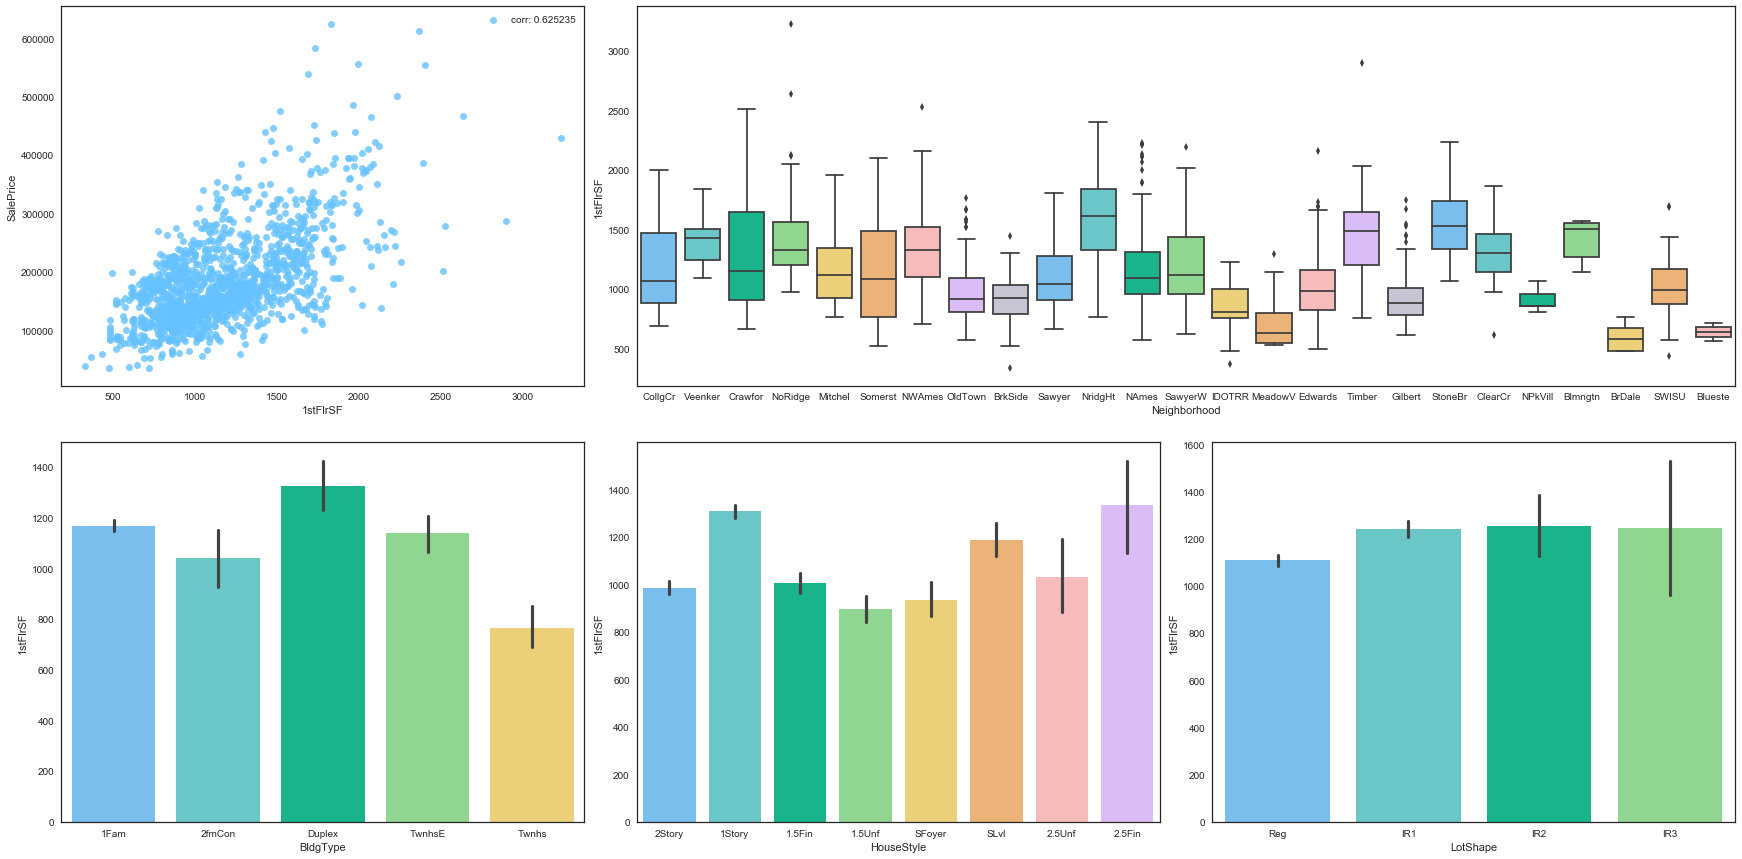

In [217]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['1stFlrSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['1stFlrSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="1stFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="1stFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="1stFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="1stFlrSF", data=train, palette = mycols);

- Clearly this shows a very high positive correlation with SalePrice, this will be an important feature during modeling.
- Once again, this feature varies greatly across neighborhoods and the size of this feature varies across building types and styles. 
- This feature does not vary so much across the lot size.
- Since this is a continuous numeric feature, once again I will bin this feature and create dummy variables.

In [218]:
all_data['1stFlrSF_Band'] = pd.cut(all_data['1stFlrSF'], 6)
all_data['1stFlrSF_Band'].unique()

[(329.239, 1127.5], (1127.5, 1921.0], (1921.0, 2714.5], (2714.5, 3508.0], (3508.0, 4301.5], (4301.5, 5095.0]]
Categories (6, interval[float64]): [(329.239, 1127.5] < (1127.5, 1921.0] < (1921.0, 2714.5] < (2714.5, 3508.0] < (3508.0, 4301.5] < (4301.5, 5095.0]]

In [219]:
all_data.loc[all_data['1stFlrSF']<=1127.5, '1stFlrSF'] = 1
all_data.loc[(all_data['1stFlrSF']>1127.5) & (all_data['1stFlrSF']<=1921), '1stFlrSF'] = 2
all_data.loc[(all_data['1stFlrSF']>1921) & (all_data['1stFlrSF']<=2714.5), '1stFlrSF'] = 3
all_data.loc[(all_data['1stFlrSF']>2714.5) & (all_data['1stFlrSF']<=3508), '1stFlrSF'] = 4
all_data.loc[(all_data['1stFlrSF']>3508) & (all_data['1stFlrSF']<=4301.5), '1stFlrSF'] = 5
all_data.loc[all_data['1stFlrSF']>4301.5, '1stFlrSF'] = 6
all_data['1stFlrSF'] = all_data['1stFlrSF'].astype(int)

all_data.drop('1stFlrSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["1stFlrSF"], prefix="1stFlrSF")
all_data.head(3)

2ndFlrSF  3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  BsmtExposure  \
0       854          0  None             3     1Fam         3             1   
1         0          0  None             3     1Fam         3             4   
2       866          0  None             3     1Fam         3             2   

   BsmtFullBath  BsmtHalfBath  BsmtQual    ...     TotalBsmtSF_5  \
0           1.0           0.0         3    ...                 0   
1           0.0           1.0         3    ...                 0   
2           1.0           0.0         3    ...                 0   

  TotalBsmtSF_6 TotalBsmtSF_7 TotalBsmtSF_8  1stFlrSF_1 1stFlrSF_2 1stFlrSF_3  \
0             0             0             0           1          0          0   
1             0             0             0           0          1          0   
2             0             0             0           1          0          0   

  1stFlrSF_4 1stFlrSF_5 1stFlrSF_6  
0          0          0          0  
1          0          0          0  
2          0          0          0  

[3 rows x 152 columns]

***2ndFlrSF***
- Second floor square feet.

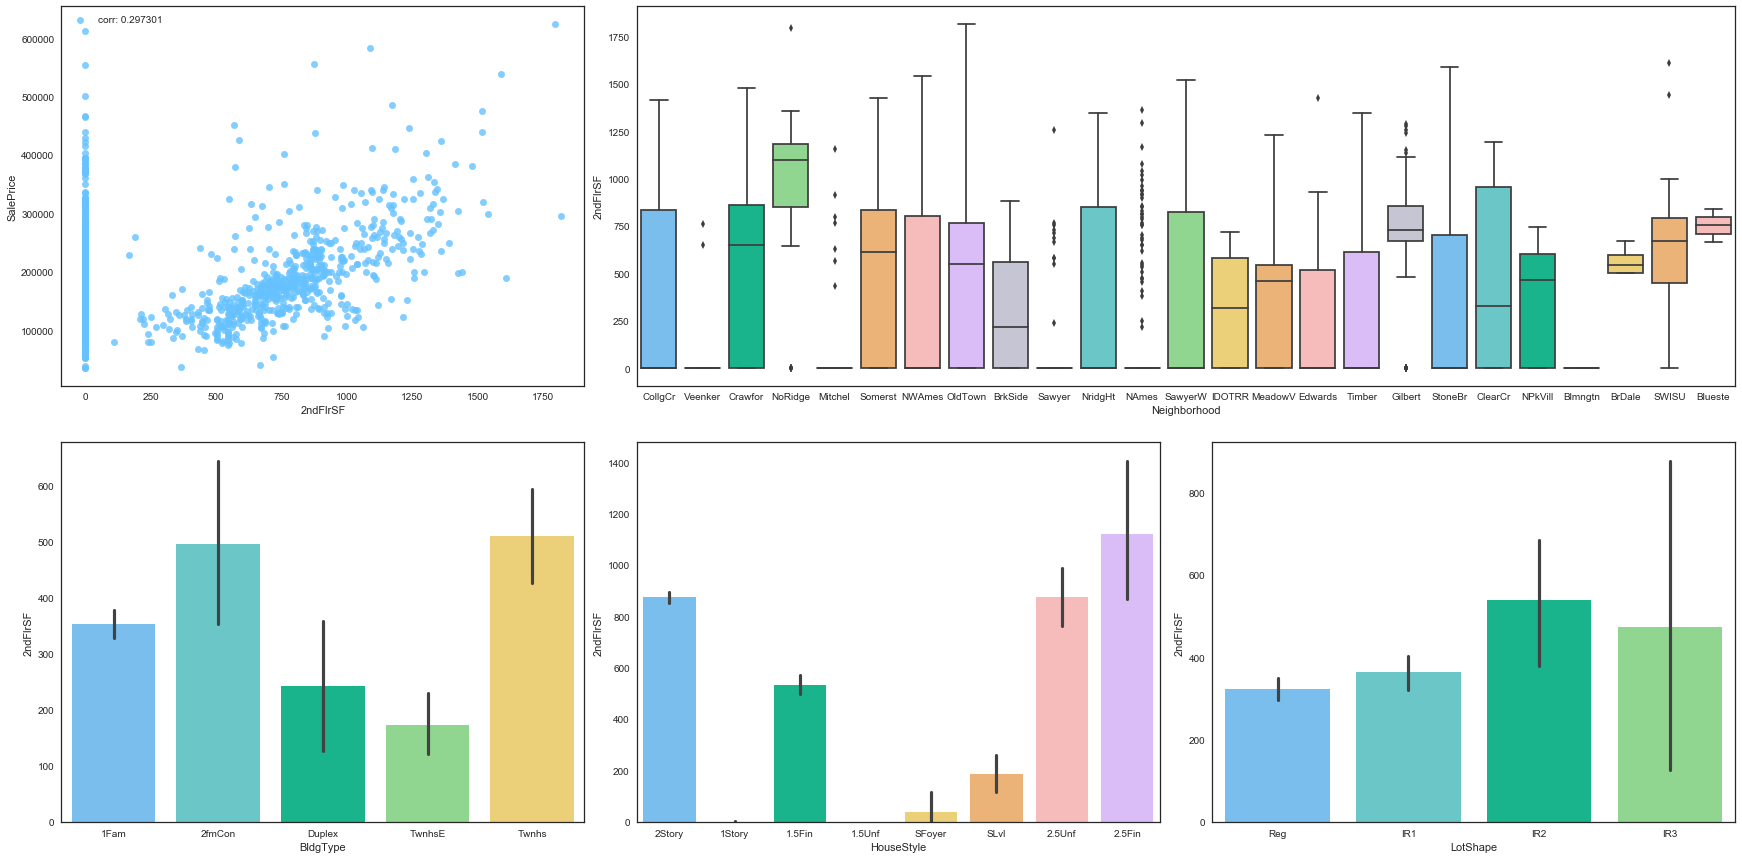

In [220]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['2ndFlrSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['2ndFlrSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="2ndFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="2ndFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="2ndFlrSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="2ndFlrSF", data=train, palette = mycols);

- Interestingly we see a highly positively correlated relationship with SalePrice, however we also see a significant number of houses with value = 0.
- This is explained with the other visuals, showing that some styles of houses perhaps do not have a second floor, hence cannot have a value for this feature - such as "1Story" houses.
- We also see a high dependance and variation between neighborhoods, building types and lot sizes.
- It is evident that all the variables related to "space" are important in this analysis. Since this feature is a continuous numeric feature, I will bin this and create dummy variables.

In [221]:
all_data['2ndFlrSF_Band'] = pd.cut(all_data['2ndFlrSF'], 6)
all_data['2ndFlrSF_Band'].unique()

[(620.667, 931.0], (-1.862, 310.333], (931.0, 1241.333], (310.333, 620.667], (1241.333, 1551.667], (1551.667, 1862.0]]
Categories (6, interval[float64]): [(-1.862, 310.333] < (310.333, 620.667] < (620.667, 931.0] < (931.0, 1241.333] < (1241.333, 1551.667] < (1551.667, 1862.0]]

In [222]:
all_data.loc[all_data['2ndFlrSF']<=310.333, '2ndFlrSF'] = 1
all_data.loc[(all_data['2ndFlrSF']>310.333) & (all_data['2ndFlrSF']<=620.667), '2ndFlrSF'] = 2
all_data.loc[(all_data['2ndFlrSF']>620.667) & (all_data['2ndFlrSF']<=931), '2ndFlrSF'] = 3
all_data.loc[(all_data['2ndFlrSF']>931) & (all_data['2ndFlrSF']<=1241.333), '2ndFlrSF'] = 4
all_data.loc[(all_data['2ndFlrSF']>1241.333) & (all_data['2ndFlrSF']<=1551.667), '2ndFlrSF'] = 5
all_data.loc[all_data['2ndFlrSF']>1551.667, '2ndFlrSF'] = 6
all_data['2ndFlrSF'] = all_data['2ndFlrSF'].astype(int)

all_data.drop('2ndFlrSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["2ndFlrSF"], prefix="2ndFlrSF")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  BsmtExposure  \
0          0  None             3     1Fam         3             1   
1          0  None             3     1Fam         3             4   
2          0  None             3     1Fam         3             2   

   BsmtFullBath  BsmtHalfBath  BsmtQual CentralAir    ...     1stFlrSF_3  \
0           1.0           0.0         3          Y    ...              0   
1           0.0           1.0         3          Y    ...              0   
2           1.0           0.0         3          Y    ...              0   

  1stFlrSF_4 1stFlrSF_5  1stFlrSF_6 2ndFlrSF_1 2ndFlrSF_2 2ndFlrSF_3  \
0          0          0           0          0          0          1   
1          0          0           0          1          0          0   
2          0          0           0          0          0          1   

  2ndFlrSF_4 2ndFlrSF_5 2ndFlrSF_6  
0          0          0          0  
1          0          0          0  
2          0          0          0  

[3 rows x 157 columns]

***LowQualFinSF***
- Low quality finished square feet (all floors)

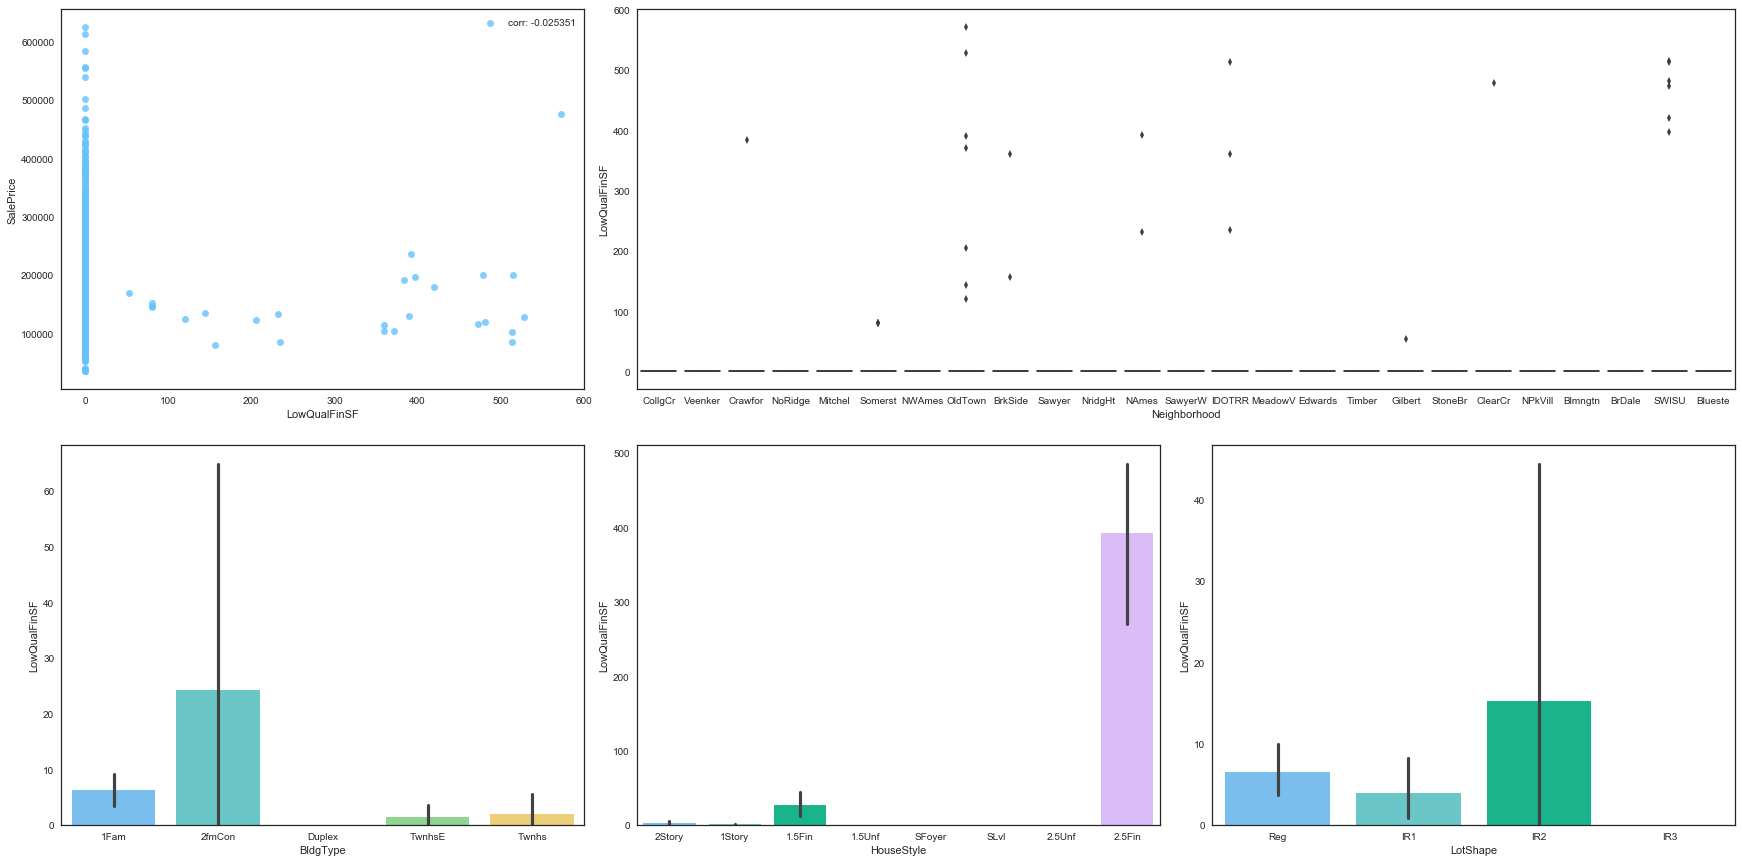

In [223]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['LowQualFinSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['LowQualFinSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="LowQualFinSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="LowQualFinSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="LowQualFinSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="LowQualFinSF", data=train, palette = mycols);

- We can see that there is a large number of properties with a value of 0 for this feature. Clearly, it does not have a significant correlation with SalePrice.
- For this reason, I will replace this feature with a flag.

In [224]:
all_data['LowQualFinSF_Flag'] = all_data['LowQualFinSF'].map(lambda x:0 if x==0 else 1)
all_data.drop('LowQualFinSF', axis=1, inplace=True)

***BsmtHalfBath***, ***BsmtFullBath***, ***HalfBath***, ***FullBath***

- Number of bathrooms.
- For this feature, it made sense to sum them all together and create a total bathrooms feature.

In [225]:
all_data['TotalBathrooms'] = all_data['BsmtHalfBath'] + all_data['BsmtFullBath'] + all_data['HalfBath'] + all_data['FullBath']

columns = ['BsmtHalfBath', 'BsmtFullBath', 'HalfBath', 'FullBath']
all_data.drop(columns, axis=1, inplace=True)

***Bedroom***
- Bedrooms above grade (does not include basement bedrooms)

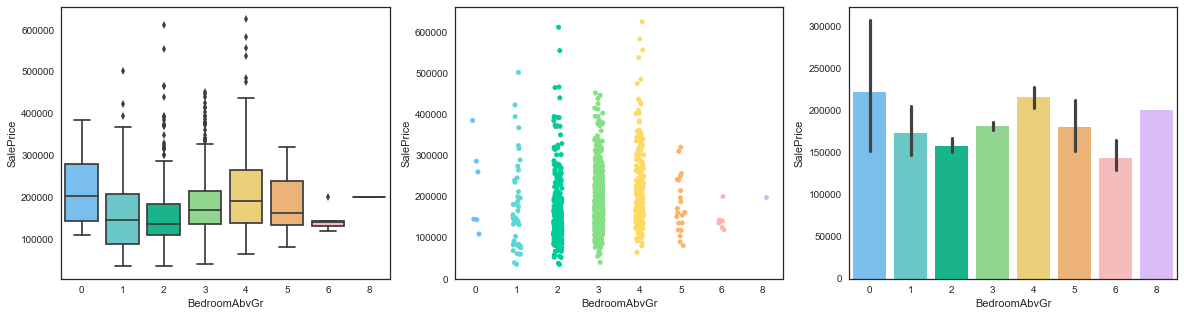

In [226]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BedroomAbvGr", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="BedroomAbvGr", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="BedroomAbvGr", y="SalePrice", data=train, palette = mycols);

- We see a lot of houses with 2 3 and 4 bedrooms above ground, and a very low number of houses with 6 or above.
- Since this is a continuous numeric feature, I will leave it how it is.

***Kitchen***
- Kitchens above grade.

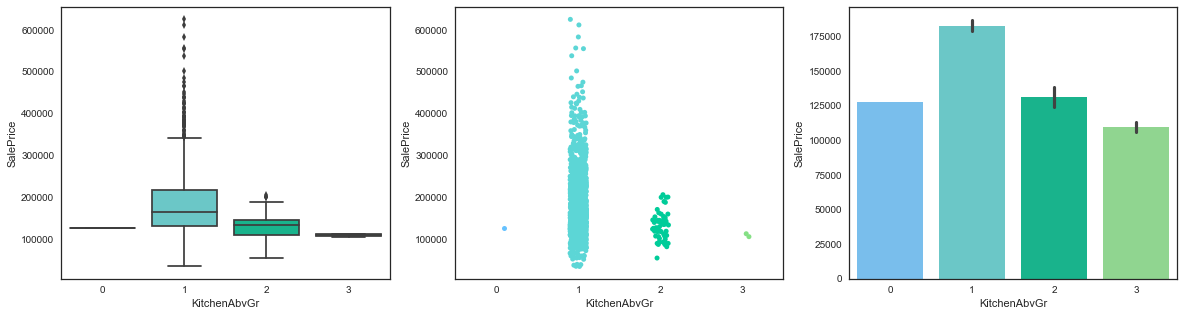

In [227]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="KitchenAbvGr", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="KitchenAbvGr", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="KitchenAbvGr", y="SalePrice", data=train, palette = mycols);

- Similarly to last previous feature, we see just a small number of houses with a large number of kitchens above grade. This shows that most houses have 1 kitchen above grade.
- Since this is a continuous numeric feature, I will leave it as it is.

***KitchenQual***
- Kitchen quality.

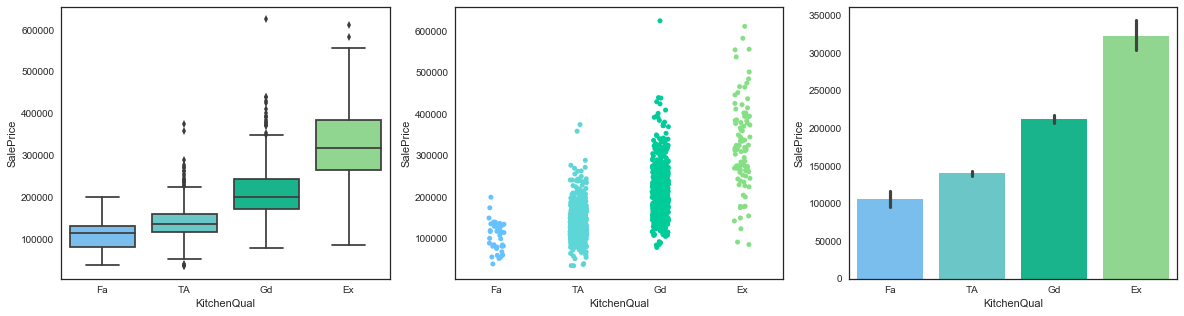

In [228]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="KitchenQual", y="SalePrice", data=train, order=["Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="KitchenQual", y="SalePrice", data=train, size = 5, jitter = True, order=["Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="KitchenQual", y="SalePrice", data=train, order=["Fa", "TA", "Gd", "Ex"], palette = mycols);

- There is a clear positive correlation with the SalePrice and the quality of the kitchen.
- There is one value for "Gd" that has an extremely high SalePrice however.
- For this feature, since it is categorical with an order, I will replace these values by hand.

In [229]:
all_data['KitchenQual'] = all_data['KitchenQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['KitchenQual'].unique()

array([3, 2, 4, 1], dtype=int64)

***TotRmsAbvGrd***
- Total rooms above grade (does not include bathrooms)

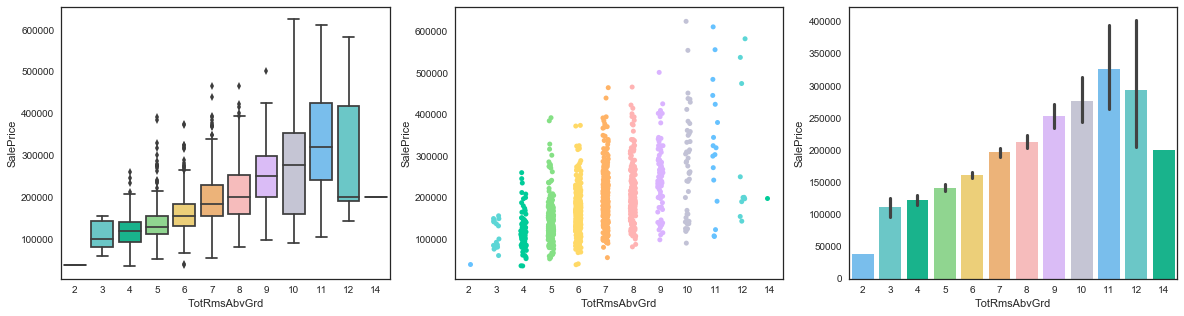

In [230]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="TotRmsAbvGrd", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="TotRmsAbvGrd", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="TotRmsAbvGrd", y="SalePrice", data=train, palette = mycols);

- Generally we see a positive correlation, as the number of rooms increases, so does the SalePrice.
- However due to low frequency, we do see some unreliable results for the very large and small values for this feature.
- Since this is a continuous numeric feature, I will leave it as it is.

***Fireplaces***
- Number of fireplaces.

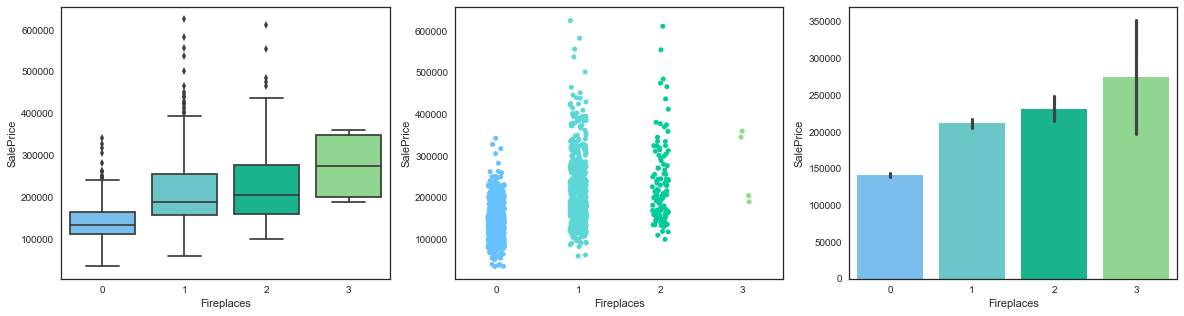

In [231]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Fireplaces", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Fireplaces", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Fireplaces", y="SalePrice", data=train, palette = mycols);

- Once again we have a positive correlation with SalePrice, with most houses having just 1 or 0 fireplaces.
- I will leave this feature as it is.

***FireplaceQu***
- Fireplace quality.

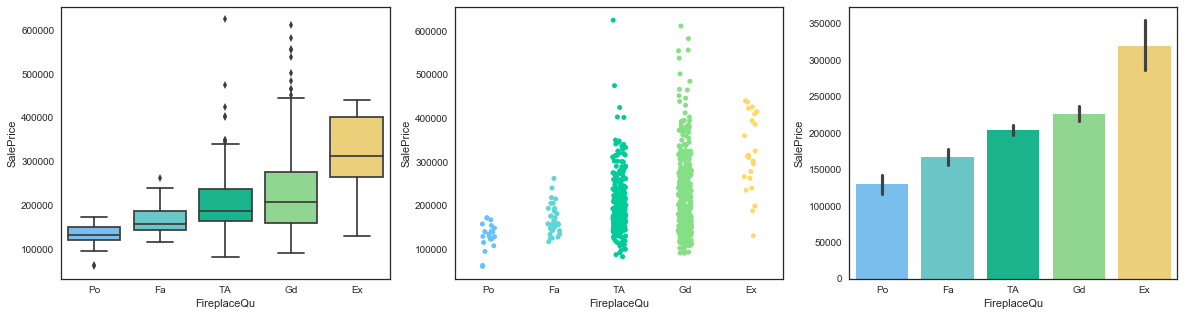

In [232]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="FireplaceQu", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="FireplaceQu", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="FireplaceQu", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

- We also see a positive correlation and the fireplace quality increases. Most houses have either "TA" or "Gd" quality fireplaces. 
- Since this is a categorical feature with order, I will replace the values by hand.

In [233]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['FireplaceQu'].unique()

array([0, 3, 4, 2, 5, 1], dtype=int64)

***GrLivArea***
- Above grade ground living area in square feet.

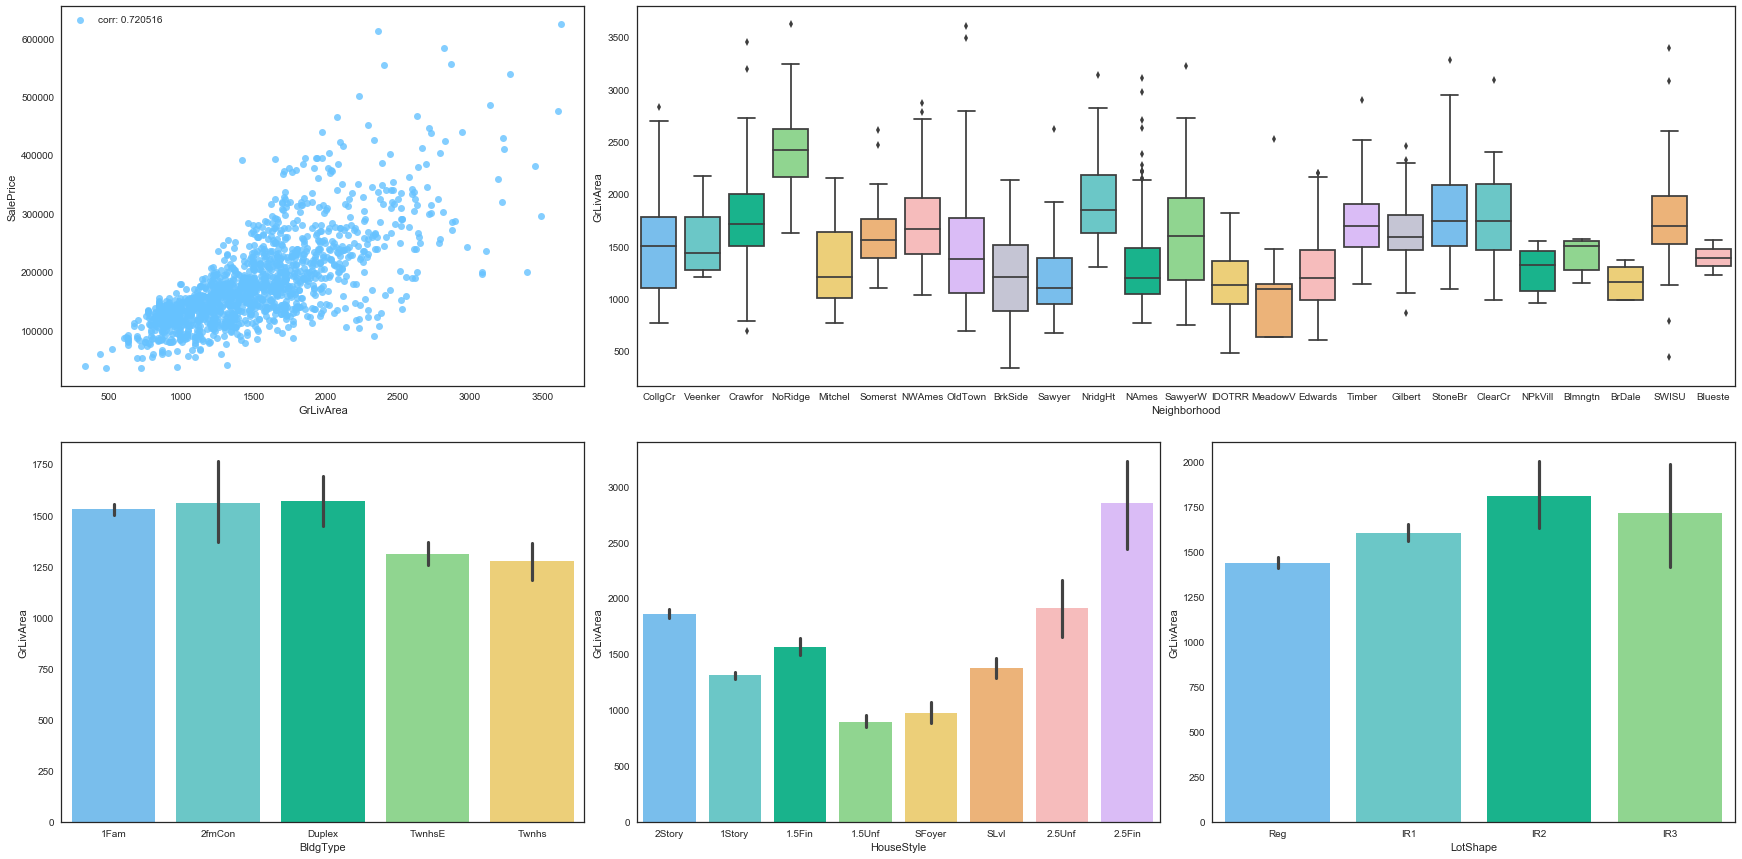

In [234]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['GrLivArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="GrLivArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="GrLivArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="GrLivArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="GrLivArea", data=train, palette = mycols);

- We see a very high positive correlation with SalePrice.
- We also see the values varying very highly between styles of houses and neigborhood.
- Since this will be an important feature in our modeling, I will create bins and dummy features.

In [235]:
all_data['GrLivArea_Band'] = pd.cut(all_data['GrLivArea'], 6)
all_data['GrLivArea_Band'].unique()

[(1127.5, 1921.0], (1921.0, 2714.5], (329.239, 1127.5], (2714.5, 3508.0], (3508.0, 4301.5], (4301.5, 5095.0]]
Categories (6, interval[float64]): [(329.239, 1127.5] < (1127.5, 1921.0] < (1921.0, 2714.5] < (2714.5, 3508.0] < (3508.0, 4301.5] < (4301.5, 5095.0]]

In [236]:
all_data.loc[all_data['GrLivArea']<=1127.5, 'GrLivArea'] = 1
all_data.loc[(all_data['GrLivArea']>1127.5) & (all_data['GrLivArea']<=1921), 'GrLivArea'] = 2
all_data.loc[(all_data['GrLivArea']>1921) & (all_data['GrLivArea']<=2714.5), 'GrLivArea'] = 3
all_data.loc[(all_data['GrLivArea']>2714.5) & (all_data['GrLivArea']<=3508), 'GrLivArea'] = 4
all_data.loc[(all_data['GrLivArea']>3508) & (all_data['GrLivArea']<=4301.5), 'GrLivArea'] = 5
all_data.loc[all_data['GrLivArea']>4301.5, 'GrLivArea'] = 6
all_data['GrLivArea'] = all_data['GrLivArea'].astype(int)

all_data.drop('GrLivArea_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GrLivArea"], prefix="GrLivArea")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  BsmtExposure  BsmtQual  \
0          0  None             3     1Fam         3             1         3   
1          0  None             3     1Fam         3             4         3   
2          0  None             3     1Fam         3             2         3   

  CentralAir Condition1 Condition2     ...     2ndFlrSF_5  2ndFlrSF_6  \
0          Y       Norm       Norm     ...              0           0   
1          Y      Feedr       Norm     ...              0           0   
2          Y       Norm       Norm     ...              0           0   

  LowQualFinSF_Flag TotalBathrooms GrLivArea_1 GrLivArea_2 GrLivArea_3  \
0                 0            4.0           0           1           0   
1                 0            3.0           0           1           0   
2                 0            4.0           0           1           0   

   GrLivArea_4  GrLivArea_5 GrLivArea_6  
0            0            0           0  
1            0            0           0  
2            0            0           0  

[3 rows x 159 columns]

<a id='architectural_&_structural'></a>
#### 4.2.3 - Architectural & Structural

***MSSubClass***
- Identifies the type of dwelling involved in the sale.

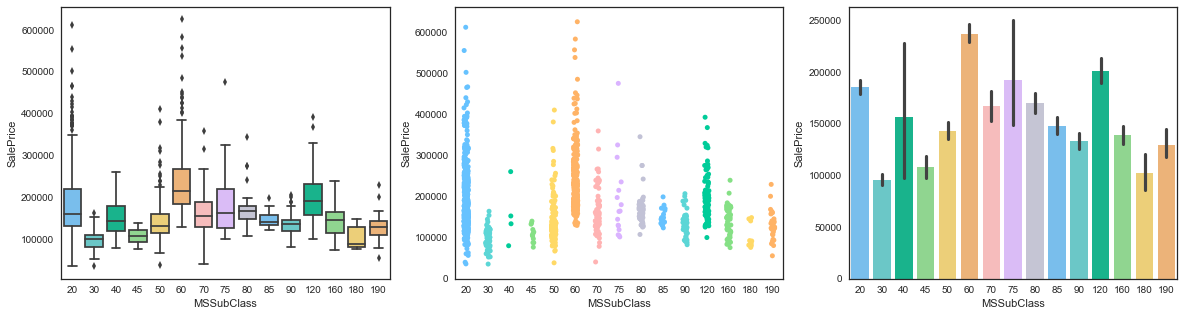

In [237]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MSSubClass", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="MSSubClass", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MSSubClass", y="SalePrice", data=train, palette = mycols);

- Each of these classes represents a very different style of building, as shown in the data description. Hence, we can see large variance between classes with SalePrice. 
- This is a numeric feature, but it should actually be categorical. I could cluster some of these categories together, but for now I will create a dummy feature for each category.

In [238]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

all_data = pd.get_dummies(all_data, columns = ["MSSubClass"], prefix="MSSubClass")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr BldgType  BsmtCond  BsmtExposure  BsmtQual  \
0          0  None             3     1Fam         3             1         3   
1          0  None             3     1Fam         3             4         3   
2          0  None             3     1Fam         3             2         3   

  CentralAir Condition1 Condition2      ...      MSSubClass_30  MSSubClass_40  \
0          Y       Norm       Norm      ...                  0              0   
1          Y      Feedr       Norm      ...                  0              0   
2          Y       Norm       Norm      ...                  0              0   

  MSSubClass_45 MSSubClass_50 MSSubClass_60 MSSubClass_70 MSSubClass_75  \
0             0             0             1             0             0   
1             0             0             0             0             0   
2             0             0             1             0             0   

   MSSubClass_80  MSSubClass_85 MSSubClass_90  
0              0              0             0  
1              0              0             0  
2              0              0             0  

[3 rows x 174 columns]

***BldgType***
- Type of dwelling.

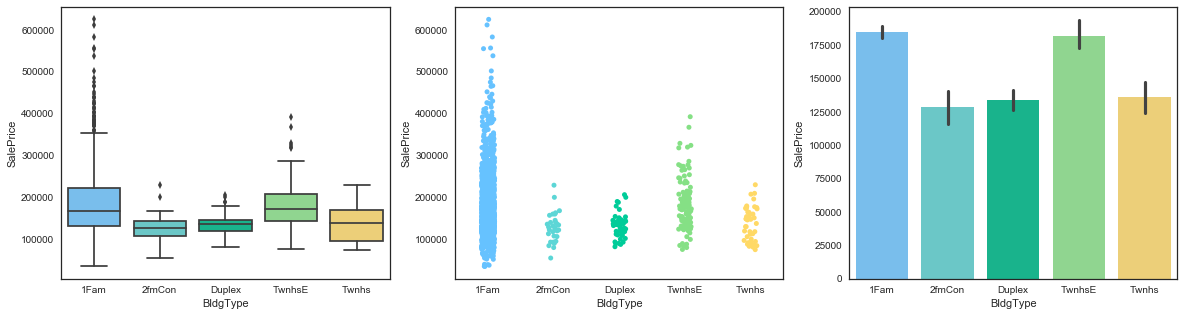

In [239]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="BldgType", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="BldgType", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="BldgType", y="SalePrice", data=train, palette = mycols);

- The different categories exhibit a range of average SalePrice's. The class with the most observations is "1Fam". 
- We can also see that the variance within classes is quite tight, with only a few extreme values in each case.
- There could be a possibility to cluster these classes, however for now I am going to create dummy features.

In [240]:
all_data['BldgType'] = all_data['BldgType'].astype(str)

all_data = pd.get_dummies(all_data, columns = ["BldgType"], prefix="BldgType")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...        MSSubClass_70  \
0       Norm       Norm      SBrkr       ...                    0   
1      Feedr       Norm      SBrkr       ...                    0   
2       Norm       Norm      SBrkr       ...                    0   

  MSSubClass_75 MSSubClass_80 MSSubClass_85 MSSubClass_90 BldgType_1Fam  \
0             0             0             0             0             1   
1             0             0             0             0             1   
2             0             0             0             0             1   

   BldgType_2fmCon  BldgType_Duplex BldgType_Twnhs BldgType_TwnhsE  
0                0                0              0               0  
1                0                0              0               0  
2                0                0              0               0  

[3 rows x 178 columns]

***HouseStyle***
- Style of dwelling.

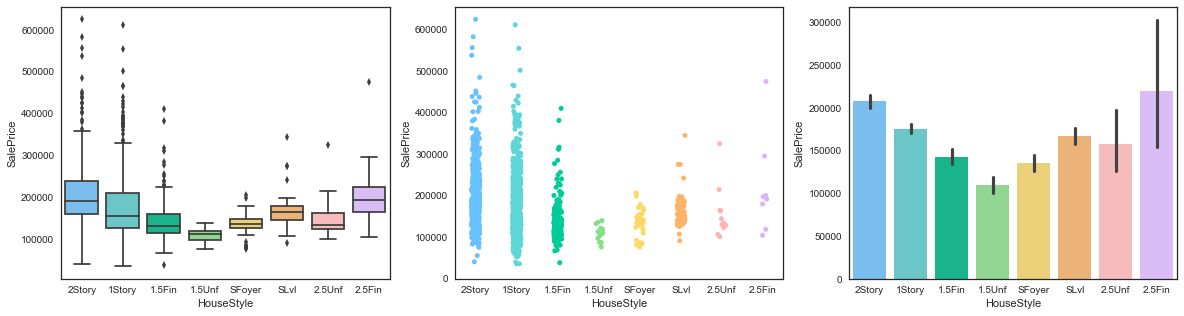

In [241]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="HouseStyle", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="HouseStyle", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="HouseStyle", y="SalePrice", data=train, palette = mycols);

- Here we see quite a few extreme values across the categories and a large weighting of observations towards the integer story houses.
- Although the highest average SalePrice comes from "2.5Fin", this has a very high standard deviation and therefore more reliably, the "2Story" houses are also very highly priced on average.
- Since there are some categories with very few values, I will cluster these into another category and create dummy variables.

In [242]:
all_data['HouseStyle'] = all_data['HouseStyle'].map({"2Story":"2Story", "1Story":"1Story", "1.5Fin":"1.5Story", "1.5Unf":"1.5Story", 
                                                     "SFoyer":"SFoyer", "SLvl":"SLvl", "2.5Unf":"2.5Story", "2.5Fin":"2.5Story"})

all_data = pd.get_dummies(all_data, columns = ["HouseStyle"], prefix="HouseStyle")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...        BldgType_2fmCon  \
0       Norm       Norm      SBrkr       ...                      0   
1      Feedr       Norm      SBrkr       ...                      0   
2       Norm       Norm      SBrkr       ...                      0   

  BldgType_Duplex BldgType_Twnhs BldgType_TwnhsE HouseStyle_1.5Story  \
0               0              0               0                   0   
1               0              0               0                   0   
2               0              0               0                   0   

  HouseStyle_1Story  HouseStyle_2.5Story  HouseStyle_2Story HouseStyle_SFoyer  \
0                 0                    0                  1                 0   
1                 1                    0                  0                 0   
2                 0                    0                  1                 0   

  HouseStyle_SLvl  
0               0  
1               0  
2               0  

[3 rows x 183 columns]

***OverallQual***
- Rates the overall material and finish of the house.

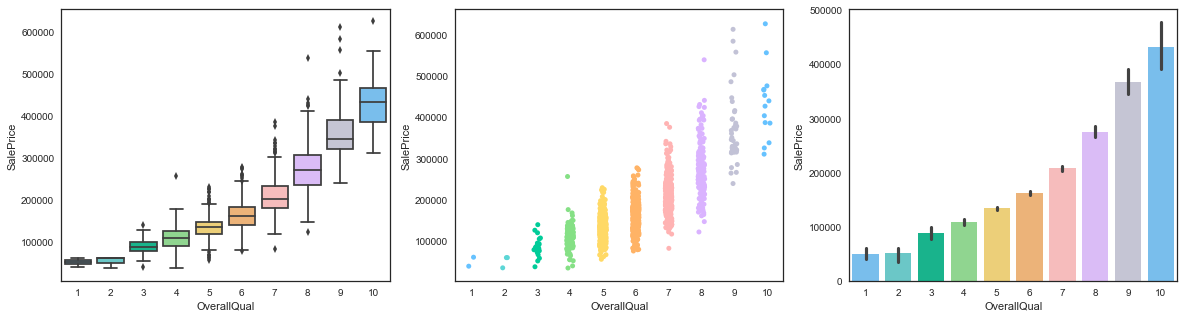

In [243]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="OverallQual", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="OverallQual", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="OverallQual", y="SalePrice", data=train, palette = mycols);

- This feature although being numeric is actually categoric and ordinal, as the value increases so does the SalePrice. Hence, I will keep it as a numeric feature.
- We see here a nice positive correlation with the increase in OverallQual and the SalePrice, as you'd expect.

***OverallCond***
- Rates the overall condition of the house.

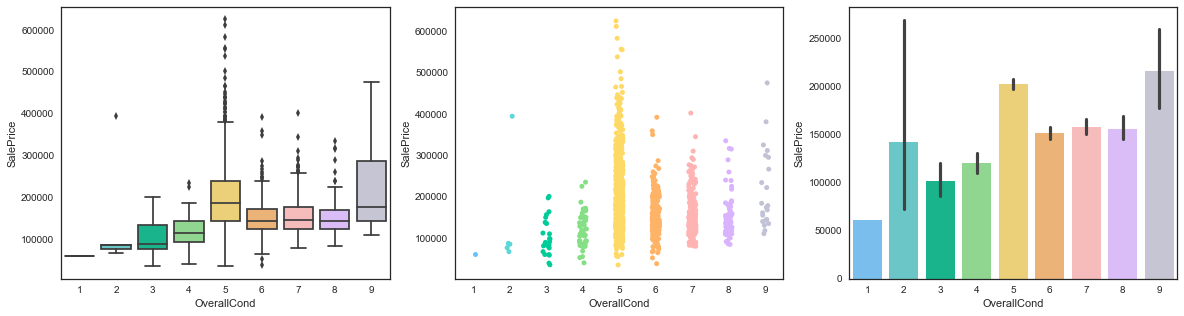

In [244]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="OverallCond", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="OverallCond", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="OverallCond", y="SalePrice", data=train, palette = mycols);

- Interestingly, we see here that it does follow a positive correlation with SalePrice, however we see a peak at a value of 5, along with a high number of observations at this value.
- The highest average SalePrice actually comes from a value of 5 as opposed to 10, which may be a reasonable assumption.
- For this feature, I will leave it as being numeric and ordinal.

***YearRemodAdd***
- Remodel date (same as construction date if no remodeling or additions).

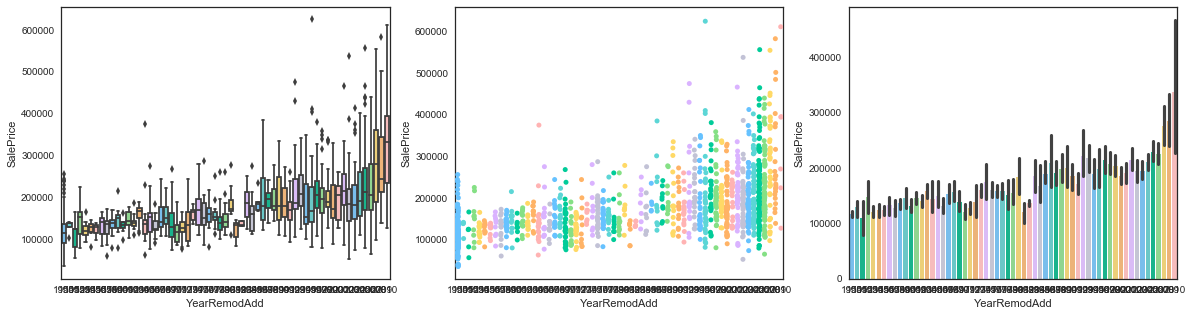

In [245]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="YearRemodAdd", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="YearRemodAdd", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="YearRemodAdd", y="SalePrice", data=train, palette = mycols);

- Here we can see that the newer the remodelling of a house, the higher the SalePrice.
- From the data description, I believe that creating a new feature describing the difference in number of years between remodeling and construction may be a good choice.

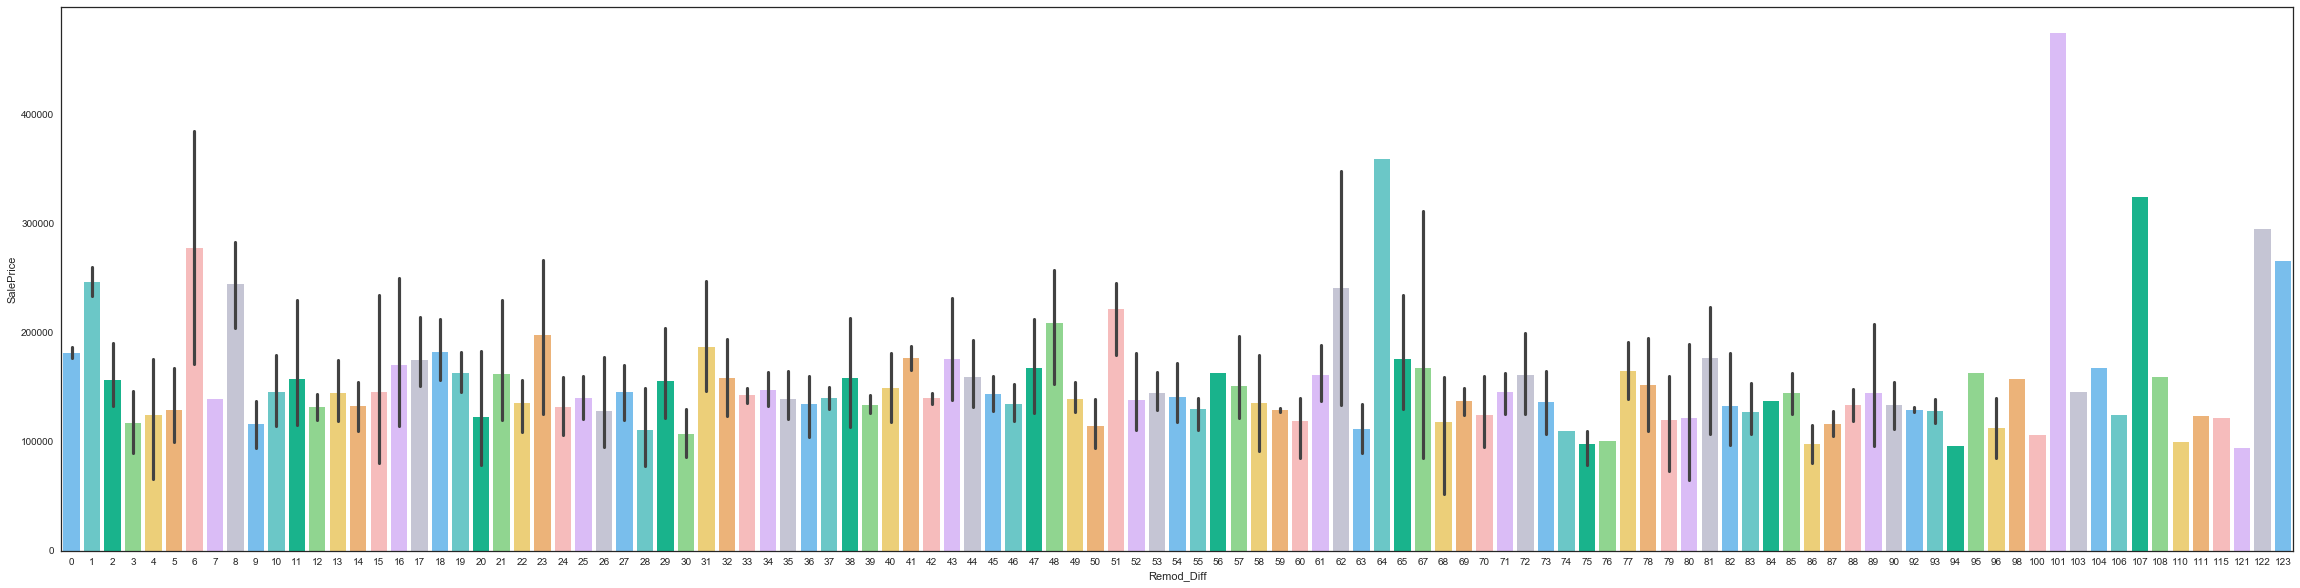

In [246]:
train['Remod_Diff'] = train['YearRemodAdd'] - train['YearBuilt']

plt.subplots(figsize =(40, 10))
sns.barplot(x="Remod_Diff", y="SalePrice", data=train, palette = mycols);

- Clearly we can see that there are some values which have a much higher SalePrice than others. I will leave this feature as it is, without any binnings.

In [247]:
all_data['Remod_Diff'] = all_data['YearRemodAdd'] - all_data['YearBuilt']

all_data.drop('YearRemodAdd', axis=1, inplace=True)

***YearBuilt***
- Original construction date.

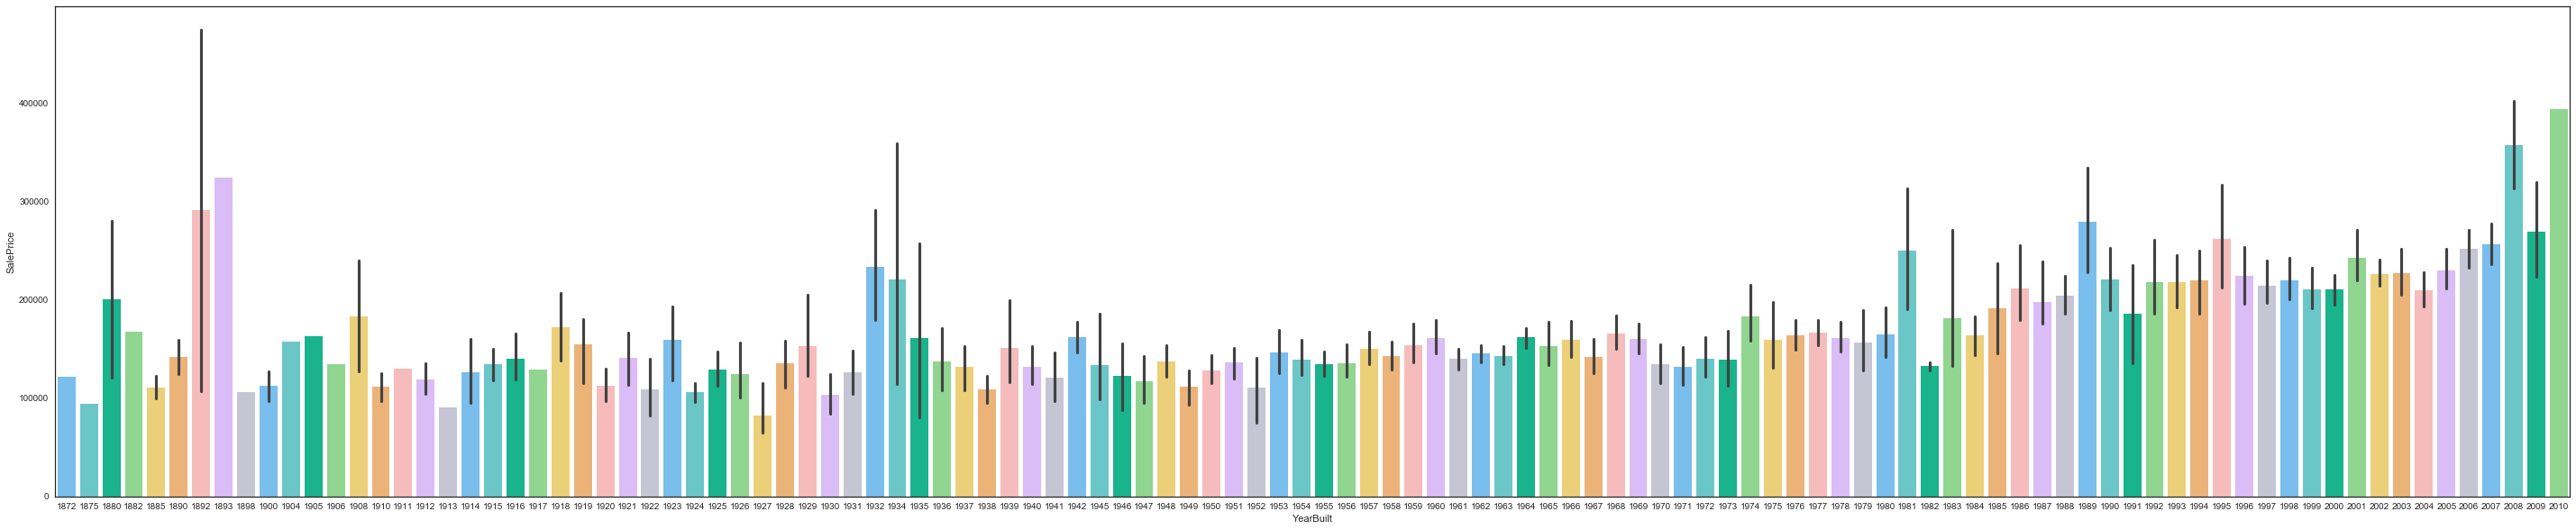

In [248]:
plt.subplots(figsize =(50, 10))

sns.barplot(x="YearBuilt", y="SalePrice", data=train, palette = mycols);

- Here we can see a fairly consistent upward trend for the SalePrice as houses are more modern. 
- For this feature, I am going to create bins and dummy features

In [249]:
all_data['YearBuilt_Band'] = pd.cut(all_data['YearBuilt'], 7)
all_data['YearBuilt_Band'].unique()

[(1990.286, 2010.0], (1970.571, 1990.286], (1911.429, 1931.143], (1931.143, 1950.857], (1950.857, 1970.571], (1891.714, 1911.429], (1871.862, 1891.714]]
Categories (7, interval[float64]): [(1871.862, 1891.714] < (1891.714, 1911.429] < (1911.429, 1931.143] < (1931.143, 1950.857] < (1950.857, 1970.571] < (1970.571, 1990.286] < (1990.286, 2010.0]]

In [250]:
all_data.loc[all_data['YearBuilt']<=1892, 'YearBuilt'] = 1
all_data.loc[(all_data['YearBuilt']>1892) & (all_data['YearBuilt']<=1911), 'YearBuilt'] = 2
all_data.loc[(all_data['YearBuilt']>1911) & (all_data['YearBuilt']<=1931), 'YearBuilt'] = 3
all_data.loc[(all_data['YearBuilt']>1931) & (all_data['YearBuilt']<=1951), 'YearBuilt'] = 4
all_data.loc[(all_data['YearBuilt']>1951) & (all_data['YearBuilt']<=1971), 'YearBuilt'] = 5
all_data.loc[(all_data['YearBuilt']>1971) & (all_data['YearBuilt']<=1990), 'YearBuilt'] = 6
all_data.loc[all_data['YearBuilt']>1990, 'YearBuilt'] = 7
all_data['YearBuilt'] = all_data['YearBuilt'].astype(int)

all_data.drop('YearBuilt_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["YearBuilt"], prefix="YearBuilt")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical     ...      HouseStyle_SFoyer  \
0       Norm       Norm      SBrkr     ...                      0   
1      Feedr       Norm      SBrkr     ...                      0   
2       Norm       Norm      SBrkr     ...                      0   

  HouseStyle_SLvl Remod_Diff YearBuilt_1 YearBuilt_2 YearBuilt_3  YearBuilt_4  \
0               0          0           0           0           0            0   
1               0          0           0           0           0            0   
2               0          1           0           0           0            0   

   YearBuilt_5 YearBuilt_6 YearBuilt_7  
0            0           0           1  
1            0           1           0  
2            0           0           1  

[3 rows x 189 columns]

***Foundation***
- Type of foundation.

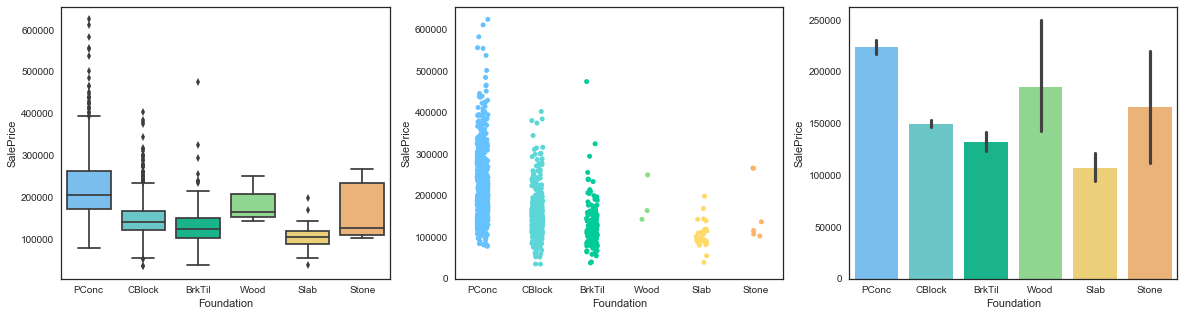

In [251]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Foundation", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="Foundation", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Foundation", y="SalePrice", data=train, palette = mycols);

- We have 3 classes with high frequency, however we have 3 of low frequency.
- Due to the large difference in median and mean SalePrice's across the 3 lower frequent classes, I am not going to cluster these together. 
- Also since this feature is not ordinal, labelling does not make sense. Instead I will create dummy variables.

In [252]:
all_data = pd.get_dummies(all_data, columns = ["Foundation"], prefix="Foundation")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...         YearBuilt_4 YearBuilt_5  \
0       Norm       Norm      SBrkr       ...                   0           0   
1      Feedr       Norm      SBrkr       ...                   0           0   
2       Norm       Norm      SBrkr       ...                   0           0   

  YearBuilt_6 YearBuilt_7 Foundation_BrkTil Foundation_CBlock  \
0           0           1                 0                 0   
1           1           0                 0                 1   
2           0           1                 0                 0   

   Foundation_PConc  Foundation_Slab Foundation_Stone  Foundation_Wood  
0                 1                0                0                0  
1                 0                0                0                0  
2                 1                0                0                0  

[3 rows x 194 columns]

***Functional***
- Home functionality.

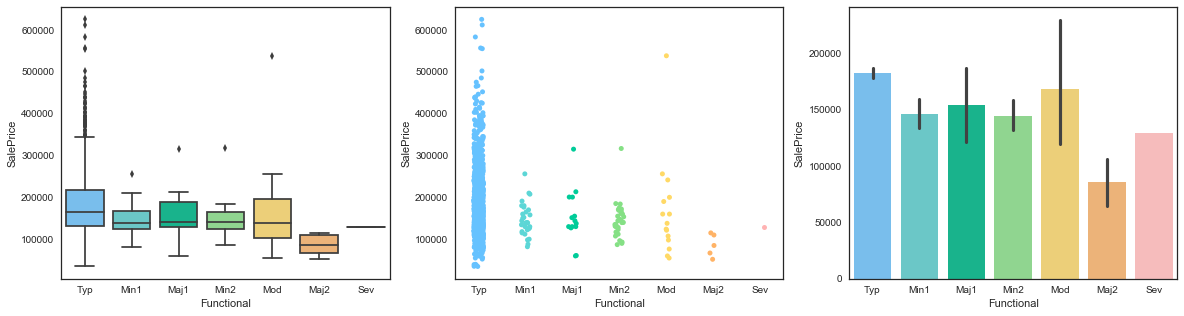

In [253]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Functional", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Functional", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Functional", y="SalePrice", data=train, palette = mycols);

- This categorical feature shows that most houses have "Typ" functionality, and looking at the data description leads me to believe that there is an order within these categories, "Typ" being of the highest order.
- Therefore, I will replace the values of this feature by hand with numbers.

In [254]:
all_data['Functional'] = all_data['Functional'].map({"Sev":1, "Maj2":2, "Maj1":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7})
all_data['Functional'].unique()

array([7, 6, 3, 5, 4, 2, 1], dtype=int64)

<a id='exterior'></a>
#### 4.2.4 - Exterior

***RoofStyle***
- Type of roof.

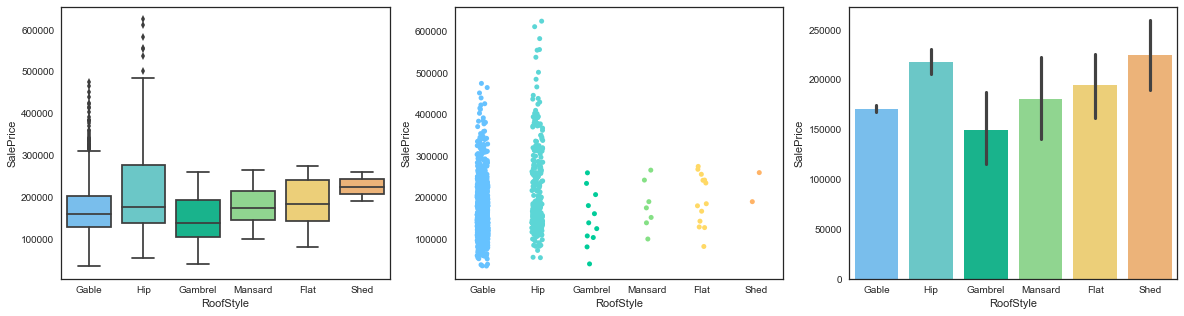

In [255]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="RoofStyle", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="RoofStyle", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="RoofStyle", y="SalePrice", data=train, palette = mycols);

- This feature has two highly frequent categories but the values of SalePrice differ between each.
- Since this is a categorical feature without order, I will create dummy variables.

In [256]:
all_data = pd.get_dummies(all_data, columns = ["RoofStyle"], prefix="RoofStyle")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...        Foundation_PConc  \
0       Norm       Norm      SBrkr       ...                       1   
1      Feedr       Norm      SBrkr       ...                       0   
2       Norm       Norm      SBrkr       ...                       1   

  Foundation_Slab Foundation_Stone Foundation_Wood RoofStyle_Flat  \
0               0                0               0              0   
1               0                0               0              0   
2               0                0               0              0   

  RoofStyle_Gable  RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  \
0               1                  0              0                  0   
1               1                  0              0                  0   
2               1                  0              0                  0   

   RoofStyle_Shed  
0               0  
1               0  
2               0  

[3 rows x 199 columns]

***RoofMatl***
- Roof material.

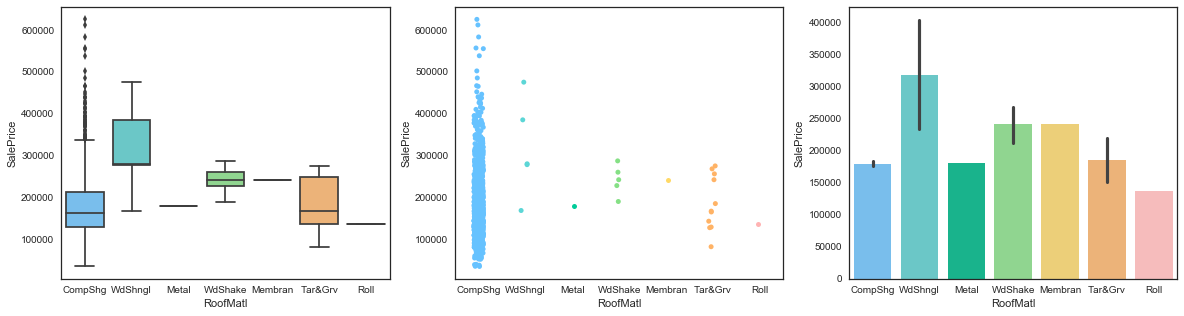

In [257]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="RoofMatl", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="RoofMatl", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="RoofMatl", y="SalePrice", data=train, palette = mycols);

- Interestingly, there are very few observations in the training data for several classes. However, these will be dropped during feature reduction if they turn out to be insignificant.
- Hence, I will create dummy variables.

In [258]:
all_data = pd.get_dummies(all_data, columns = ["RoofMatl"], prefix="RoofMatl")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical        ...         RoofStyle_Hip  \
0       Norm       Norm      SBrkr        ...                     0   
1      Feedr       Norm      SBrkr        ...                     0   
2       Norm       Norm      SBrkr        ...                     0   

  RoofStyle_Mansard RoofStyle_Shed RoofMatl_CompShg RoofMatl_Membran  \
0                 0              0                1                0   
1                 0              0                1                0   
2                 0              0                1                0   

  RoofMatl_Metal  RoofMatl_Roll  RoofMatl_Tar&Grv  RoofMatl_WdShake  \
0              0              0                 0                 0   
1              0              0                 0                 0   
2              0              0                 0                 0   

   RoofMatl_WdShngl  
0                 0  
1                 0  
2                 0  

[3 rows x 205 columns]

***Exterior1st*** & ***Exterior2nd***
- Exterior covering on house.

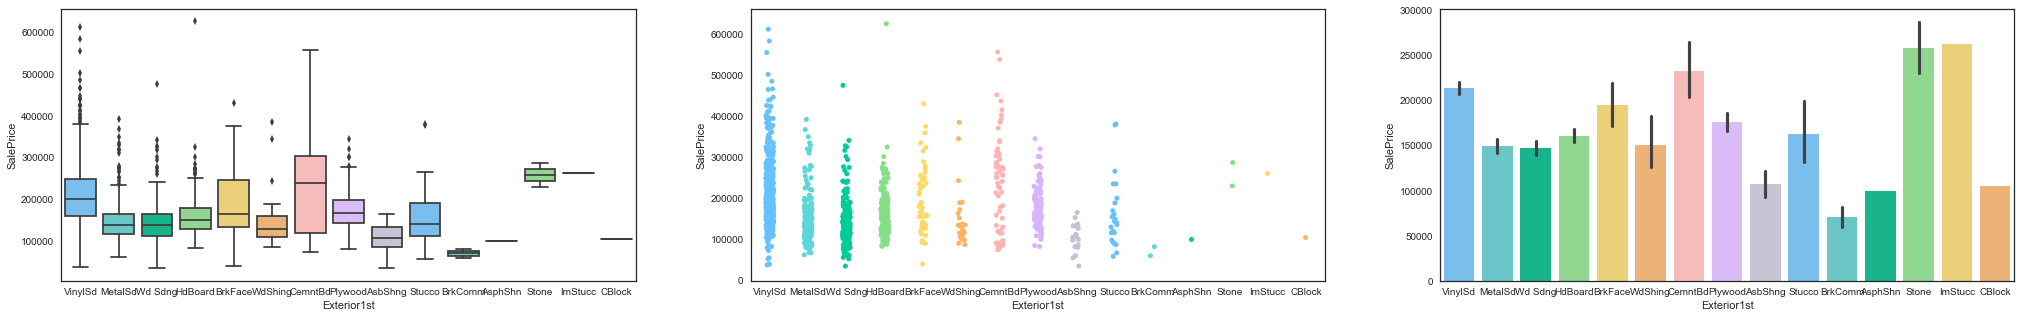

In [259]:
plt.subplots(figsize =(35, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Exterior1st", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="Exterior1st", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Exterior1st", y="SalePrice", data=train, palette = mycols);

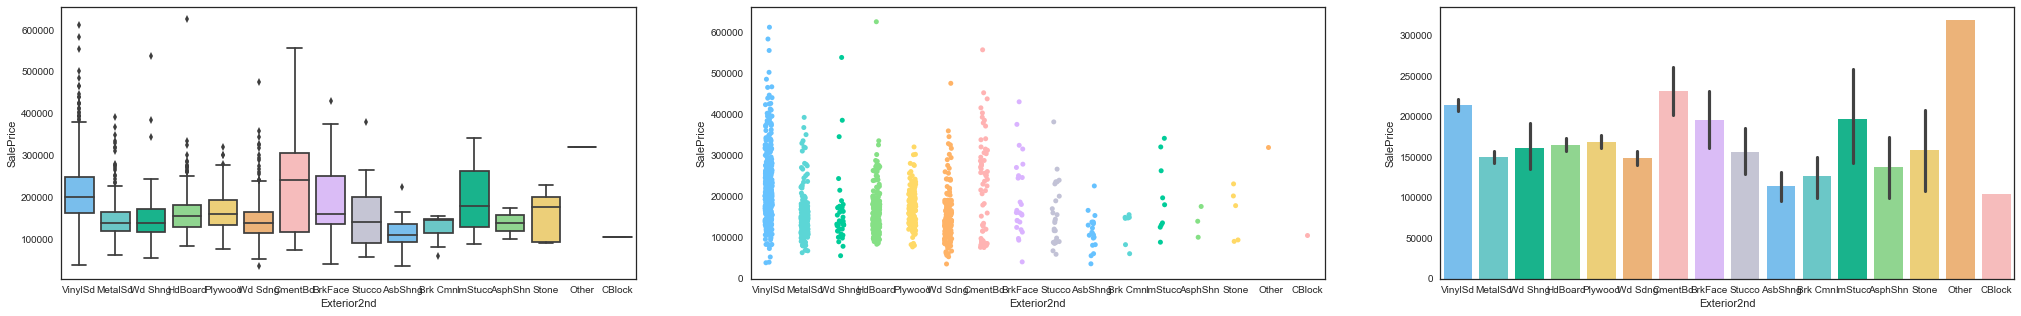

In [260]:
plt.subplots(figsize =(35, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Exterior2nd", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="Exterior2nd", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Exterior2nd", y="SalePrice", data=train, palette = mycols);

- Looking at these 2 features together, we can see that they exhibit very similar behaviours against SalePrice. This tells me that they are very closely related. 
- Hence, I will create a flag to indicate whether there is a different 2nd exterior covering to the first.
- Then I will keep "Exterior1st" and create dummy variables from this.

In [261]:
def Exter2(col):
    if col['Exterior2nd'] == col['Exterior1st']:
        return 1
    else:
        return 0
    
all_data['ExteriorMatch_Flag'] = all_data.apply(Exter2, axis=1)
all_data.drop('Exterior2nd', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["Exterior1st"], prefix="Exterior1st")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical         ...          Exterior1st_CemntBd  \
0       Norm       Norm      SBrkr         ...                            0   
1      Feedr       Norm      SBrkr         ...                            0   
2       Norm       Norm      SBrkr         ...                            0   

  Exterior1st_HdBoard Exterior1st_ImStucc Exterior1st_MetalSd  \
0                   0                   0                   0   
1                   0                   0                   1   
2                   0                   0                   0   

   Exterior1st_Plywood  Exterior1st_Stone  Exterior1st_Stucco  \
0                    0                  0                   0   
1                    0                  0                   0   
2                    0                  0                   0   

   Exterior1st_VinylSd  Exterior1st_Wd Sdng Exterior1st_WdShing  
0                    1                    0                   0  
1                    0                    0                   0  
2                    1                    0                   0  

[3 rows x 219 columns]

***MasVnrType***
- Masonry veneer type.

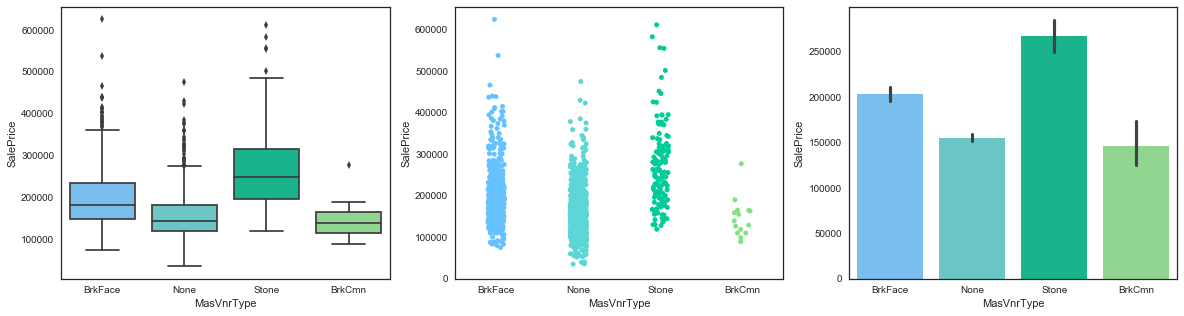

In [262]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MasVnrType", y="SalePrice", data=train, palette = mycols);

plt.subplot(1, 3, 2)
sns.stripplot(x="MasVnrType", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MasVnrType", y="SalePrice", data=train, palette = mycols);

- Each class has quite a unique range of values for SalePrice, the only class that stands out is "BrkCmn", which has a low frequency.
- Clearly "Stone" demands the highest SalePrice on average, although there are some extreme values within "BrkFace".
- Since this is a categorical feature without order, I will create dummy variables here.

In [263]:
all_data = pd.get_dummies(all_data, columns = ["MasVnrType"], prefix="MasVnrType")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...         Exterior1st_Plywood  \
0       Norm       Norm      SBrkr       ...                           0   
1      Feedr       Norm      SBrkr       ...                           0   
2       Norm       Norm      SBrkr       ...                           0   

  Exterior1st_Stone Exterior1st_Stucco Exterior1st_VinylSd  \
0                 0                  0                   1   
1                 0                  0                   0   
2                 0                  0                   1   

   Exterior1st_Wd Sdng  Exterior1st_WdShing  MasVnrType_BrkCmn  \
0                    0                    0                  0   
1                    0                    0                  0   
2                    0                    0                  0   

   MasVnrType_BrkFace  MasVnrType_None MasVnrType_Stone  
0                   1                0                0  
1                   0                1                0  
2                   1                0                0  

[3 rows x 222 columns]

***MasVnrArea***
- Masonry veneer area in square feet.

D:\Anaconda2\envs\py3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


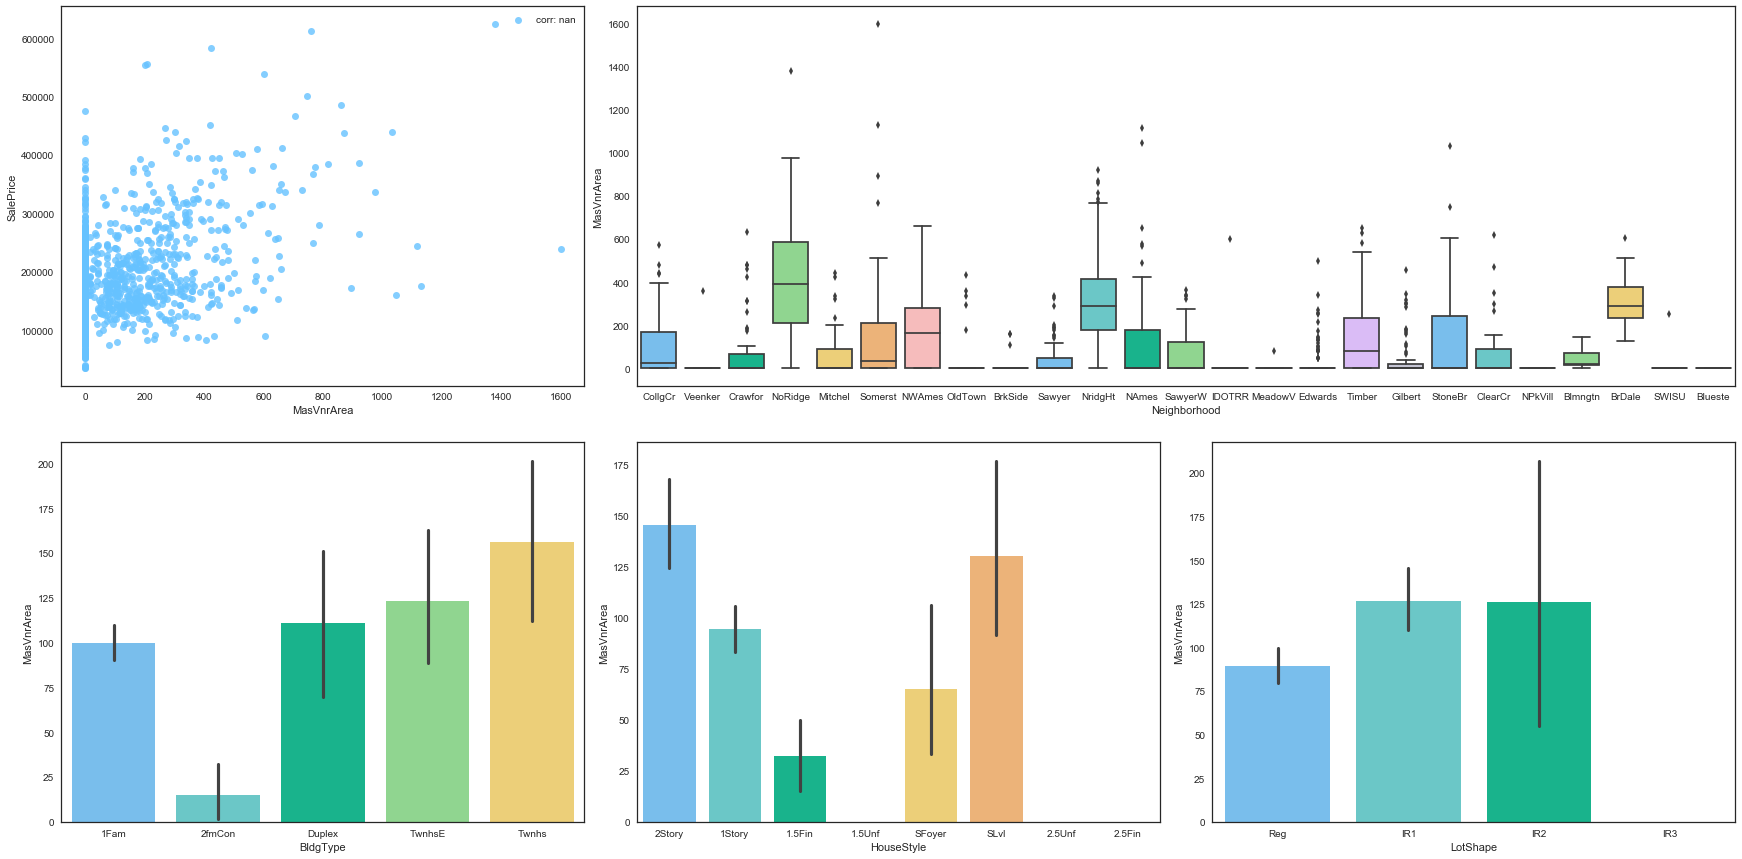

In [264]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['MasVnrArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['MasVnrArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="MasVnrArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="MasVnrArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="MasVnrArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="MasVnrArea", data=train, palette = mycols);

- From this we can see that this feature has negligible correlation with SalePrice, and the values for this feature vary widely based on house type, style and size. 
- Since this feature is insignificant in regards to SalePrice, and it also correlates highly with "MasVnrType" (if "MasVnrType = "None" then it has to be equal to 0), I will drop this feature.

In [265]:
all_data.drop('MasVnrArea', axis=1, inplace=True)

***ExterQual***
- Evaluates the quality of the material on the exterior.

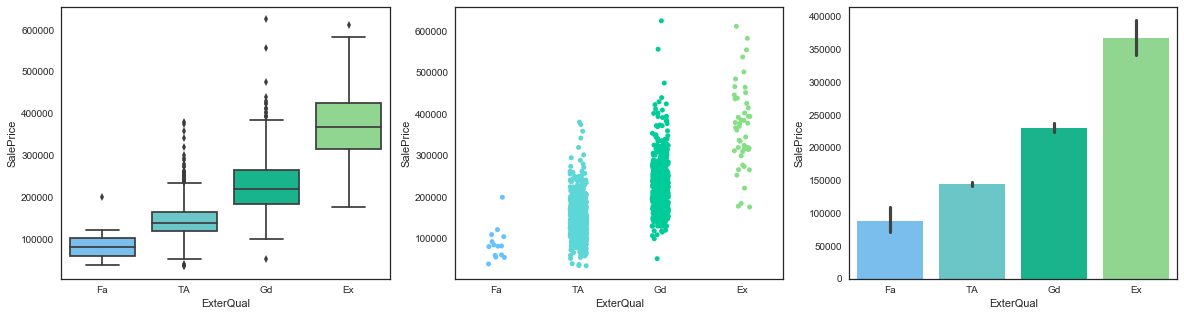

In [266]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="ExterQual", y="SalePrice", data=train, order=['Fa','TA','Gd', 'Ex'], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="ExterQual", y="SalePrice", data=train, size = 5, jitter = True, order=['Fa','TA','Gd', 'Ex'], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="ExterQual", y="SalePrice", data=train, order=['Fa','TA','Gd', 'Ex'], palette = mycols);

- We can see here that this feature shows a clear order and has a positive correlation with SalePrice. As the quality increases, so does the SalePrice. 
- We see the largest number of observations within the two middle classes, and the lowest observations within the lowest class.
- Since this is a categorical feature with order, I will replace these values by hand.

In [267]:
all_data['ExterQual'] = all_data['ExterQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
all_data['ExterQual'].unique()

array([3, 2, 4, 1], dtype=int64)

***ExterCond***
- Evaluates the present condition of the material on the exterior. 

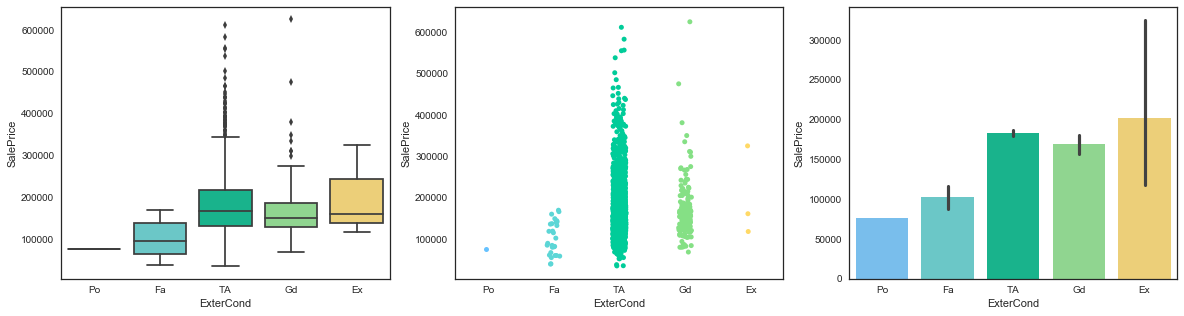

In [268]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="ExterCond", y="SalePrice", data=train, order=['Po','Fa','TA','Gd', 'Ex'], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="ExterCond", y="SalePrice", data=train, size = 5, jitter = True, order=['Po','Fa','TA','Gd', 'Ex'], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="ExterCond", y="SalePrice", data=train, order=['Po','Fa','TA','Gd', 'Ex'], palette = mycols);

- Interestingly we see the largest values of SalePrice for the second and third best classes. This is perhaps because of the large frequency of values within these classes, whereas we only see 3 observations within "Ex" from the training data.
- Since this categorical feature has an order, but thr SalePrice does not necessarily correlate with this order... I will create dummy variables.

In [269]:
all_data = pd.get_dummies(all_data, columns = ["ExterCond"], prefix="ExterCond")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical     ...       Exterior1st_WdShing  \
0       Norm       Norm      SBrkr     ...                         0   
1      Feedr       Norm      SBrkr     ...                         0   
2       Norm       Norm      SBrkr     ...                         0   

   MasVnrType_BrkCmn MasVnrType_BrkFace  MasVnrType_None  MasVnrType_Stone  \
0                  0                  1                0                 0   
1                  0                  0                1                 0   
2                  0                  1                0                 0   

   ExterCond_Ex  ExterCond_Fa  ExterCond_Gd ExterCond_Po ExterCond_TA  
0             0             0             0            0            1  
1             0             0             0            0            1  
2             0             0             0            0            1  

[3 rows x 225 columns]

***GarageType***
- Garage location.

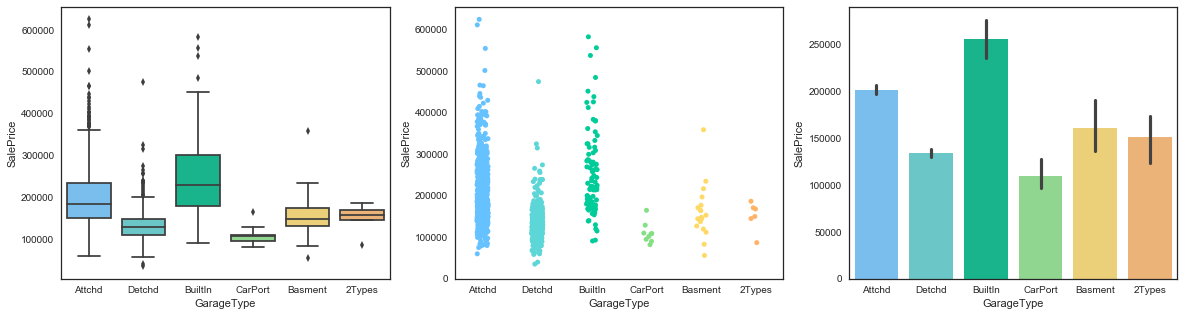

In [270]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageType", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageType", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageType", y="SalePrice", data=train, palette = mycols);

- Here we see "BuiltIn" and "Attched" having the 2 highest average SalePrices, with only a few extreme values within each class.
- Since this is categorical without order, I will create dummy variables.

In [271]:
all_data = pd.get_dummies(all_data, columns = ["GarageType"], prefix="GarageType")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...        ExterCond_Gd  \
0       Norm       Norm      SBrkr       ...                   0   
1      Feedr       Norm      SBrkr       ...                   0   
2       Norm       Norm      SBrkr       ...                   0   

   ExterCond_Po ExterCond_TA  GarageType_2Types  GarageType_Attchd  \
0             0            1                  0                  1   
1             0            1                  0                  1   
2             0            1                  0                  1   

   GarageType_Basment  GarageType_BuiltIn  GarageType_CarPort  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   

  GarageType_Detchd GarageType_None  
0                 0               0  
1                 0               0  
2                 0               0  

[3 rows x 231 columns]

***GarageYrBlt***
- Year garage was built.

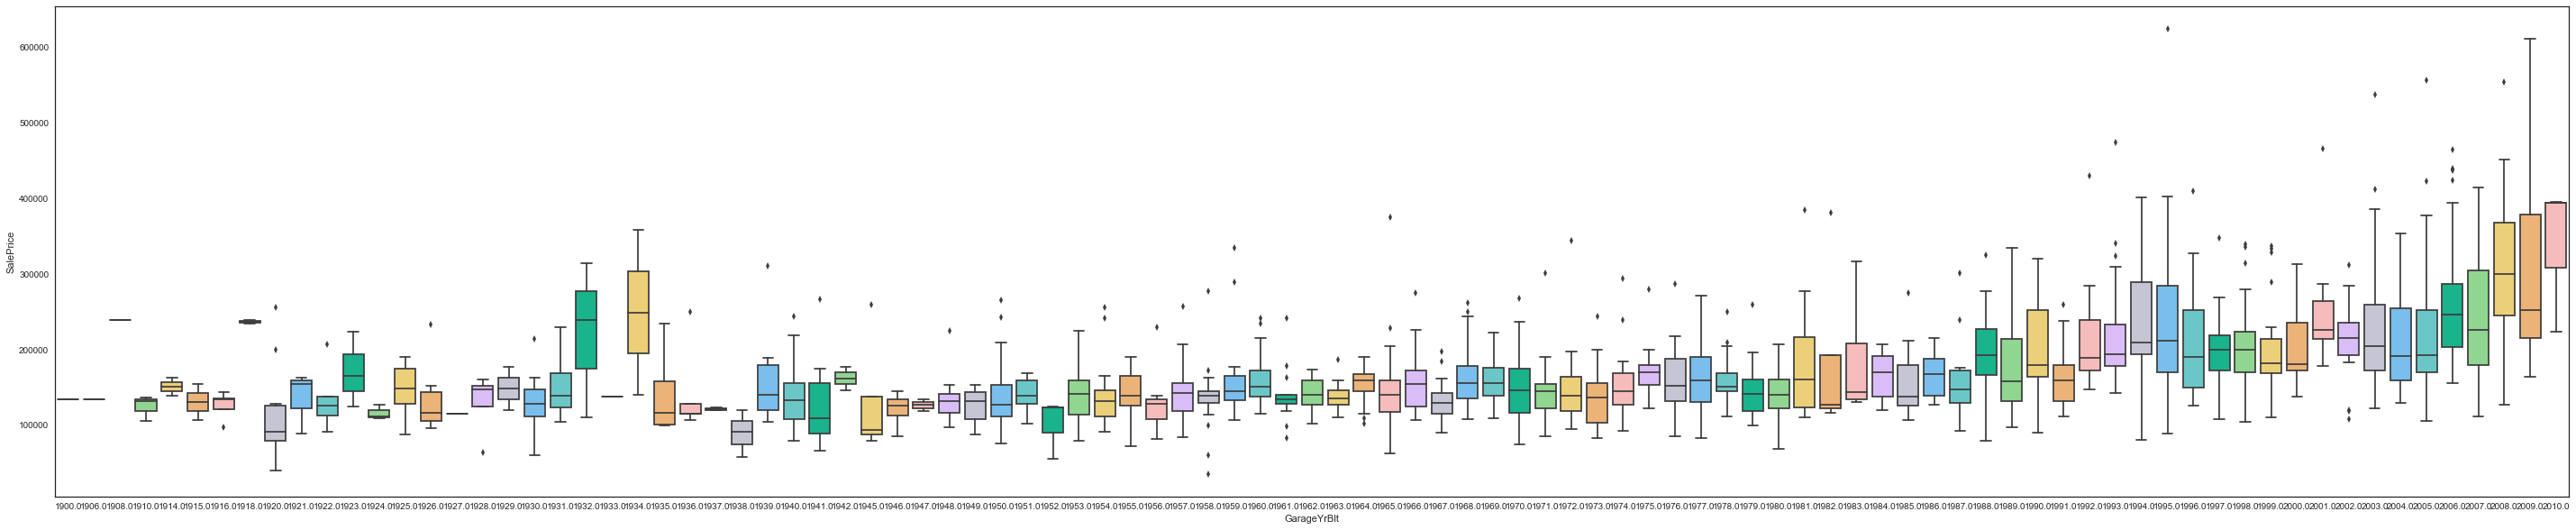

In [272]:
plt.subplots(figsize =(50, 10))

sns.boxplot(x="GarageYrBlt", y="SalePrice", data=train, palette = mycols);

- We can see a slight upward trend as the garage building year becomes more modern.
- For this feature I am going to create bins and the dummy variables.

In [273]:
all_data['GarageYrBlt_Band'] = pd.qcut(all_data['GarageYrBlt'], 3)
all_data['GarageYrBlt_Band'].unique()

[(1996.0, 2207.0], (1964.0, 1996.0], (-0.001, 1964.0]]
Categories (3, interval[float64]): [(-0.001, 1964.0] < (1964.0, 1996.0] < (1996.0, 2207.0]]

In [274]:
all_data.loc[all_data['GarageYrBlt']<=1964, 'GarageYrBlt'] = 1
all_data.loc[(all_data['GarageYrBlt']>1964) & (all_data['GarageYrBlt']<=1996), 'GarageYrBlt'] = 2
all_data.loc[all_data['GarageYrBlt']>1996, 'GarageYrBlt'] = 3
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(int)

all_data.drop('GarageYrBlt_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GarageYrBlt"], prefix="GarageYrBlt")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical      ...       GarageType_2Types  \
0       Norm       Norm      SBrkr      ...                       0   
1      Feedr       Norm      SBrkr      ...                       0   
2       Norm       Norm      SBrkr      ...                       0   

   GarageType_Attchd GarageType_Basment  GarageType_BuiltIn  \
0                  1                  0                   0   
1                  1                  0                   0   
2                  1                  0                   0   

   GarageType_CarPort  GarageType_Detchd  GarageType_None  GarageYrBlt_1  \
0                   0                  0                0              0   
1                   0                  0                0              0   
2                   0                  0                0              0   

  GarageYrBlt_2 GarageYrBlt_3  
0             0             1  
1             1             0  
2             0             1  

[3 rows x 233 columns]

***GarageFinish***
- Interior finish of the garage.

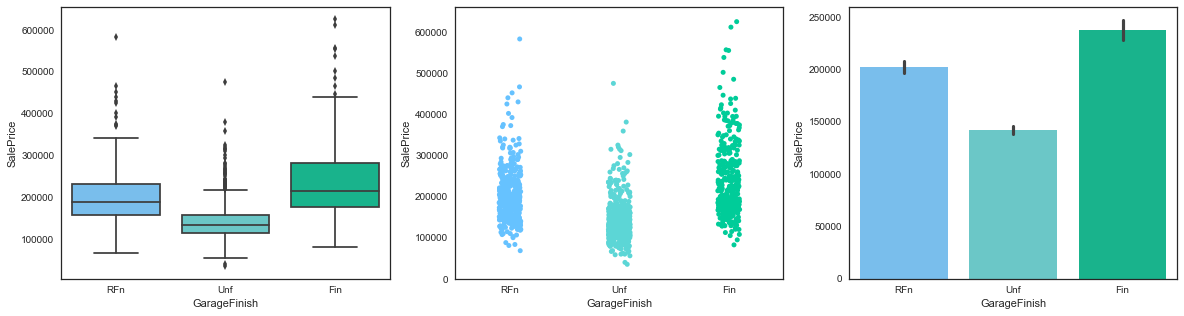

In [275]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageFinish", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageFinish", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageFinish", y="SalePrice", data=train, palette = mycols);

- Here we see a nice split between the 3 classes, with "Fin" producing the highest SalePrice's on average.
- I will create dummy variables for this feature.

In [276]:
all_data = pd.get_dummies(all_data, columns = ["GarageFinish"], prefix="GarageFinish")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...         GarageType_CarPort  \
0       Norm       Norm      SBrkr       ...                          0   
1      Feedr       Norm      SBrkr       ...                          0   
2       Norm       Norm      SBrkr       ...                          0   

   GarageType_Detchd GarageType_None  GarageYrBlt_1  GarageYrBlt_2  \
0                  0               0              0              0   
1                  0               0              0              1   
2                  0               0              0              0   

   GarageYrBlt_3  GarageFinish_Fin  GarageFinish_None GarageFinish_RFn  \
0              1                 0                  0                1   
1              0                 0                  0                1   
2              1                 0                  0                1   

  GarageFinish_Unf  
0                0  
1                0  
2                0  

[3 rows x 236 columns]

***GarageCars***
- Size of the garage in car capacity.

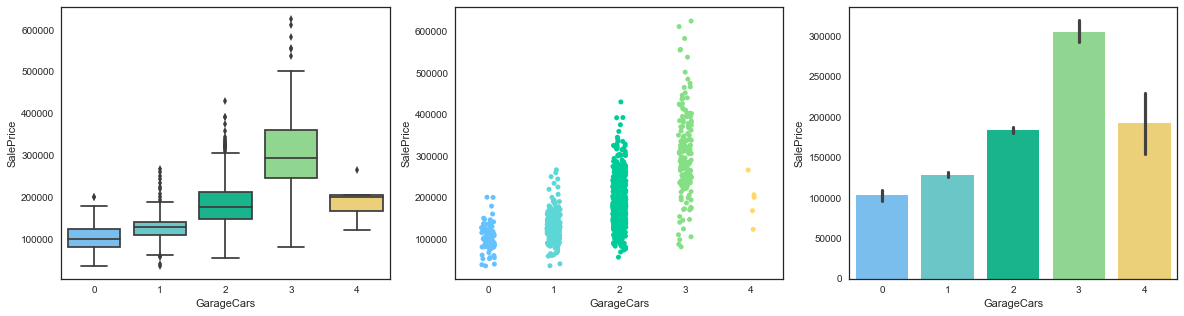

In [277]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageCars", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageCars", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageCars", y="SalePrice", data=train, palette = mycols);

- We generally see a positive correlation with an increasing garage car capacity. However, we see a slight dip for 4 cars I believe due to the low frequency of houses with a 4 car garage.

***GarageArea***
- Size of the garage in square feet.

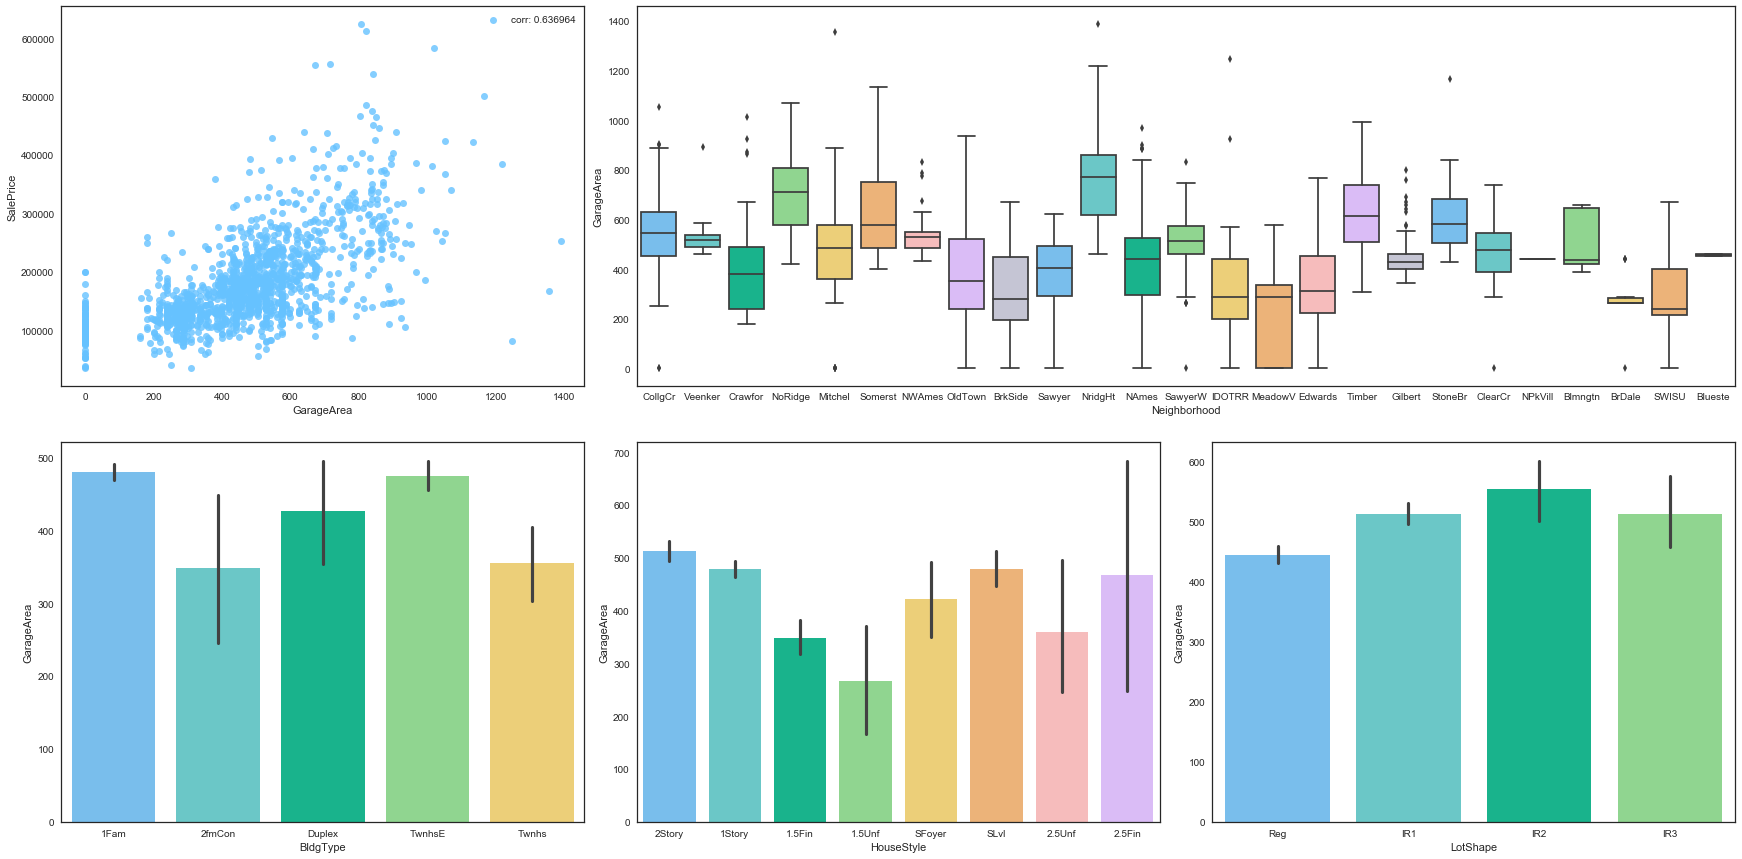

In [278]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['GarageArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['GarageArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="GarageArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="GarageArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="GarageArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="GarageArea", data=train, palette = mycols);

- This has an extremely high positive correlation with SalePrice, and it is highly dependant on Neighborhood, building type and style of the house.
- This could be an important feature in the analysis, so I will bin this feature and create dummy variables.

In [279]:
all_data['GarageArea_Band'] = pd.cut(all_data['GarageArea'], 3)
all_data['GarageArea_Band'].unique()

[(496.0, 992.0], (-1.488, 496.0], (992.0, 1488.0]]
Categories (3, interval[float64]): [(-1.488, 496.0] < (496.0, 992.0] < (992.0, 1488.0]]

In [280]:
all_data.loc[all_data['GarageArea']<=496, 'GarageArea'] = 1
all_data.loc[(all_data['GarageArea']>496) & (all_data['GarageArea']<=992), 'GarageArea'] = 2
all_data.loc[all_data['GarageArea']>992, 'GarageArea'] = 3
all_data['GarageArea'] = all_data['GarageArea'].astype(int)

all_data.drop('GarageArea_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["GarageArea"], prefix="GarageArea")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical     ...       GarageYrBlt_1  GarageYrBlt_2  \
0       Norm       Norm      SBrkr     ...                   0              0   
1      Feedr       Norm      SBrkr     ...                   0              1   
2       Norm       Norm      SBrkr     ...                   0              0   

  GarageYrBlt_3  GarageFinish_Fin  GarageFinish_None  GarageFinish_RFn  \
0             1                 0                  0                 1   
1             0                 0                  0                 1   
2             1                 0                  0                 1   

   GarageFinish_Unf GarageArea_1 GarageArea_2 GarageArea_3  
0                 0            0            1            0  
1                 0            1            0            0  
2                 0            0            1            0  

[3 rows x 238 columns]

***GarageQual***
- Garage quality.

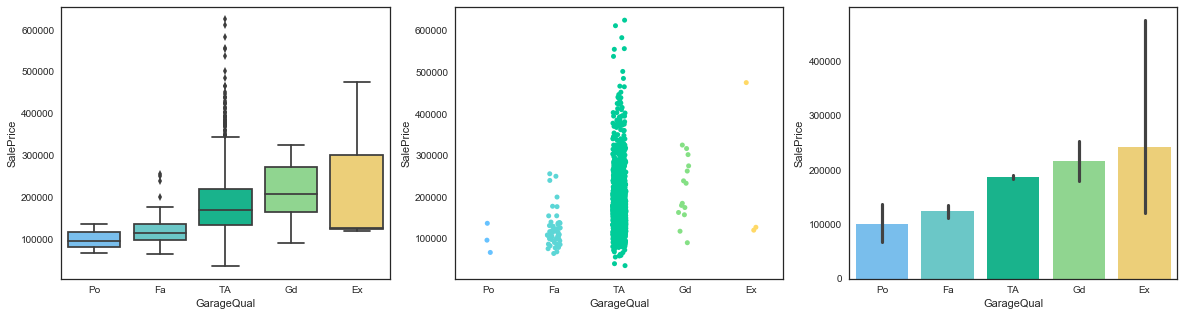

In [281]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageQual", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageQual", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageQual", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

- We see a lot of homes having "TA" quality garages, with very few homes having high quality and low quality ones.
- I am going to cluster the classes here, and then create dummy variables.

In [282]:
all_data['GarageQual'] = all_data['GarageQual'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
all_data['GarageQual'].unique()

array(['TA', 'Low', 'High', 'None'], dtype=object)

In [283]:
all_data = pd.get_dummies(all_data, columns = ["GarageQual"], prefix="GarageQual")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical      ...       GarageFinish_None  \
0       Norm       Norm      SBrkr      ...                       0   
1      Feedr       Norm      SBrkr      ...                       0   
2       Norm       Norm      SBrkr      ...                       0   

   GarageFinish_RFn GarageFinish_Unf  GarageArea_1  GarageArea_2  \
0                 1                0             0             1   
1                 1                0             1             0   
2                 1                0             0             1   

   GarageArea_3  GarageQual_High GarageQual_Low GarageQual_None GarageQual_TA  
0             0                0              0               0             1  
1             0                0              0               0             1  
2             0                0              0               0             1  

[3 rows x 241 columns]

***GarageCond***
- Garage condition.

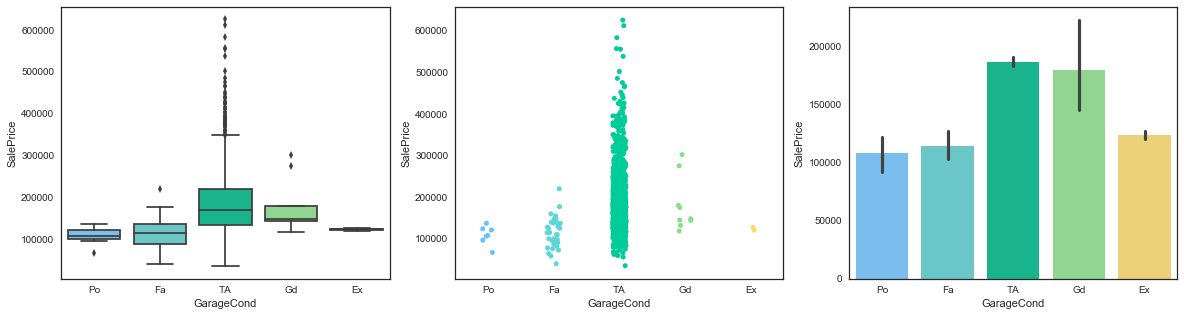

In [284]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="GarageCond", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="GarageCond", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="GarageCond", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

- We see a fairly similar pattern here with the previous feature. We see a slight positive correlation and then a dip, I believe due to the low number of houses that have "Ex" or "Gd" garage conditions. 
- Similarly to before, I am going to cluster and then dummy this feature.

In [285]:
all_data['GarageCond'] = all_data['GarageCond'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
all_data['GarageCond'].unique()

array(['TA', 'Low', 'None', 'High'], dtype=object)

In [286]:
all_data = pd.get_dummies(all_data, columns = ["GarageCond"], prefix="GarageCond")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical      ...        GarageArea_2  GarageArea_3  \
0       Norm       Norm      SBrkr      ...                   1             0   
1      Feedr       Norm      SBrkr      ...                   0             0   
2       Norm       Norm      SBrkr      ...                   1             0   

  GarageQual_High  GarageQual_Low  GarageQual_None  GarageQual_TA  \
0               0               0                0              1   
1               0               0                0              1   
2               0               0                0              1   

   GarageCond_High GarageCond_Low GarageCond_None  GarageCond_TA  
0                0              0               0              1  
1                0              0               0              1  
2                0              0               0              1  

[3 rows x 244 columns]

***WoodDeckSF***
- Wood deck area in SF.

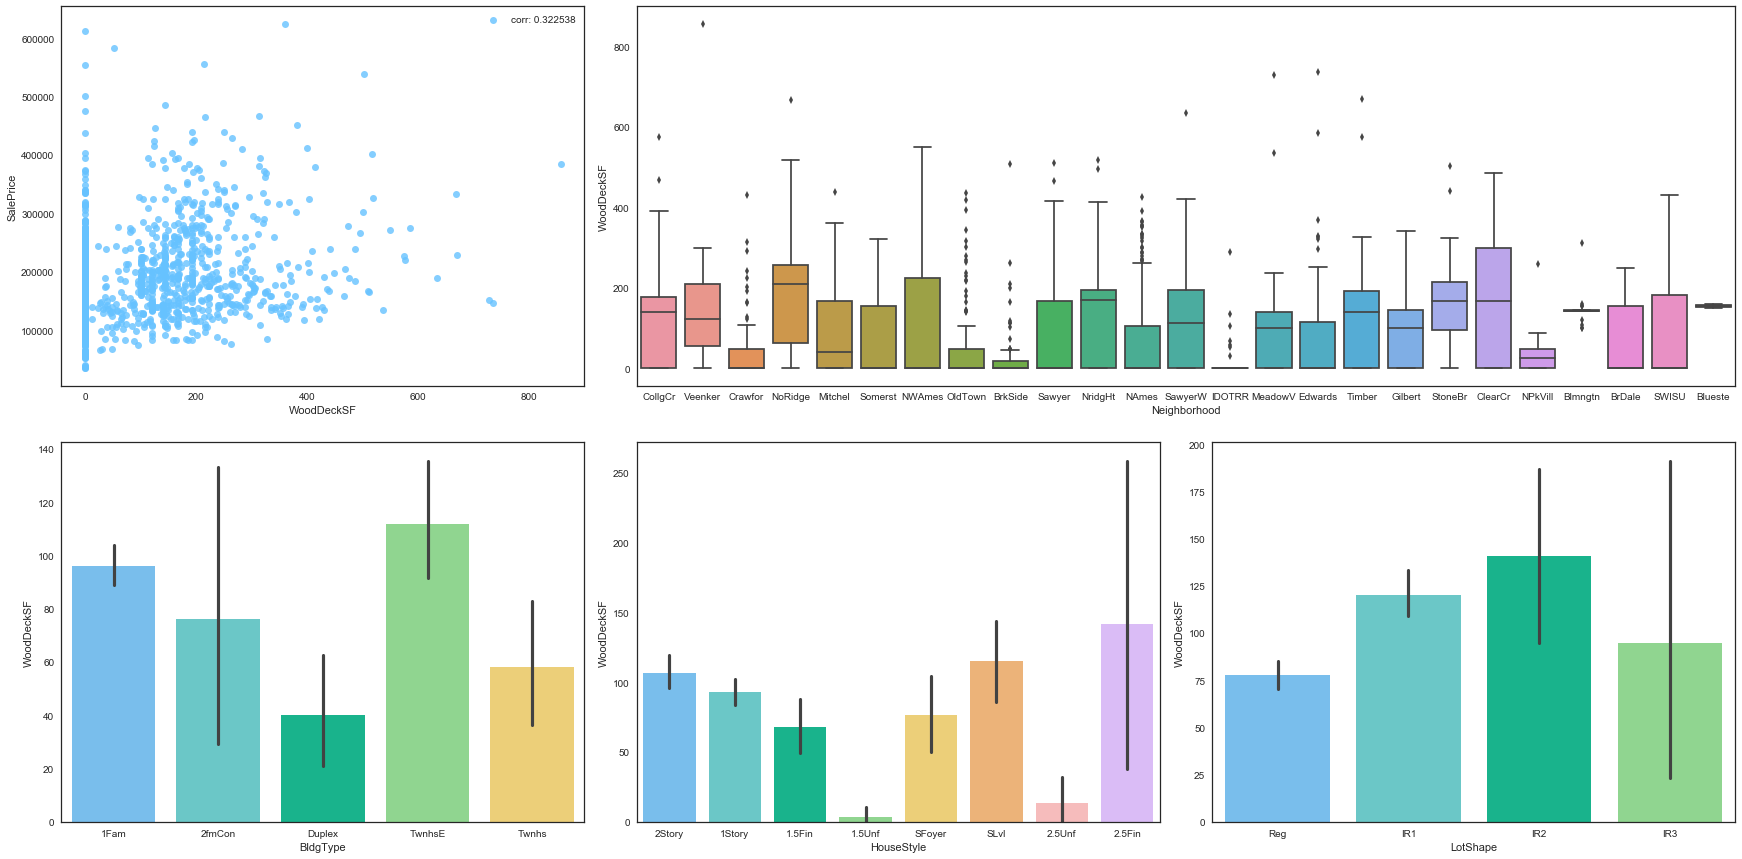

In [287]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['WoodDeckSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['WoodDeckSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="WoodDeckSF", data=train)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="WoodDeckSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="WoodDeckSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="WoodDeckSF", data=train, palette = mycols);

- This feature has a high positive correlation with SalePrice.
- We can also see that it varies widely with location, building type, style and size of the lot.
- There is a significant number of data points with a value of 0, so I will create a flag to indicate no Wood Deck. Then, since this is a continuous numeric feature, and I believe it to be an important one, I will bin this and then create dummy features. 

In [288]:
def WoodDeckFlag(col):
    if col['WoodDeckSF'] == 0:
        return 1
    else:
        return 0
    
all_data['NoWoodDeck_Flag'] = all_data.apply(WoodDeckFlag, axis=1)

all_data['WoodDeckSF_Band'] = pd.cut(all_data['WoodDeckSF'], 4)

all_data.loc[all_data['WoodDeckSF']<=356, 'WoodDeckSF'] = 1
all_data.loc[(all_data['WoodDeckSF']>356) & (all_data['WoodDeckSF']<=712), 'WoodDeckSF'] = 2
all_data.loc[(all_data['WoodDeckSF']>712) & (all_data['WoodDeckSF']<=1068), 'WoodDeckSF'] = 3
all_data.loc[all_data['WoodDeckSF']>1068, 'WoodDeckSF'] = 4
all_data['WoodDeckSF'] = all_data['WoodDeckSF'].astype(int)

all_data.drop('WoodDeckSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["WoodDeckSF"], prefix="WoodDeckSF")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical      ...       GarageQual_TA  \
0       Norm       Norm      SBrkr      ...                   1   
1      Feedr       Norm      SBrkr      ...                   1   
2       Norm       Norm      SBrkr      ...                   1   

   GarageCond_High GarageCond_Low  GarageCond_None  GarageCond_TA  \
0                0              0                0              1   
1                0              0                0              1   
2                0              0                0              1   

   NoWoodDeck_Flag  WoodDeckSF_1 WoodDeckSF_2 WoodDeckSF_3  WoodDeckSF_4  
0                1             1            0            0             0  
1                0             1            0            0             0  
2                1             1            0            0             0  

[3 rows x 248 columns]

***OpenPorchSF***, ***EnclosedPorch***, ***3SsnPorch*** & ***ScreenPorch***
- I will sum these features together to create a total porch in square feet feature. 

In [289]:
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch'] 
train['TotalPorchSF'] = train['OpenPorchSF'] + train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']

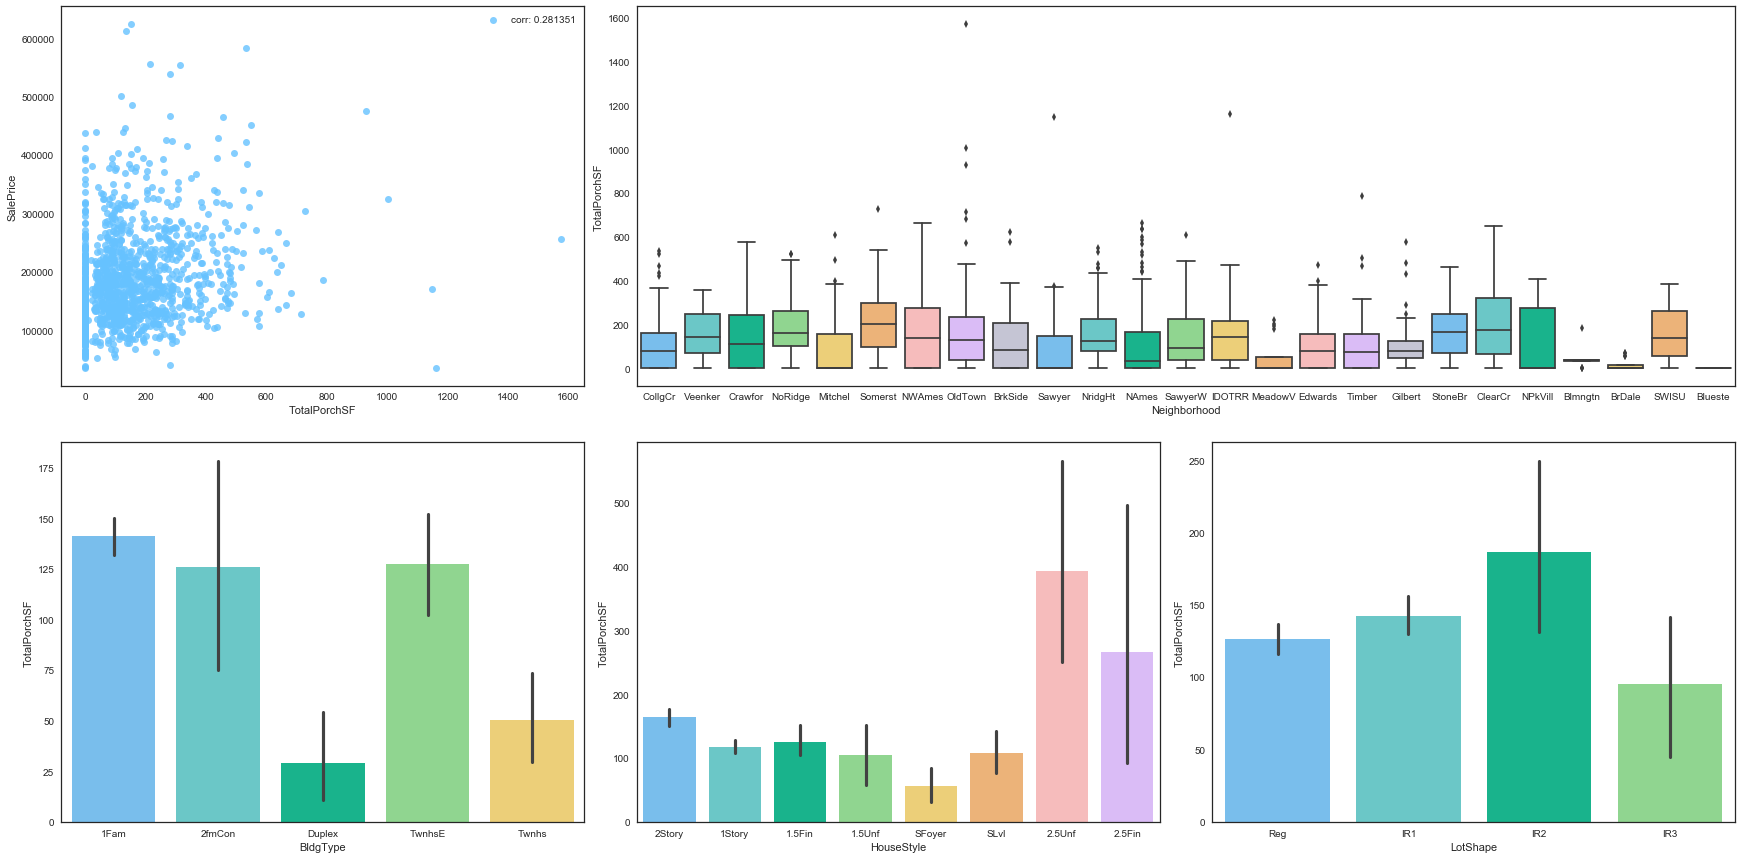

In [290]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['TotalPorchSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['TotalPorchSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="TotalPorchSF", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="TotalPorchSF", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="TotalPorchSF", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="TotalPorchSF", data=train, palette = mycols);

- We can see a high number of data points having a value of 0 here once again.
- Apart from this, we see a high positive correlation with SalePrice showing that this may be an influential factor for analysis.
- Finally, we see that this value ranges widely based on location, building type, style and lot.
- I will create a flag to indicate no open porch, then I will bin the feature and create dummy variables.

In [291]:
def PorchFlag(col):
    if col['TotalPorchSF'] == 0:
        return 1
    else:
        return 0
    
all_data['NoPorch_Flag'] = all_data.apply(PorchFlag, axis=1)

all_data['TotalPorchSF_Band'] = pd.cut(all_data['TotalPorchSF'], 4)
all_data['TotalPorchSF_Band'].unique()

[(-1.724, 431.0], (431.0, 862.0], (862.0, 1293.0], (1293.0, 1724.0]]
Categories (4, interval[float64]): [(-1.724, 431.0] < (431.0, 862.0] < (862.0, 1293.0] < (1293.0, 1724.0]]

In [292]:
all_data.loc[all_data['TotalPorchSF']<=431, 'TotalPorchSF'] = 1
all_data.loc[(all_data['TotalPorchSF']>431) & (all_data['TotalPorchSF']<=862), 'TotalPorchSF'] = 2
all_data.loc[(all_data['TotalPorchSF']>862) & (all_data['TotalPorchSF']<=1293), 'TotalPorchSF'] = 3
all_data.loc[all_data['TotalPorchSF']>1293, 'TotalPorchSF'] = 4
all_data['TotalPorchSF'] = all_data['TotalPorchSF'].astype(int)

all_data.drop('TotalPorchSF_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["TotalPorchSF"], prefix="TotalPorchSF")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical       ...        NoWoodDeck_Flag  \
0       Norm       Norm      SBrkr       ...                      1   
1      Feedr       Norm      SBrkr       ...                      0   
2       Norm       Norm      SBrkr       ...                      1   

   WoodDeckSF_1 WoodDeckSF_2  WoodDeckSF_3  WoodDeckSF_4  NoPorch_Flag  \
0             1            0             0             0             0   
1             1            0             0             0             1   
2             1            0             0             0             0   

   TotalPorchSF_1 TotalPorchSF_2 TotalPorchSF_3  TotalPorchSF_4  
0               1              0              0               0  
1               1              0              0               0  
2               1              0              0               0  

[3 rows x 253 columns]

***PoolArea***
- Pool area in square feet. 

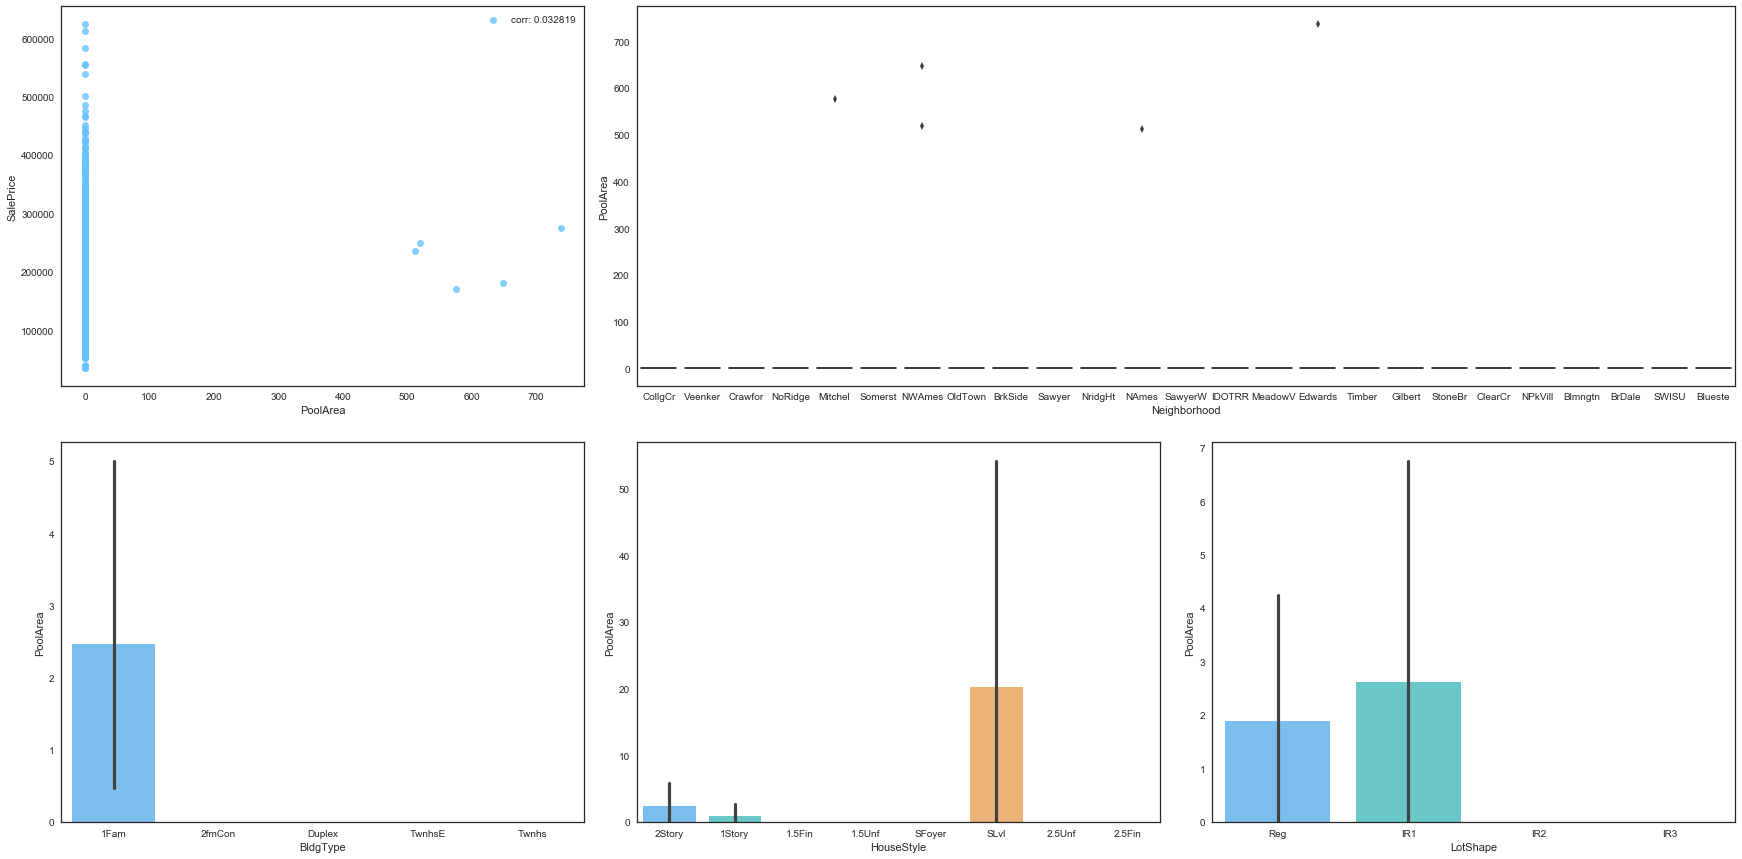

In [293]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['PoolArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['PoolArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="PoolArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="PoolArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="PoolArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="PoolArea", data=train, palette = mycols);

- We see almost 0 correlation due to the high number of houses without a pool.
- Hence, I will create a flag here.

In [294]:
def PoolFlag(col):
    if col['PoolArea'] == 0:
        return 0
    else:
        return 1
    
all_data['HasPool_Flag'] = all_data.apply(PoolFlag, axis=1)
all_data.drop('PoolArea', axis=1, inplace=True)

***PoolQC***
- Pool quality.

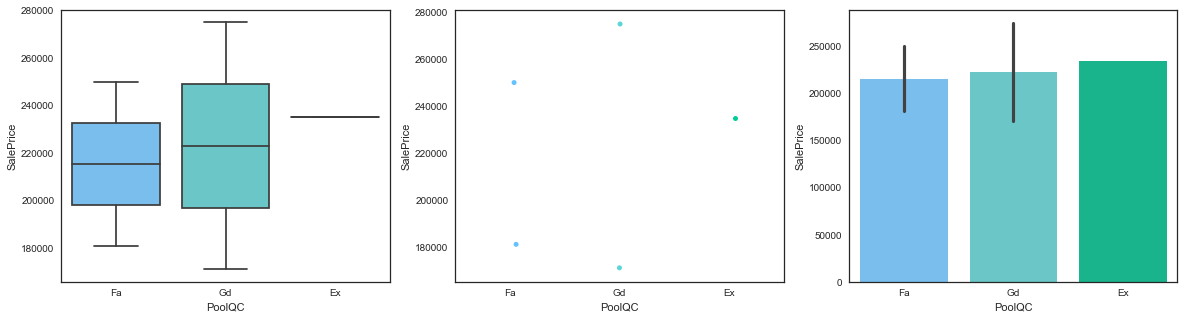

In [295]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="PoolQC", y="SalePrice", data=train, order=["Fa", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="PoolQC", y="SalePrice", data=train, size = 5, jitter = True, order=["Fa", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="PoolQC", y="SalePrice", data=train, order=["Fa", "Gd", "Ex"], palette = mycols);

- Due to not many houses having a pool, we see very low numbers of observations for each class.
- Since this does not hold much information this feature, I will simply remove it.

In [296]:
all_data.drop('PoolQC', axis=1, inplace=True)

***Fence***
- Fence quality.

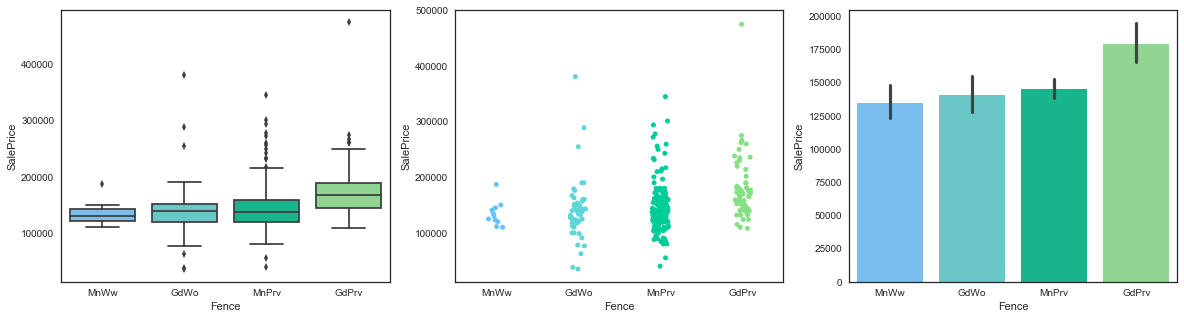

In [297]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Fence", y="SalePrice", data=train, order = ["MnWw", "GdWo", "MnPrv", "GdPrv"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Fence", y="SalePrice", data=train, size = 5, jitter = True, order = ["MnWw", "GdWo", "MnPrv", "GdPrv"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Fence", y="SalePrice", data=train, order = ["MnWw", "GdWo", "MnPrv", "GdPrv"], palette = mycols);

- Here we see that the houses with the most privacy have the highest average SalePrice.
- There seems to be a slight order within the classes, however some of the class descriptions are slightly ambiguous, therefore I will create dummy variables here from this categorical feature. 

In [298]:
all_data = pd.get_dummies(all_data, columns = ["Fence"], prefix="Fence")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical     ...      TotalPorchSF_1  \
0       Norm       Norm      SBrkr     ...                   1   
1      Feedr       Norm      SBrkr     ...                   1   
2       Norm       Norm      SBrkr     ...                   1   

   TotalPorchSF_2  TotalPorchSF_3  TotalPorchSF_4  HasPool_Flag  Fence_GdPrv  \
0               0               0               0             0            0   
1               0               0               0             0            0   
2               0               0               0             0            0   

  Fence_GdWo Fence_MnPrv  Fence_MnWw  Fence_None  
0          0           0           0           1  
1          0           0           0           1  
2          0           0           0           1  

[3 rows x 256 columns]

<a id='location'></a>
#### 4.2.5 - Location

***MSZoning***
- Identifies the general zoning classification of the sale. 

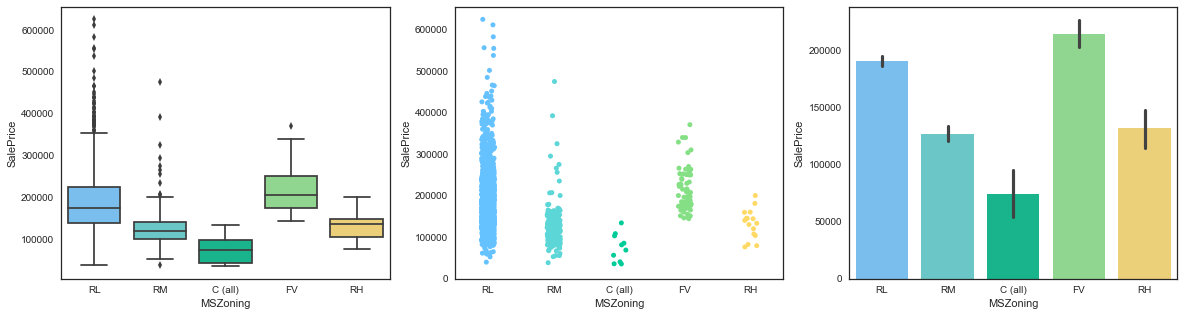

In [299]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MSZoning", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="MSZoning", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MSZoning", y="SalePrice", data=train, palette = mycols);

- Since this a categorical feature without order, and each of the classes has a very different range and average for SalePrice, I will create dummy features here.

In [300]:
all_data = pd.get_dummies(all_data, columns = ["MSZoning"], prefix="MSZoning")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical     ...       Fence_GdPrv  Fence_GdWo  \
0       Norm       Norm      SBrkr     ...                 0           0   
1      Feedr       Norm      SBrkr     ...                 0           0   
2       Norm       Norm      SBrkr     ...                 0           0   

   Fence_MnPrv  Fence_MnWw  Fence_None  MSZoning_C (all) MSZoning_FV  \
0            0           0           1                 0           0   
1            0           0           1                 0           0   
2            0           0           1                 0           0   

  MSZoning_RH  MSZoning_RL  MSZoning_RM  
0           0            1            0  
1           0            1            0  
2           0            1            0  

[3 rows x 260 columns]

***Neighborhood***
- Physical locations within Ames city limits.

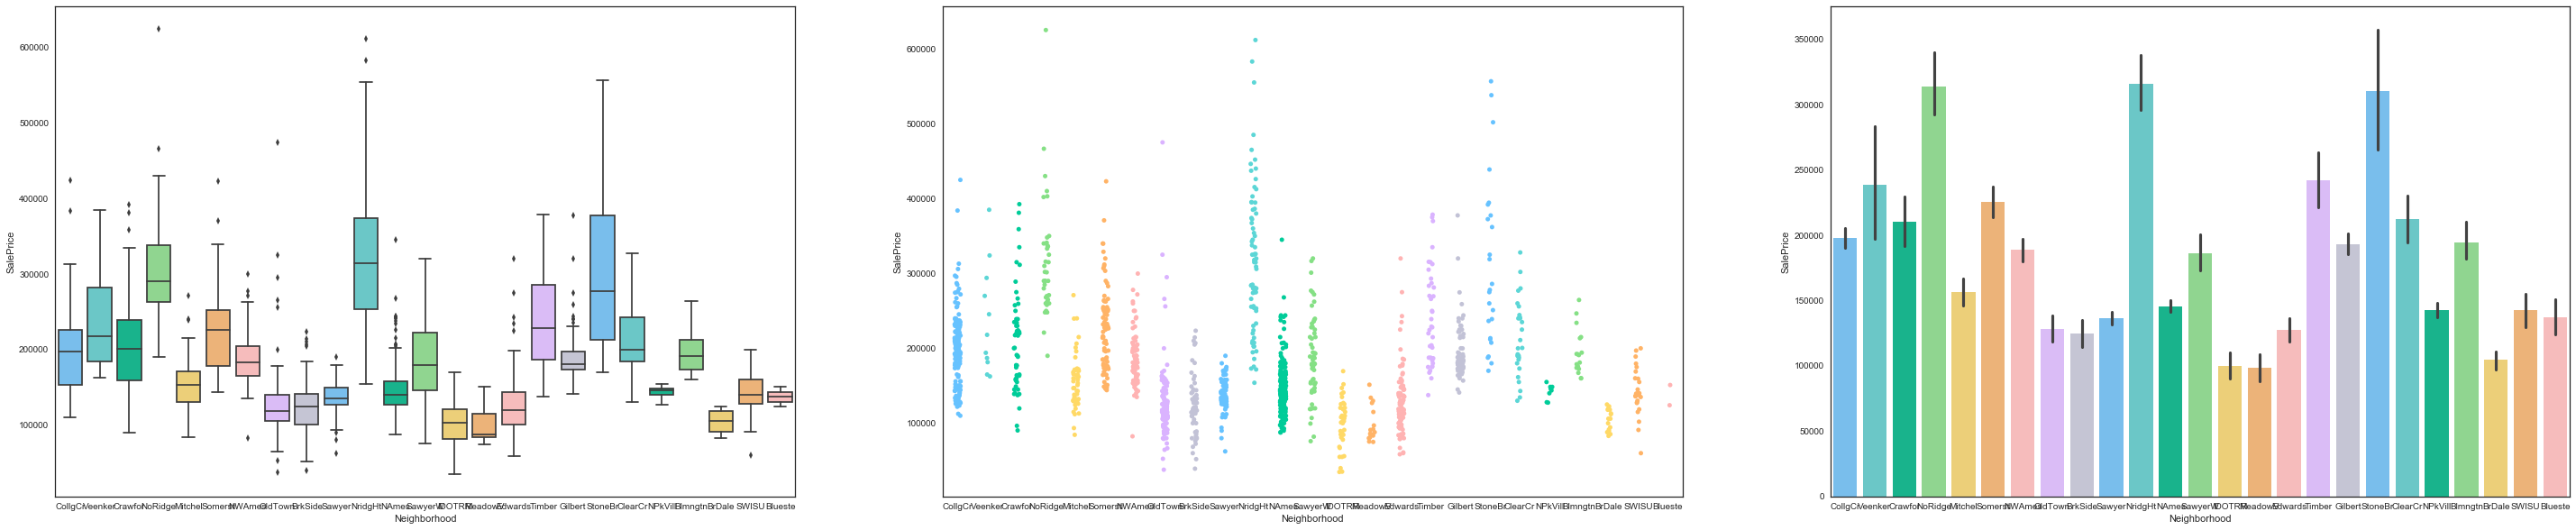

In [301]:
plt.subplots(figsize =(50, 10))

plt.subplot(1, 3, 1)
sns.boxplot(x="Neighborhood", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Neighborhood", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Neighborhood", y="SalePrice", data=train, palette = mycols);

- Neighborhood clearly has an important contribution towards SalePrice, since we see such high values for certain areas and low values for others.
- Since this is a categorical feature without order, I will create dummy features.

In [302]:
all_data = pd.get_dummies(all_data, columns = ["Neighborhood"], prefix="Neighborhood")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Condition1 Condition2 Electrical          ...           \
0       Norm       Norm      SBrkr          ...            
1      Feedr       Norm      SBrkr          ...            
2       Norm       Norm      SBrkr          ...            

   Neighborhood_NoRidge  Neighborhood_NridgHt  Neighborhood_OldTown  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     0                     0   

   Neighborhood_SWISU  Neighborhood_Sawyer  Neighborhood_SawyerW  \
0                   0                    0                     0   
1                   0                    0                     0   
2                   0                    0                     0   

  Neighborhood_Somerst Neighborhood_StoneBr  Neighborhood_Timber  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   

   Neighborhood_Veenker  
0                     0  
1                     1  
2                     0  

[3 rows x 284 columns]

***Condition1*** & ***Condition2***
- Proximity to various conditions.

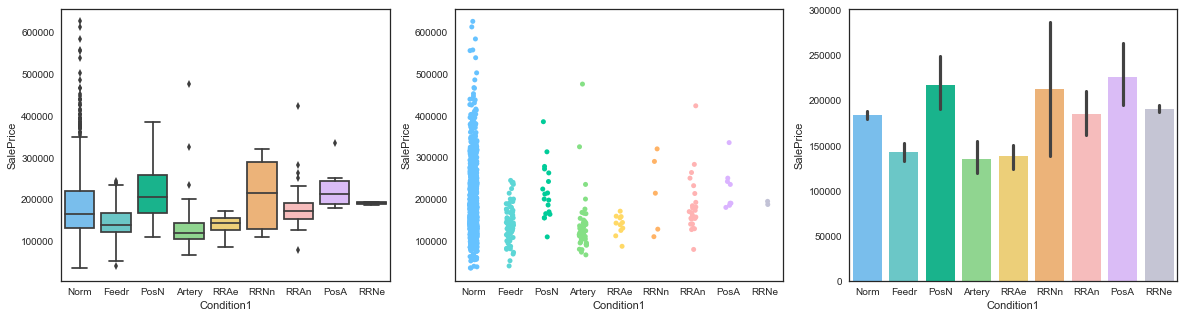

In [303]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Condition1", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Condition1", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Condition1", y="SalePrice", data=train, palette = mycols);

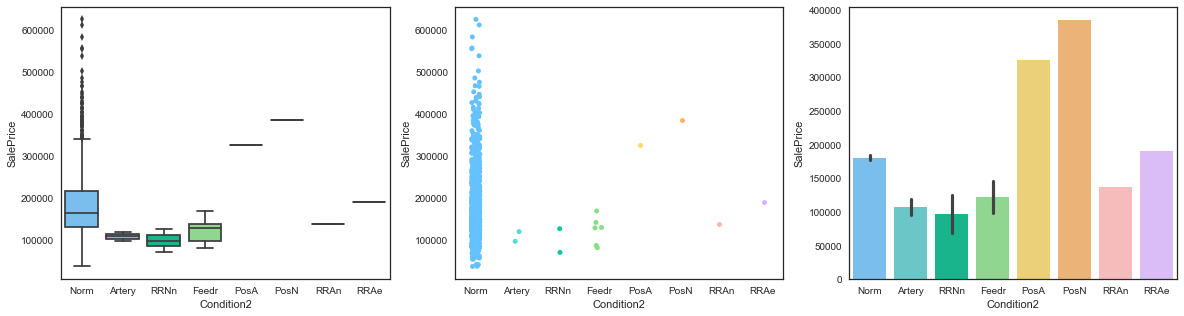

In [304]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Condition2", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Condition2", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Condition2", y="SalePrice", data=train, palette = mycols);

- Since this feature is based around local features, it is understandable that having more desirable things, like a parks... nearby are a factor that would contribute towards a higher SalePrice. 
- For this feature I am going to cluster the classes based on the class description. Then, I will create dummy features. 
- I will then drop "Condition2" after creating a flag to indicate whether a different condition from the first is nearby.

In [305]:
all_data['Condition1'] = all_data['Condition1'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})
all_data['Condition2'] = all_data['Condition2'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})

In [306]:
def ConditionMatch(col):
    if col['Condition1'] == col['Condition2']:
        return 0
    else:
        return 1
    
all_data['Diff2ndCondition_Flag'] = all_data.apply(ConditionMatch, axis=1)
all_data.drop('Condition2', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["Condition1"], prefix="Condition1")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual       ...         Neighborhood_SawyerW  \
0      SBrkr              0          3       ...                            0   
1      SBrkr              0          2       ...                            0   
2      SBrkr              0          3       ...                            0   

   Neighborhood_Somerst  Neighborhood_StoneBr  Neighborhood_Timber  \
0                     0                     0                    0   
1                     0                     0                    0   
2                     0                     0                    0   

  Neighborhood_Veenker Diff2ndCondition_Flag  Condition1_Norm  Condition1_Pos  \
0                    0                     0                1               0   
1                    1                     1                0               0   
2                    0                     0                1               0   

  Condition1_Street Condition1_Train  
0                 0                0  
1                 1                0  
2                 0                0  

[3 rows x 287 columns]

#### 4.2.6 - Land

***LotFrontage***
- Linear feet of street connected to property.

D:\Anaconda2\envs\py3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


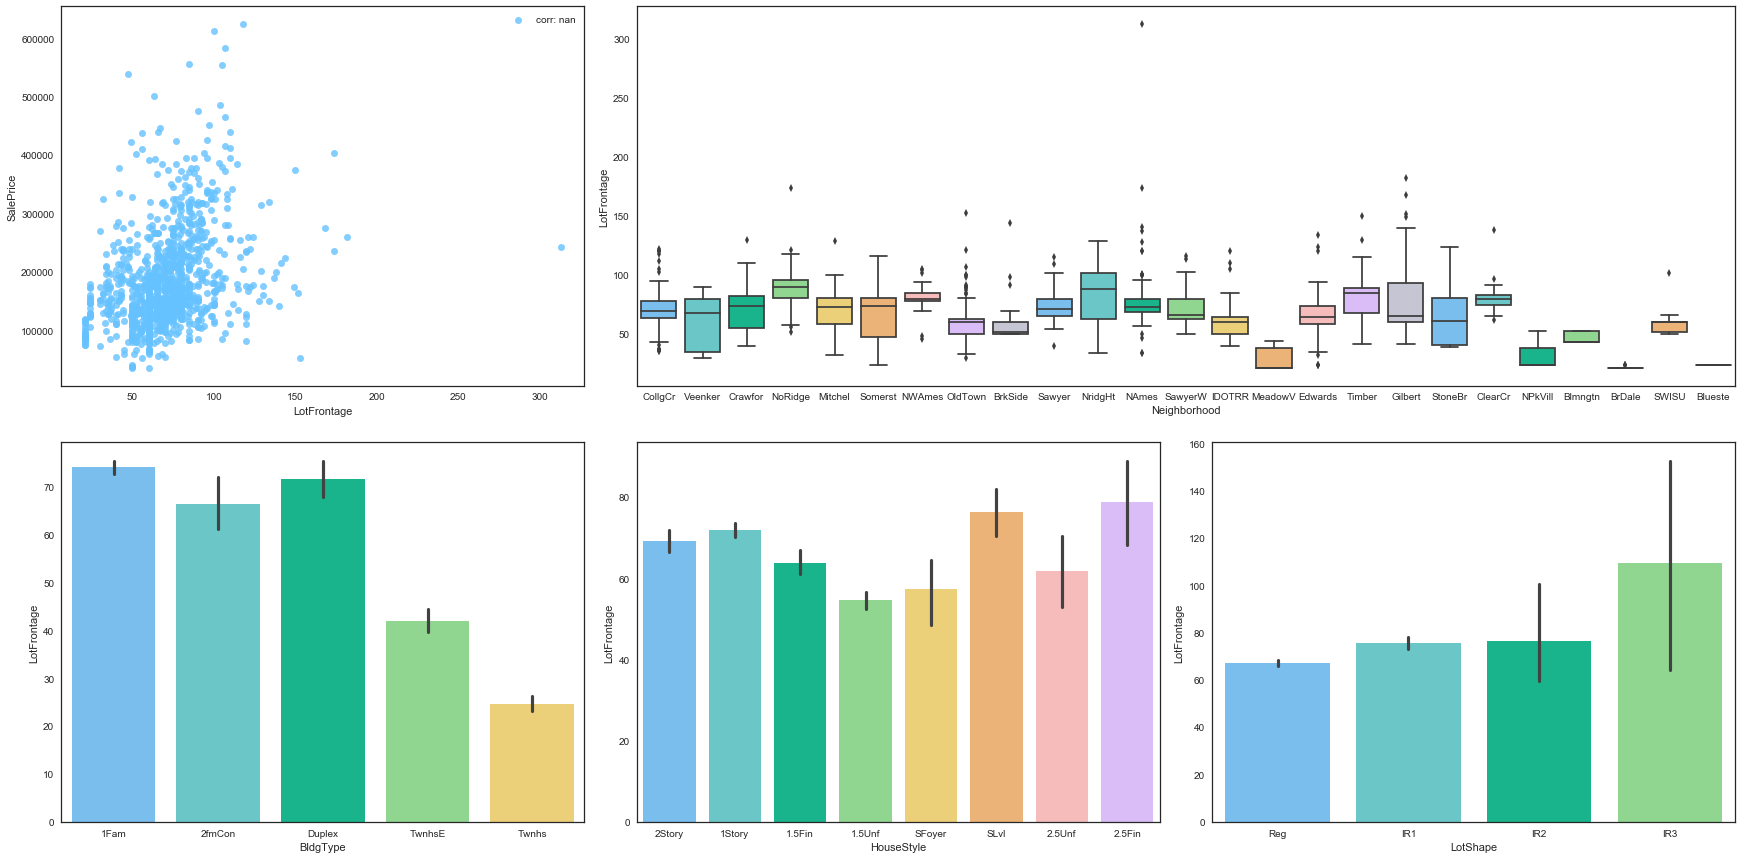

In [307]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['LotFrontage'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['LotFrontage'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="LotFrontage", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="LotFrontage", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="LotFrontage", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="LotFrontage", data=train, palette = mycols);

- This feature seems to be fairly randomly distributed against SalePrice without any significant correlation.
- LotFrontage doesn't seem to vary too much based on "Neighborhood", but the "BldgType" does seem to have a affect on the average LotFrontage.
- Since this feature doesn't seem to show any significance to bin into groupings, I will leave this feature as it is until I scale the features.

***LotArea***
- Lot size in square feet.

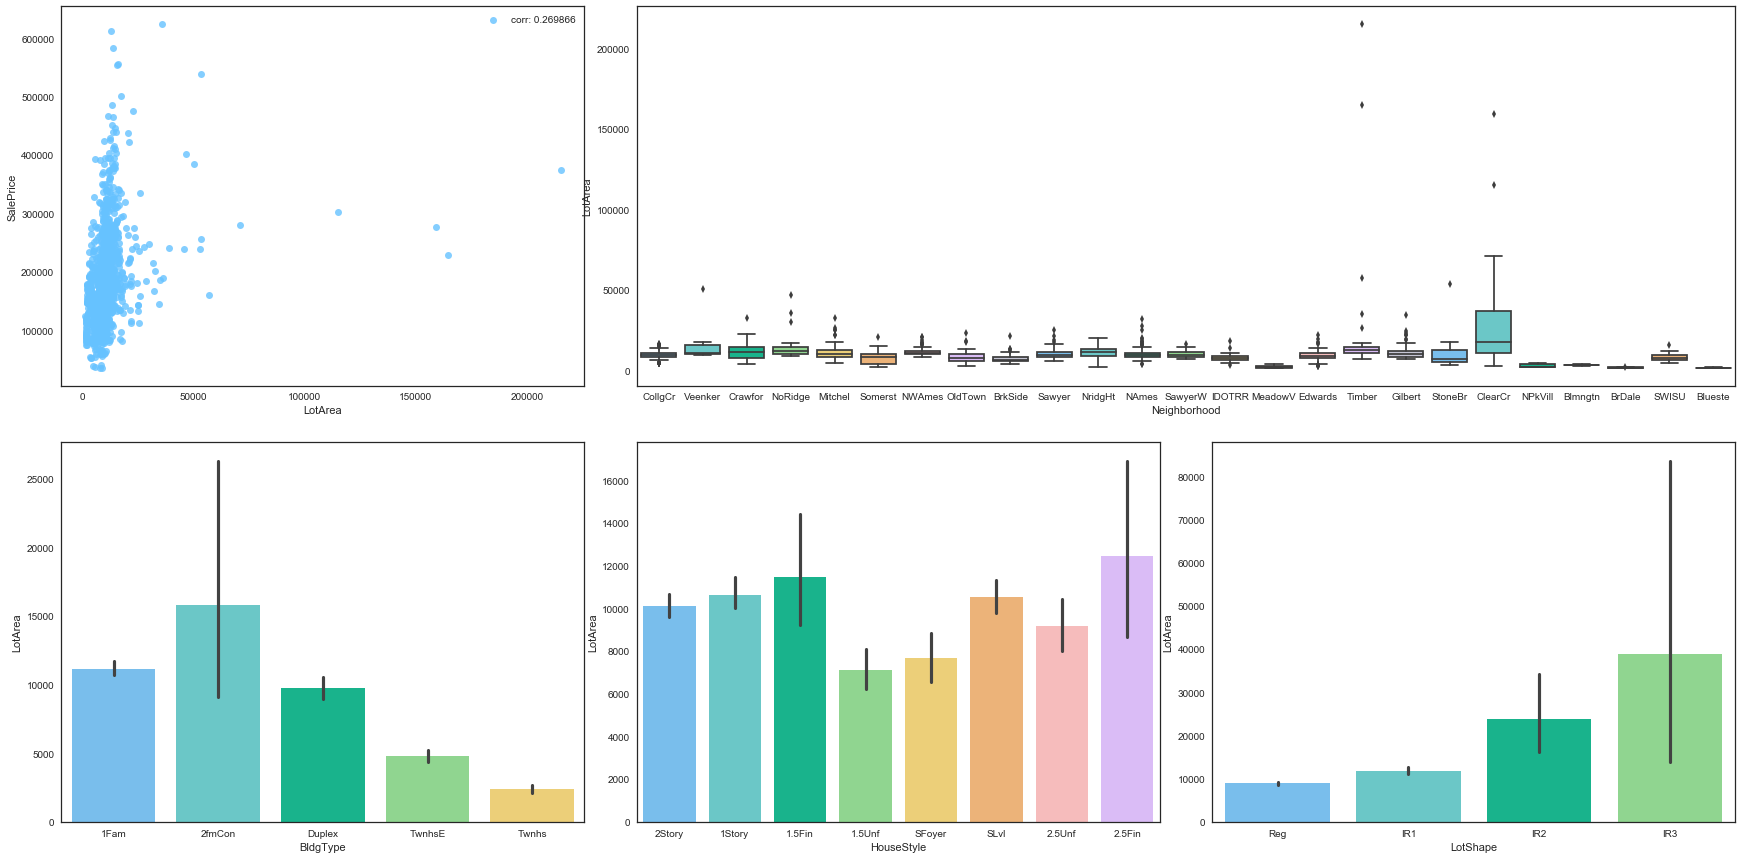

In [308]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['LotArea'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['LotArea'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="LotArea", data=train, palette = mycols)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="LotArea", data=train, palette = mycols)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="LotArea", data=train, palette = mycols)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="LotArea", data=train, palette = mycols);

- This feature shows a high correlation but it is very positively skewed. 
- Hence, I will create quantile bins and dummy features. Quantile bins are not based on approximately equal sized bins, instead creating bins with a similar frequency of data points within each bin.

In [309]:
all_data['LotArea_Band'] = pd.qcut(all_data['LotArea'], 8)
all_data['LotArea_Band'].unique()

[(7474.0, 8520.0], (9450.0, 10355.25], (10355.25, 11554.5], (13613.0, 215245.0], (5684.75, 7474.0], (11554.5, 13613.0], (1299.999, 5684.75], (8520.0, 9450.0]]
Categories (8, interval[float64]): [(1299.999, 5684.75] < (5684.75, 7474.0] < (7474.0, 8520.0] < (8520.0, 9450.0] < (9450.0, 10355.25] < (10355.25, 11554.5] < (11554.5, 13613.0] < (13613.0, 215245.0]]

In [310]:
all_data.loc[all_data['LotArea']<=5684.75, 'LotArea'] = 1
all_data.loc[(all_data['LotArea']>5684.75) & (all_data['LotArea']<=7474), 'LotArea'] = 2
all_data.loc[(all_data['LotArea']>7474) & (all_data['LotArea']<=8520), 'LotArea'] = 3
all_data.loc[(all_data['LotArea']>8520) & (all_data['LotArea']<=9450), 'LotArea'] = 4
all_data.loc[(all_data['LotArea']>9450) & (all_data['LotArea']<=10355.25), 'LotArea'] = 5
all_data.loc[(all_data['LotArea']>10355.25) & (all_data['LotArea']<=11554.25), 'LotArea'] = 6
all_data.loc[(all_data['LotArea']>11554.25) & (all_data['LotArea']<=13613), 'LotArea'] = 7
all_data.loc[all_data['LotArea']>13613, 'LotArea'] = 8
all_data['LotArea'] = all_data['LotArea'].astype(int)

all_data.drop('LotArea_Band', axis=1, inplace=True)

all_data = pd.get_dummies(all_data, columns = ["LotArea"], prefix="LotArea")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual    ...     Condition1_Street  \
0      SBrkr              0          3    ...                     0   
1      SBrkr              0          2    ...                     1   
2      SBrkr              0          3    ...                     0   

   Condition1_Train  LotArea_1  LotArea_2 LotArea_3 LotArea_4  LotArea_5  \
0                 0          0          0         1         0          0   
1                 0          0          0         0         0          1   
2                 0          0          0         0         0          0   

   LotArea_6 LotArea_7 LotArea_8  
0          0         0         0  
1          0         0         0  
2          1         0         0  

[3 rows x 294 columns]

***LotShape***
- General shape of property.

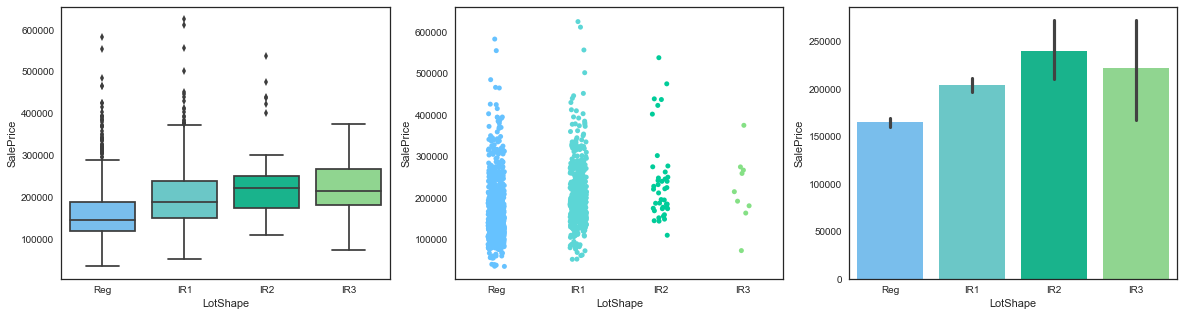

In [311]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LotShape", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="LotShape", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="LotShape", y="SalePrice", data=train, palette = mycols);

- Clearly we see some extreme values for some categories and a varying SalePrice across classes.
- "Reg" and "IR1" have the highest frequency of data points within them.
- Since this is a categorical feature without order, I will create dummy features.

In [312]:
all_data = pd.get_dummies(all_data, columns = ["LotShape"], prefix="LotShape")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual     ...       LotArea_3  LotArea_4  \
0      SBrkr              0          3     ...               1          0   
1      SBrkr              0          2     ...               0          0   
2      SBrkr              0          3     ...               0          0   

   LotArea_5  LotArea_6 LotArea_7 LotArea_8  LotShape_IR1  LotShape_IR2  \
0          0          0         0         0             0             0   
1          1          0         0         0             0             0   
2          0          1         0         0             1             0   

  LotShape_IR3 LotShape_Reg  
0            0            1  
1            0            1  
2            0            0  

[3 rows x 297 columns]

***LandContour***
- Flatness of the property

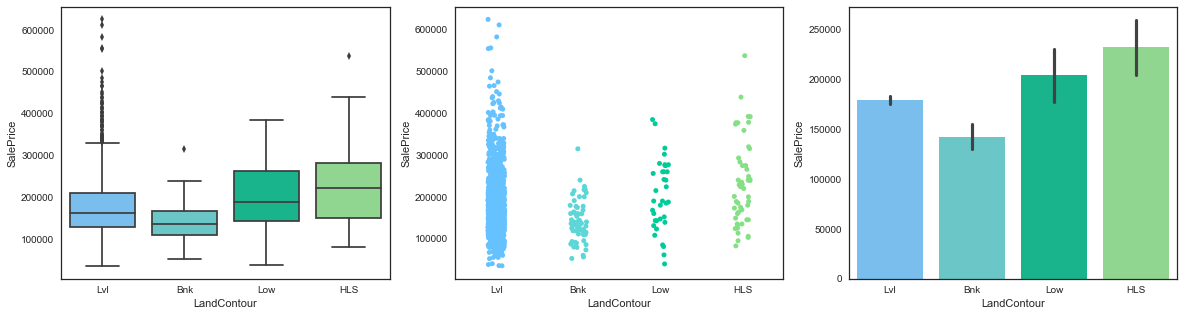

In [313]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LandContour", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="LandContour", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="LandContour", y="SalePrice", data=train, palette = mycols);

- Most houses are indeed on a flat contour, however the houses with the highest SalePrice seem to come from properties on a hill interestingly.
- Since this a categorical feature without order, I will create dummy features.

In [314]:
all_data = pd.get_dummies(all_data, columns = ["LandContour"], prefix="LandContour")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual       ...        LotArea_7  LotArea_8  \
0      SBrkr              0          3       ...                0          0   
1      SBrkr              0          2       ...                0          0   
2      SBrkr              0          3       ...                0          0   

   LotShape_IR1  LotShape_IR2 LotShape_IR3 LotShape_Reg  LandContour_Bnk  \
0             0             0            0            1                0   
1             0             0            0            1                0   
2             1             0            0            0                0   

   LandContour_HLS LandContour_Low LandContour_Lvl  
0                0               0               1  
1                0               0               1  
2                0               0               1  

[3 rows x 300 columns]

***LotConfig***
- Lot configuration.

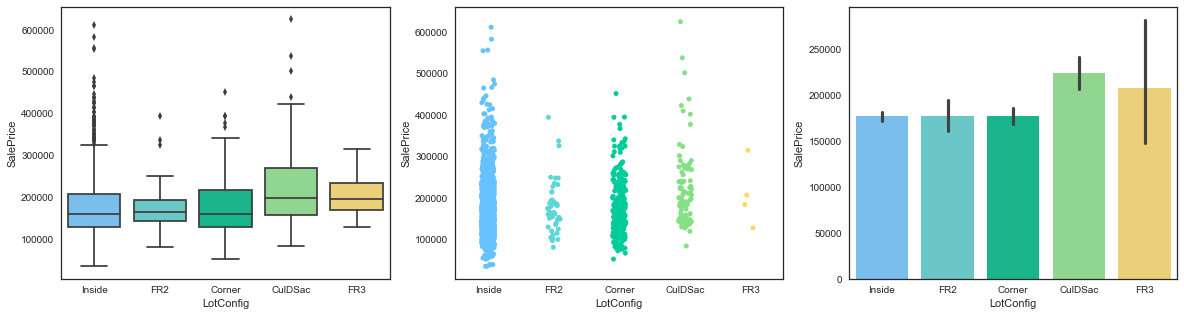

In [315]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LotConfig", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="LotConfig", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="LotConfig", y="SalePrice", data=train, palette = mycols);

- Cul de sac's seem to boast the highest average prices within Ames, however most houses are positioned inside or on the corner of the lot.
- To simplify this feature I wil cluster "FR2" and "FR3", then create dummy features.

In [316]:
all_data['LotConfig'] = all_data['LotConfig'].map({"Inside":"Inside", "FR2":"FR", "Corner":"Corner", "CulDSac":"CulDSac", "FR3":"FR"})

all_data = pd.get_dummies(all_data, columns = ["LotConfig"], prefix="LotConfig")
all_data.head(3)

3SsnPorch Alley  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0  None             3         3             1         3          Y   
1          0  None             3         3             4         3          Y   
2          0  None             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual        ...         LotShape_IR3  \
0      SBrkr              0          3        ...                    0   
1      SBrkr              0          2        ...                    0   
2      SBrkr              0          3        ...                    0   

   LotShape_Reg  LandContour_Bnk  LandContour_HLS LandContour_Low  \
0             1                0                0               0   
1             1                0                0               0   
2             0                0                0               0   

  LandContour_Lvl  LotConfig_Corner  LotConfig_CulDSac LotConfig_FR  \
0               1                 0                  0            0   
1               1                 0                  0            1   
2               1                 0                  0            0   

   LotConfig_Inside  
0                 1  
1                 0  
2                 1  

[3 rows x 303 columns]

***LandSlope***
- Slope of property.

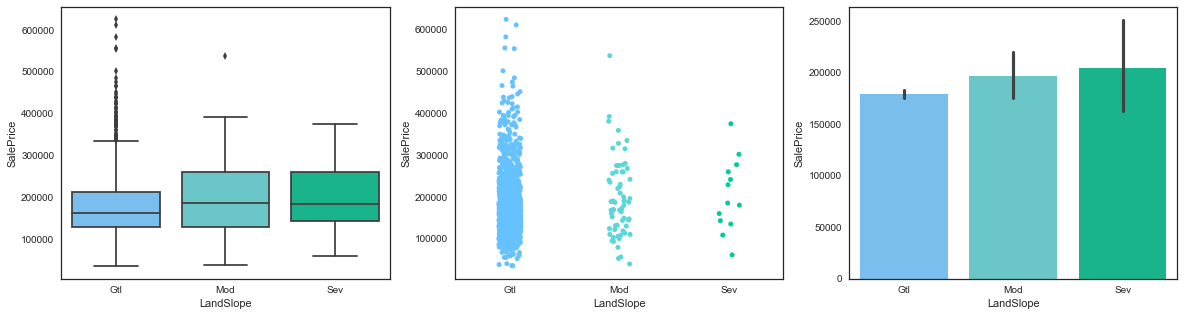

In [317]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="LandSlope", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="LandSlope", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="LandSlope", y="SalePrice", data=train, palette = mycols);

- We see that most houses have a gentle slope of land and overall, the severity of the slope doesn't appear to have much of an impact on SalePrice.
- Hence, I am going to cluster "Mod" and "Sev" to create one class, and create a new flag to indicate a gentle slope or not.

In [318]:
all_data['LandSlope'] = all_data['LandSlope'].map({"Gtl":1, "Mod":2, "Sev":2})

In [319]:
def Slope(col):
    if col['LandSlope'] == 1:
        return 1
    else:
        return 0
    
all_data['GentleSlope_Flag'] = all_data.apply(Slope, axis=1)
all_data.drop('LandSlope', axis=1, inplace=True)

<a id='access'></a>
#### 4.2.7 - Access

***Street***
- Type of road access to the property.

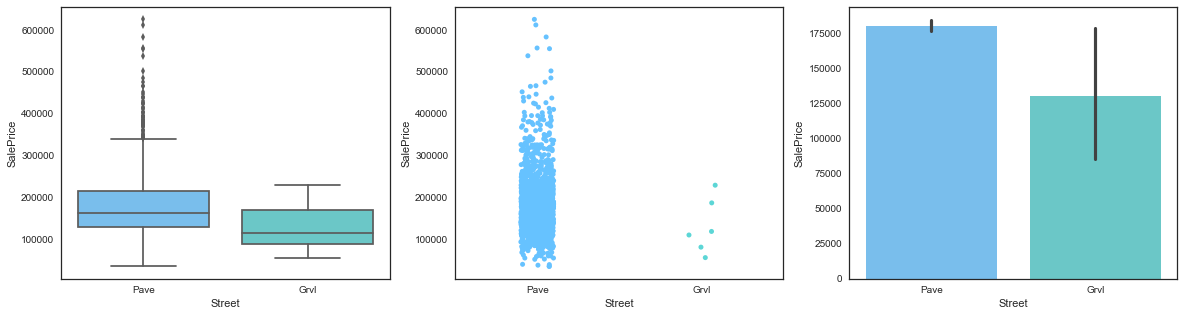

In [320]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Street", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Street", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Street", y="SalePrice", data=train, palette = mycols);

- With such a lower number of observations being assigned to the class "Grvl" it is redundant within the model.
- Hence, I will drop this feature.

In [321]:
all_data.drop('Street', axis=1, inplace=True)

***Alley***
- Type of alley access to the property.

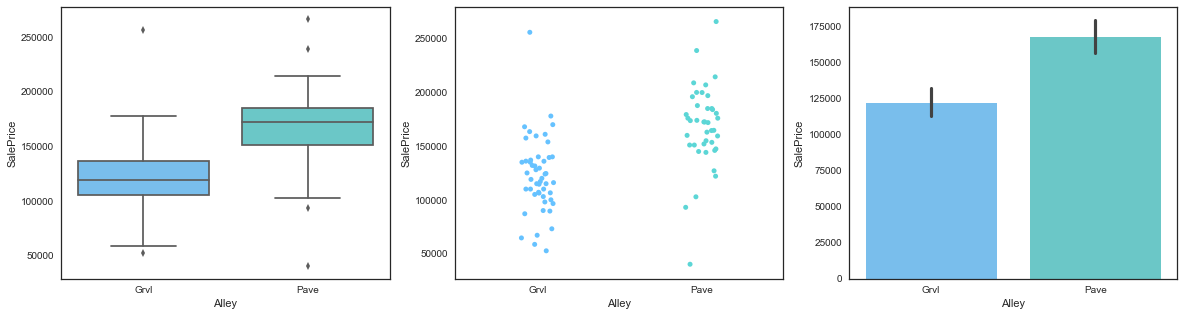

In [322]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Alley", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Alley", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Alley", y="SalePrice", data=train, palette = mycols);

- Here we see a fairly even split between to two classes in terms of frequency, but a much higher average SalePrice for Paved alleys as opposed to Gravel ones.
- Hence, this seems as though it could be a good predictor. I will create dummy features from this.

In [323]:
all_data = pd.get_dummies(all_data, columns = ["Alley"], prefix="Alley")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0             3         3             1         3          Y   
1          0             3         3             4         3          Y   
2          0             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  FireplaceQu     ...      \
0      SBrkr              0          3            0     ...       
1      SBrkr              0          2            3     ...       
2      SBrkr              0          3            3     ...       

   LandContour_Low  LandContour_Lvl  LotConfig_Corner LotConfig_CulDSac  \
0                0                1                 0                 0   
1                0                1                 0                 0   
2                0                1                 0                 0   

  LotConfig_FR  LotConfig_Inside  GentleSlope_Flag  Alley_Grvl Alley_None  \
0            0                 1                 1           0          1   
1            1                 0                 1           0          1   
2            0                 1                 1           0          1   

   Alley_Pave  
0           0  
1           0  
2           0  

[3 rows x 304 columns]

***PavedDrive***
- Paved driveway.

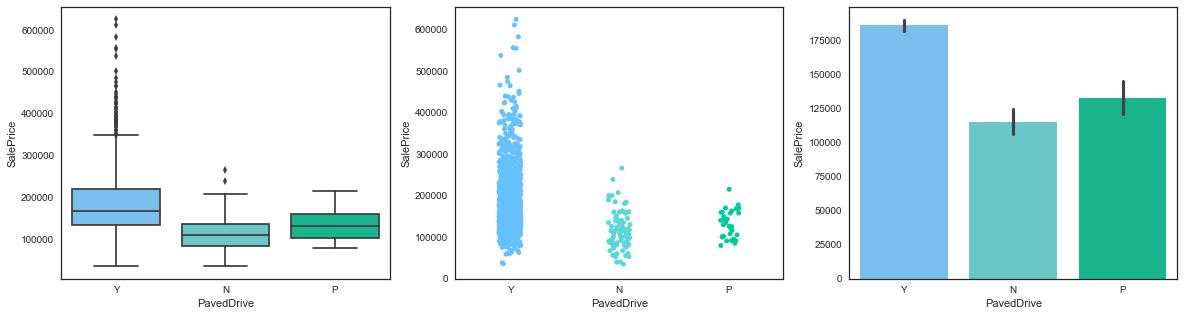

In [324]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="PavedDrive", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="PavedDrive", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="PavedDrive", y="SalePrice", data=train, palette = mycols);

- Here we see the highest average price being demanded from houses with a paved driveway, and most houses in this srea seem to have one.
- Since this is a categorical feature without order, I will create dummy variables.

In [325]:
all_data = pd.get_dummies(all_data, columns = ["PavedDrive"], prefix="PavedDrive")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0             3         3             1         3          Y   
1          0             3         3             4         3          Y   
2          0             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  FireplaceQu      ...       \
0      SBrkr              0          3            0      ...        
1      SBrkr              0          2            3      ...        
2      SBrkr              0          3            3      ...        

   LotConfig_CulDSac  LotConfig_FR  LotConfig_Inside GentleSlope_Flag  \
0                  0             0                 1                1   
1                  0             1                 0                1   
2                  0             0                 1                1   

  Alley_Grvl  Alley_None  Alley_Pave  PavedDrive_N PavedDrive_P  PavedDrive_Y  
0          0           1           0             0            0             1  
1          0           1           0             0            0             1  
2          0           1           0             0            0             1  

[3 rows x 306 columns]

<a id='utilities'></a>
#### 4.2.8 - Utilities

***Heating***
- Type of heating.

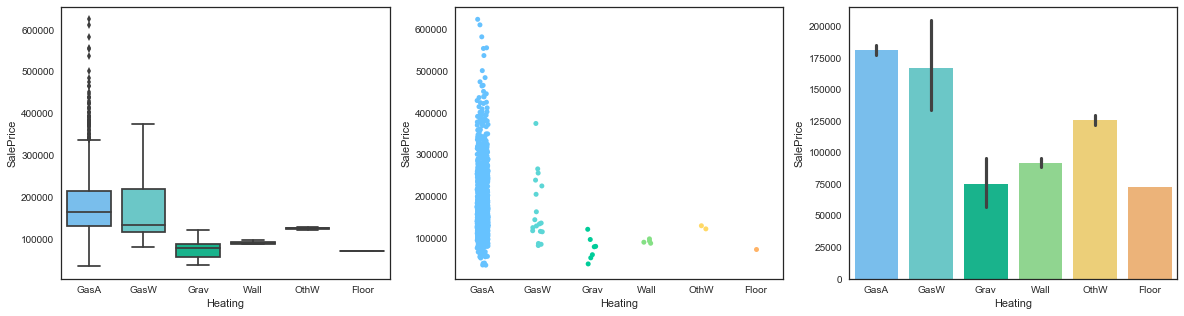

In [326]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Heating", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Heating", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Heating", y="SalePrice", data=train, palette = mycols);

- We see the highest frequency and highest average SalePrice coming from "GasA" and a very low frequency from all other classes.
- Hence, I will create a flag to indicate whether "GasA" is present or not.

In [327]:
all_data['GasA_Flag'] = all_data['Heating'].map({"GasA":1, "GasW":0, "Grav":0, "Wall":0, "OthW":0, "Floor":0})
all_data.drop('Heating', axis=1, inplace=True)
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual CentralAir  \
0          0             3         3             1         3          Y   
1          0             3         3             4         3          Y   
2          0             3         3             2         3          Y   

  Electrical  EnclosedPorch  ExterQual  FireplaceQu    ...      LotConfig_FR  \
0      SBrkr              0          3            0    ...                 0   
1      SBrkr              0          2            3    ...                 1   
2      SBrkr              0          3            3    ...                 0   

   LotConfig_Inside  GentleSlope_Flag Alley_Grvl  Alley_None  Alley_Pave  \
0                 1                 1          0           1           0   
1                 0                 1          0           1           0   
2                 1                 1          0           1           0   

   PavedDrive_N PavedDrive_P  PavedDrive_Y  GasA_Flag  
0             0            0             1          1  
1             0            0             1          1  
2             0            0             1          1  

[3 rows x 306 columns]

***HeatingQC***
- Heating quality and condition.

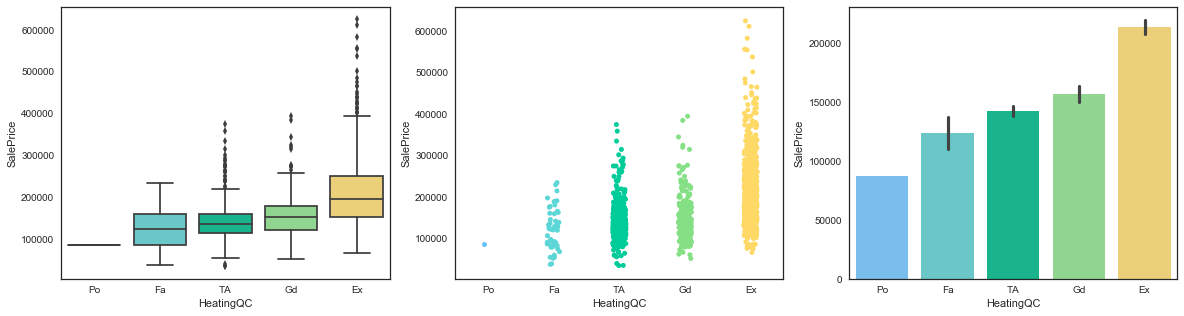

In [328]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="HeatingQC", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="HeatingQC", y="SalePrice", data=train, size = 5, jitter = True, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="HeatingQC", y="SalePrice", data=train, order=["Po", "Fa", "TA", "Gd", "Ex"], palette = mycols);

- Here we see a positive correlation with SalePrice as the heating quality increases. With "Ex" bringing the highest average SalePrice.
- We also see a high number of houses with this heating quality too, which means most houses had very good heating!
- This is a categorical feature, however because it exhibits an order, I will replace the values by hand with numbers.

In [329]:
all_data['HeatingQC'] = all_data['HeatingQC'].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
all_data['HeatingQC'].unique()

array([5, 4, 3, 2, 1], dtype=int64)

***CentralAir***
- Central air conditioning.

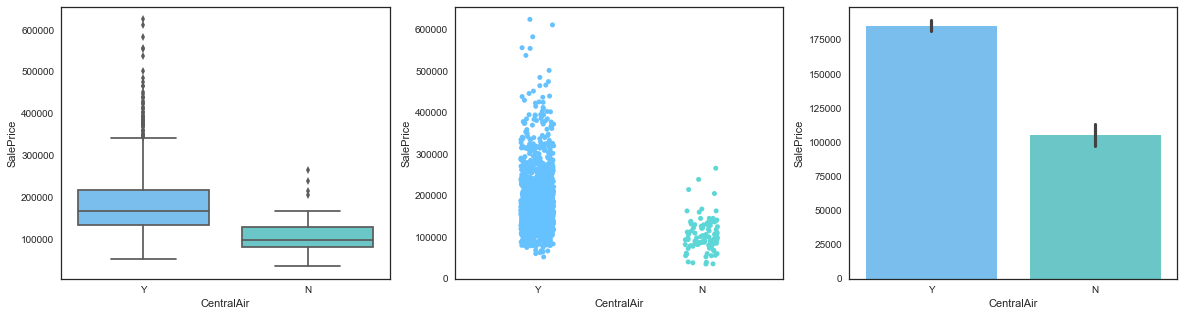

In [330]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="CentralAir", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="CentralAir", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="CentralAir", y="SalePrice", data=train, palette = mycols);

- We see that houses with central air conditioning are able to demand a higher average SalePrice than ones without.
- For this feature, I will simply replace the categories with numbers 0 and 1.

In [331]:
all_data['CentralAir'] = all_data['CentralAir'].map({"Y":1, "N":0})
all_data['CentralAir'].unique()

array([1, 0], dtype=int64)

***Electrical***
- Electrical system.

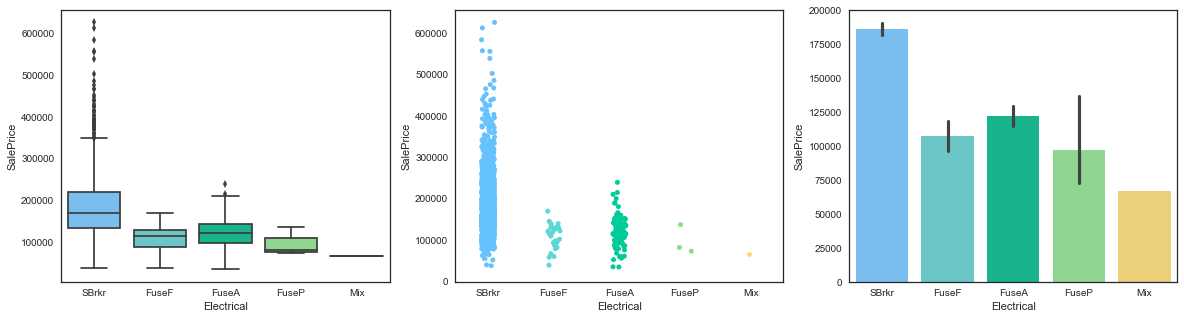

In [332]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="Electrical", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="Electrical", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="Electrical", y="SalePrice", data=train, palette = mycols);

- We see the highest average SalePrice coming from houses with "SBrkr" electrics, and these are also the most frequent electrical systems installed in the houses from this area. 
- We have 2 categories in particular that have very low frequencies, "FuseP" and "Mix".
- I am going to cluster all the classes related to fuses, and the "Mix" class will probably be removed during feature reduction.

In [333]:
all_data['Electrical'] = all_data['Electrical'].map({"SBrkr":"SBrkr", "FuseF":"Fuse", "FuseA":"Fuse", "FuseP":"Fuse", "Mix":"Mix"})

all_data = pd.get_dummies(all_data, columns = ["Electrical"], prefix="Electrical")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces        ...         \
0              0          3            0           0        ...          
1              0          2            3           1        ...          
2              0          3            3           1        ...          

   Alley_Grvl  Alley_None  Alley_Pave  PavedDrive_N  PavedDrive_P  \
0           0           1           0             0             0   
1           0           1           0             0             0   
2           0           1           0             0             0   

   PavedDrive_Y GasA_Flag  Electrical_Fuse  Electrical_Mix  Electrical_SBrkr  
0             1         1                0               0                 1  
1             1         1                0               0                 1  
2             1         1                0               0                 1  

[3 rows x 308 columns]

<a id='miscellaneous'></a>
#### 4.2.9 - Miscellaneous

***MiscFeature***
- Miscellaneous feature not covered in other categories.

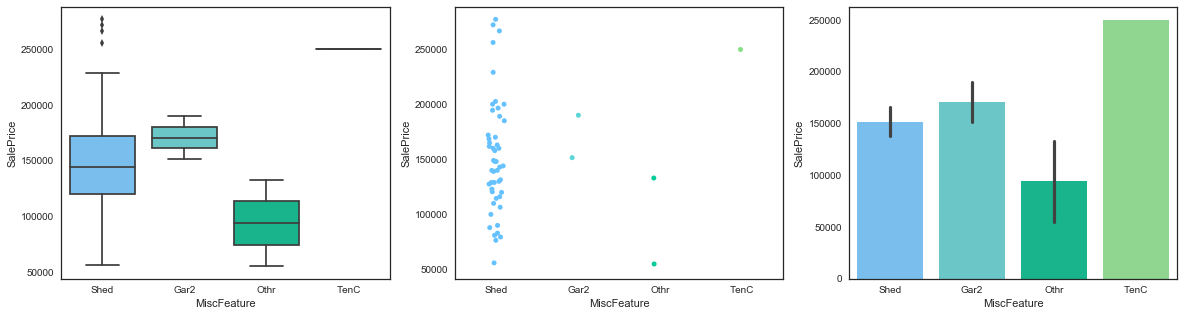

In [334]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MiscFeature", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="MiscFeature", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MiscFeature", y="SalePrice", data=train, palette = mycols);

- We can see here that only a low number of houses in this area with any miscalleanous features. Hence, I do not believe that this feature holds much.
- Therefore I will drop this feature along with MiscVal.

In [335]:
columns=['MiscFeature', 'MiscVal']
all_data.drop(columns, axis=1, inplace=True)

***MoSold***
- Month sold (MM).

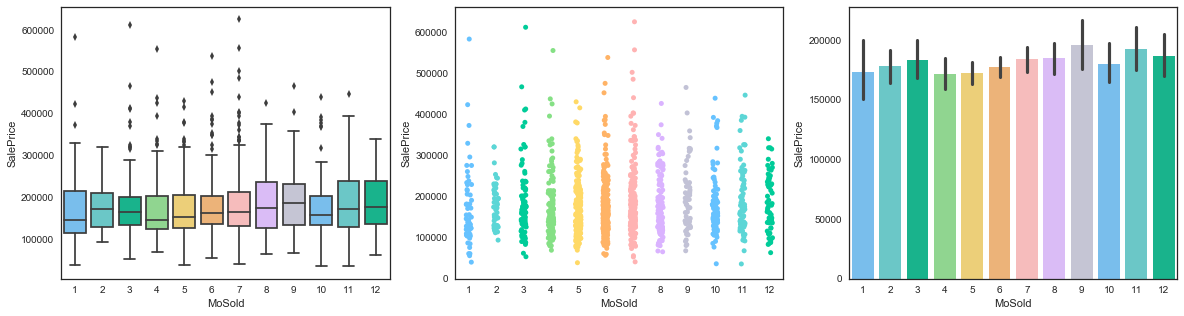

In [336]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="MoSold", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="MoSold", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="MoSold", y="SalePrice", data=train, palette = mycols);

- Although this feature is a numeric feature, it should really be a category. 
- We can see that there is no real indicator as to any months that consistetly sold houses of a higher price, however there does seem to be a fairly even distribution of values between classes.
- I will create dummy variables from each category.

In [337]:
all_data = pd.get_dummies(all_data, columns = ["MoSold"], prefix="MoSold")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces    ...     MoSold_3  \
0              0          3            0           0    ...            0   
1              0          2            3           1    ...            0   
2              0          3            3           1    ...            0   

   MoSold_4  MoSold_5  MoSold_6  MoSold_7  MoSold_8  MoSold_9  MoSold_10  \
0         0         0         0         0         0         0          0   
1         0         1         0         0         0         0          0   
2         0         0         0         0         0         1          0   

   MoSold_11 MoSold_12  
0          0         0  
1          0         0  
2          0         0  

[3 rows x 317 columns]

***YrSold***
- Year sold (YYYY).

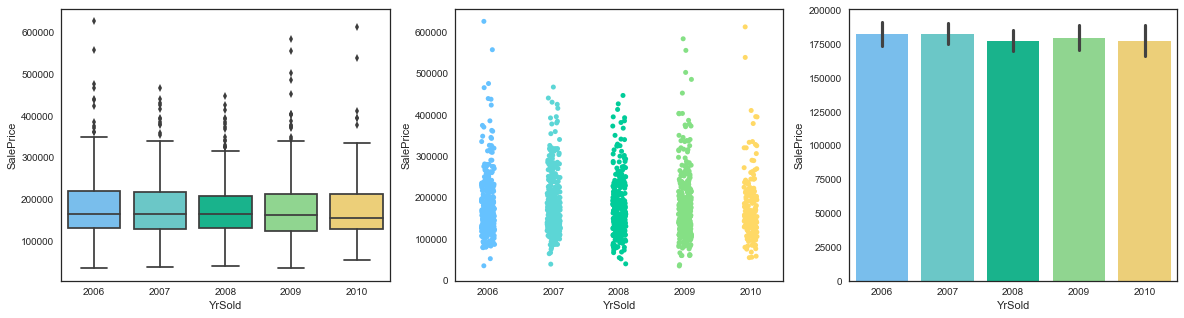

In [338]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="YrSold", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="YrSold", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="YrSold", y="SalePrice", data=train, palette = mycols);

- Here we see just a 5 year time period of which the houses in this dataset were sold.
- There is a n even distribution of values between each class, and each year has a very similar average SalePrice.
- Even though this is numeric, it should be categorical. Therefore I will create dummy variables.

In [339]:
all_data = pd.get_dummies(all_data, columns = ["YrSold"], prefix="YrSold")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces     ...      MoSold_8  \
0              0          3            0           0     ...             0   
1              0          2            3           1     ...             0   
2              0          3            3           1     ...             0   

   MoSold_9  MoSold_10  MoSold_11  MoSold_12  YrSold_2006  YrSold_2007  \
0         0          0          0          0            0            0   
1         0          0          0          0            0            1   
2         1          0          0          0            0            0   

   YrSold_2008  YrSold_2009 YrSold_2010  
0            1            0           0  
1            0            0           0  
2            1            0           0  

[3 rows x 321 columns]

***SaleType***
- Type of sale.

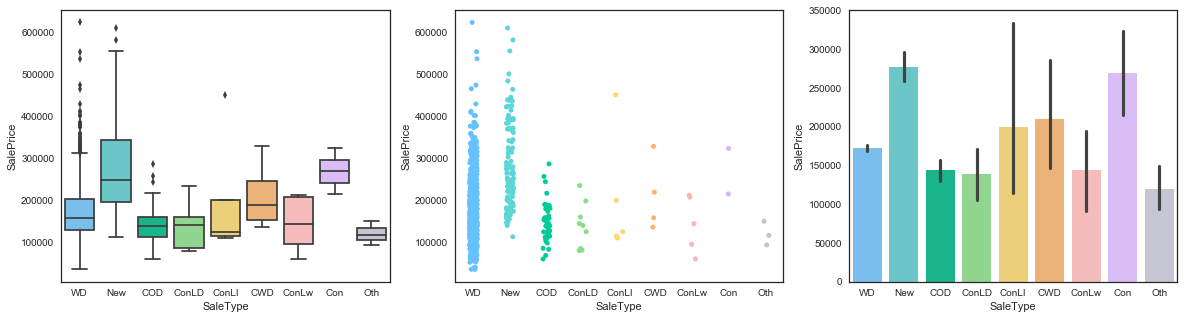

In [340]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="SaleType", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="SaleType", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="SaleType", y="SalePrice", data=train, palette = mycols);

- Most houses were sold under the "WD" category, being a conventional sale, however the highest SalePrice was seen from houses that were sold as houses that were brand new and just sold.
- For this feature, I will cluster some categories together and then create dummy features.

In [341]:
all_data['SaleType'] = all_data['SaleType'].map({"WD":"WD", "New":"New", "COD":"COD", "CWD":"CWD", "ConLD":"Oth", "ConLI":"Oth", 
                                                 "ConLw":"Oth", "Con":"Oth", "Oth":"Oth"})

all_data = pd.get_dummies(all_data, columns = ["SaleType"], prefix="SaleType")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces     ...      YrSold_2006  \
0              0          3            0           0     ...                0   
1              0          2            3           1     ...                0   
2              0          3            3           1     ...                0   

   YrSold_2007  YrSold_2008  YrSold_2009  YrSold_2010  SaleType_COD  \
0            0            1            0            0             0   
1            1            0            0            0             0   
2            0            1            0            0             0   

   SaleType_CWD  SaleType_New  SaleType_Oth SaleType_WD  
0             0             0             0           1  
1             0             0             0           1  
2             0             0             0           1  

[3 rows x 325 columns]

***SaleCondition***
- Condition of sale.

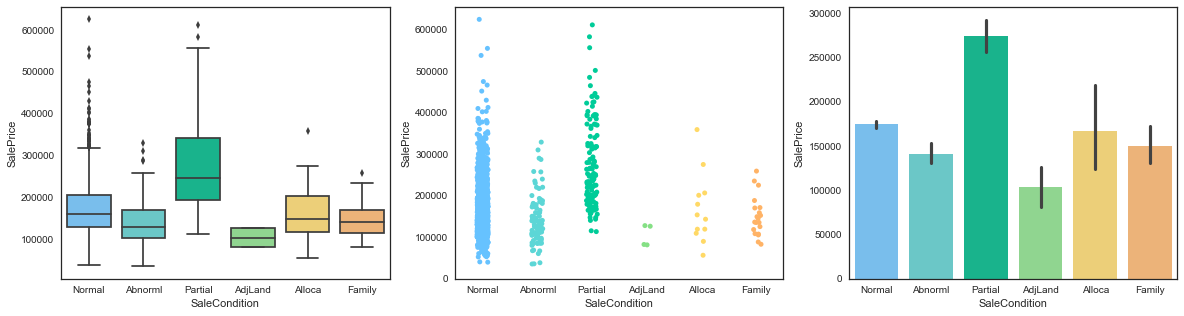

In [342]:
plt.subplots(figsize =(20, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x="SaleCondition", y="SalePrice", data=train, palette = mycols)

plt.subplot(1, 3, 2)
sns.stripplot(x="SaleCondition", y="SalePrice", data=train, size = 5, jitter = True, palette = mycols);

plt.subplot(1, 3, 3)
sns.barplot(x="SaleCondition", y="SalePrice", data=train, palette = mycols);

- Here we see the largest average SalePrice being associated with partial sales, and the most frequent sale seems to be the normal sales.
- Since this is a categorical feature without order, I will create dummy features.

In [343]:
all_data = pd.get_dummies(all_data, columns = ["SaleCondition"], prefix="SaleCondition")
all_data.head(3)

3SsnPorch  BedroomAbvGr  BsmtCond  BsmtExposure  BsmtQual  CentralAir  \
0          0             3         3             1         3           1   
1          0             3         3             4         3           1   
2          0             3         3             2         3           1   

   EnclosedPorch  ExterQual  FireplaceQu  Fireplaces          ...            \
0              0          3            0           0          ...             
1              0          2            3           1          ...             
2              0          3            3           1          ...             

   SaleType_CWD  SaleType_New  SaleType_Oth  SaleType_WD  \
0             0             0             0            1   
1             0             0             0            1   
2             0             0             0            1   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      0                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  

[3 rows x 330 columns]

***

<a id='target_variable'></a>
### 4.3 - Target Variable

- Unlike classification, **in regression we are predicting a continuous number**. Hence, the prediction could be any number along the real number line.
- Therefore, it is always useful to check the distribution of the target variable, and indeed all numeric variables, when building a regression model. Machine Learning algorithms work well with features that are **normally distributed**, a distribution that is symmetric and has a characteristic bell shape. If features are not normally distributed, you can transform them using clever statistical methods.
- First, let's check the target variable.

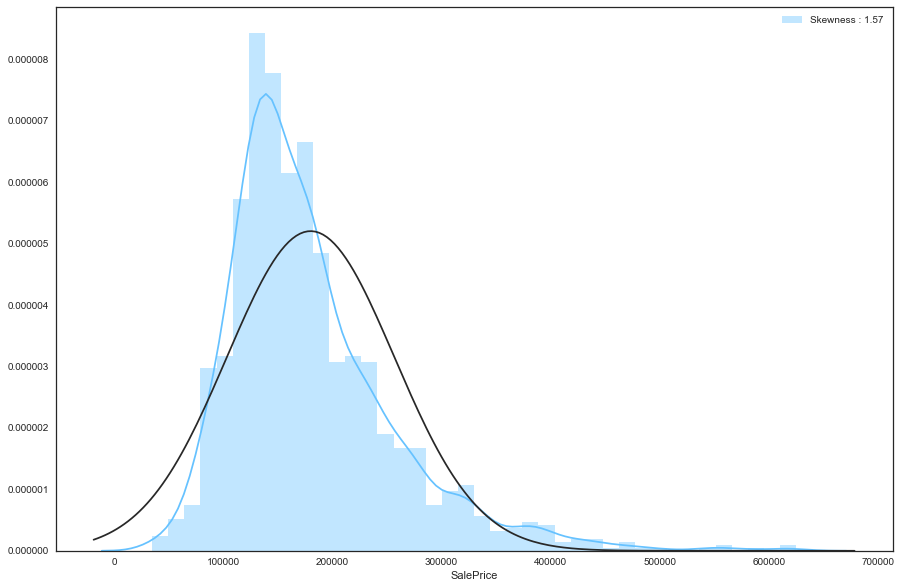

In [344]:
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

The distribution of the target variable is **positively skewed**, meaning that the mode is always less than the mean and median. 

- In order to transform this variable into a distribution that looks closer to the black line shown above, we can use the **numpy function log1p** which applies log(1+x) to all elements within the feature.

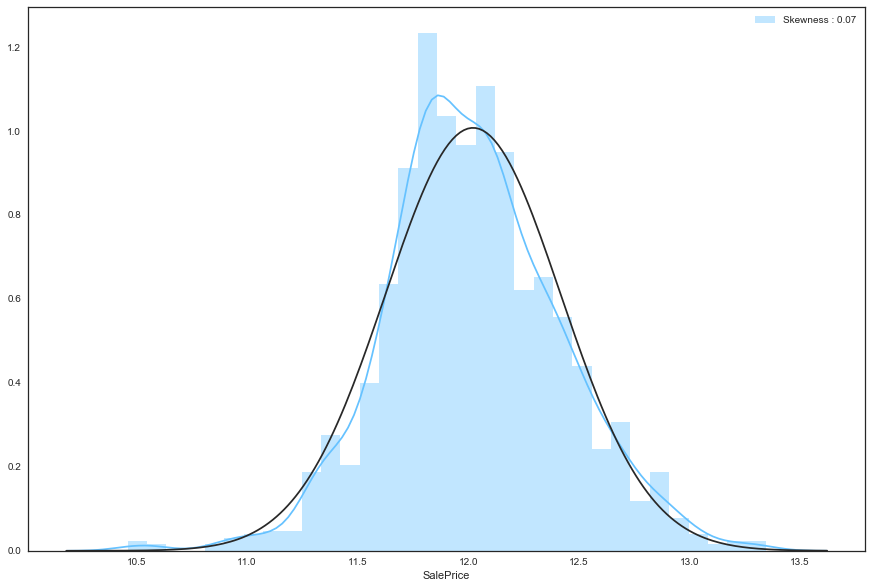

In [345]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train["SalePrice"]

#Check the new distribution 
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

We can see from the skewness and the plot that it follows much more closely to the normal distribution now. **This will help the algorithms work most reliably because we are now predicting a distribution that is well-known, i.e. the normal distribution**. If the distribution of your data approximates that of a theoretical distribution, we can perform calculations on the data that are based on assumptions of that well-known distribution. 

- ***Note:*** Now that we have transformed the target variable, this means that the prediction we produce will also be in the form of this transformation. Unless, we can revert this transformation...

***

<a id='treating_skewed_features'></a>
### 4.4 - Treating skewed features

As touched on earlier, skewed numeric variables are not desirable when using Machine Learning algorithms. The reason why we want to do this is move the models focus away from any extreme values, to create a generalised solution. We can tame these extreme values by transforming skewed features.

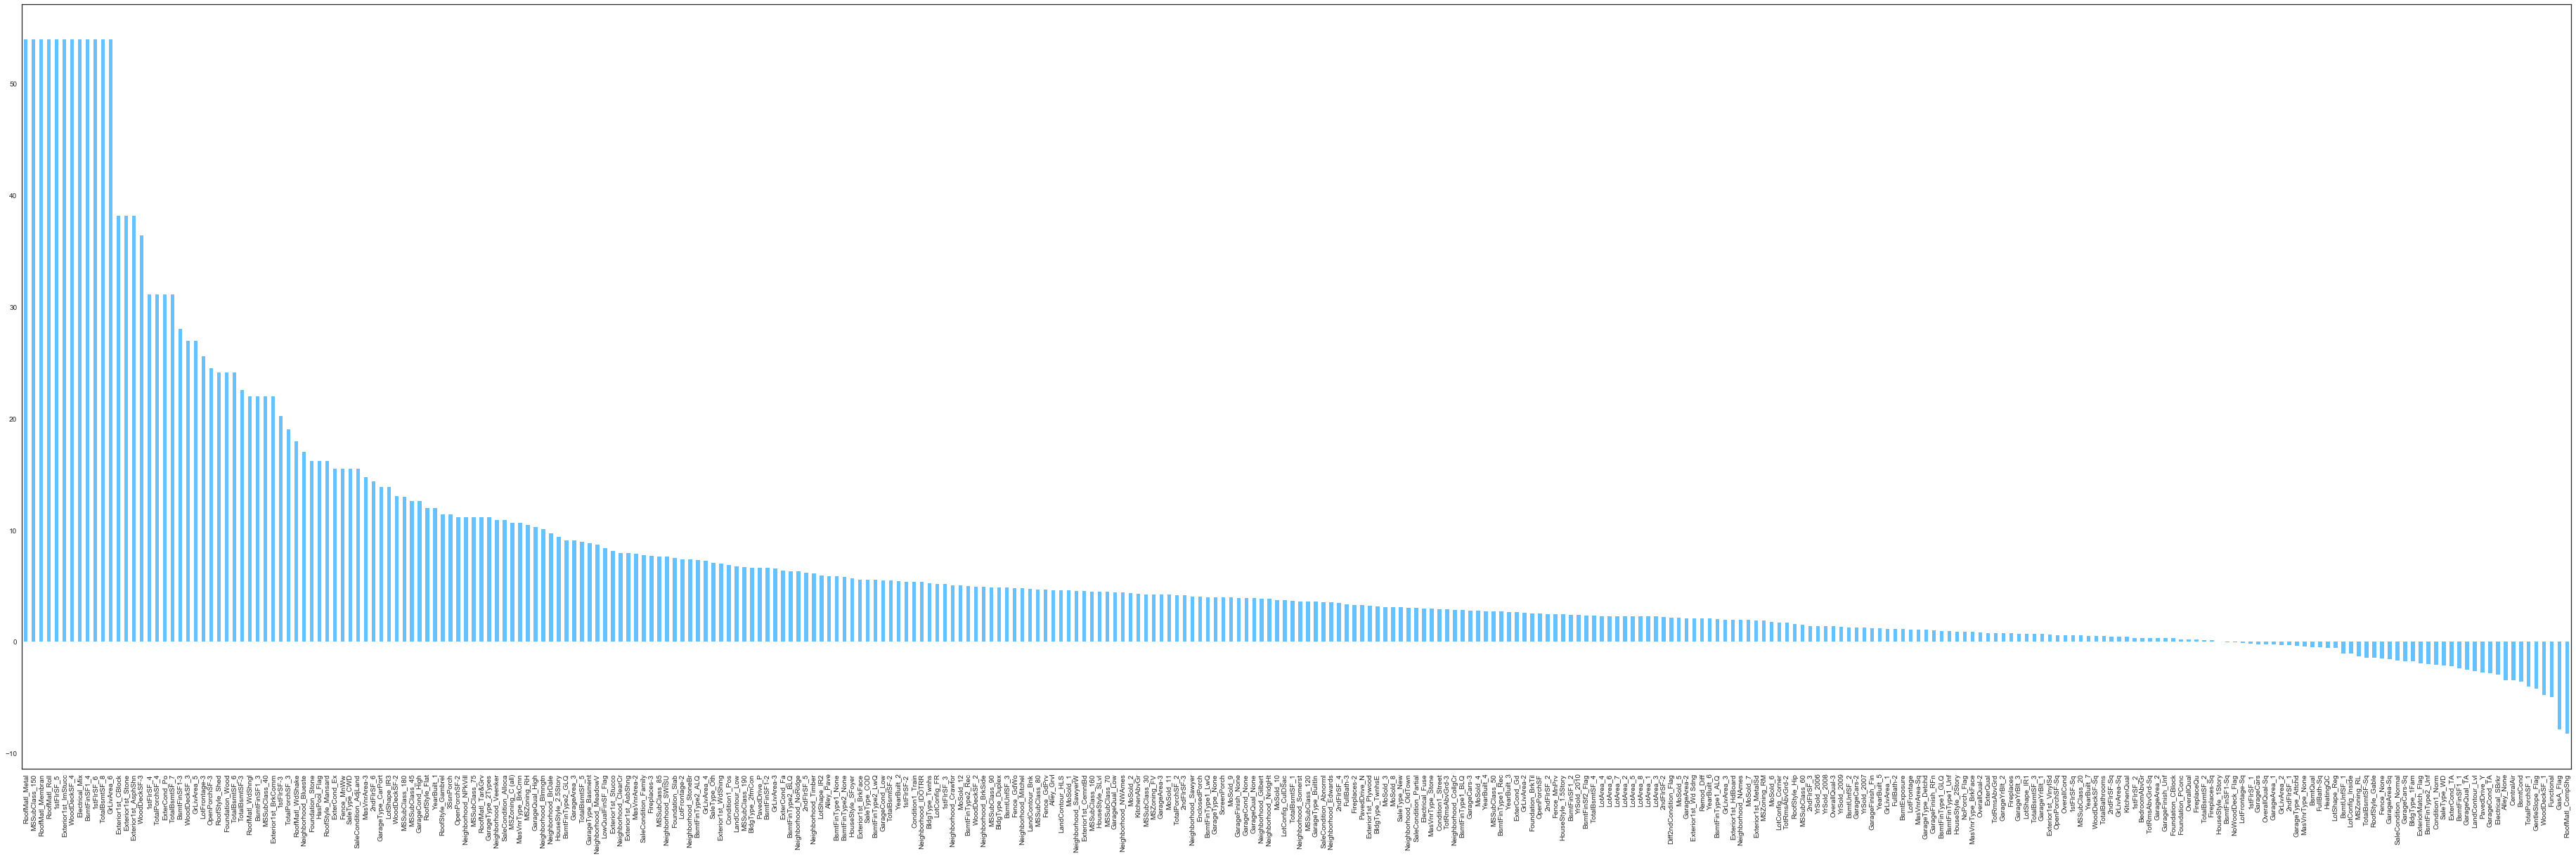

In [346]:
# First lets single out the numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check how skewed they are
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

plt.subplots(figsize =(65, 20))
skewed_feats.plot(kind='bar');

Clearly, we have a variety of positive and negative skewing features. Now I will transform the features with skew > 0.5 to follow more closely the normal distribution.

- **Note**: I am using the Box-Cox transformation to transform non-normal variables into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn't normal, applying a Box-Cox means that you are able to run a broader number of tests.

In [347]:
skewness = skewed_feats[abs(skewed_feats) > 0.5]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print(skewness.shape[0],  "skewed numerical features have been Box-Cox transformed")

302 skewed numerical features have been Box-Cox transformed


***

<a id='modeling'></a>
# 5. 
## Modeling

<a id='preparation_of_data'></a>
### 5.1 - Preparation of data

- Now that our dataset is ready for modeling, we must prepare it from training, testing and prediction. One of the vital steps here is to reduce the number of features. I will do this using XGBoost's inbuilt feature importance functionality.

In [348]:
# First, re-create the training and test datasets
train = all_data[:ntrain]
test = all_data[ntrain:]

print(train.shape)
print(test.shape)

(1456, 330)
(1459, 330)


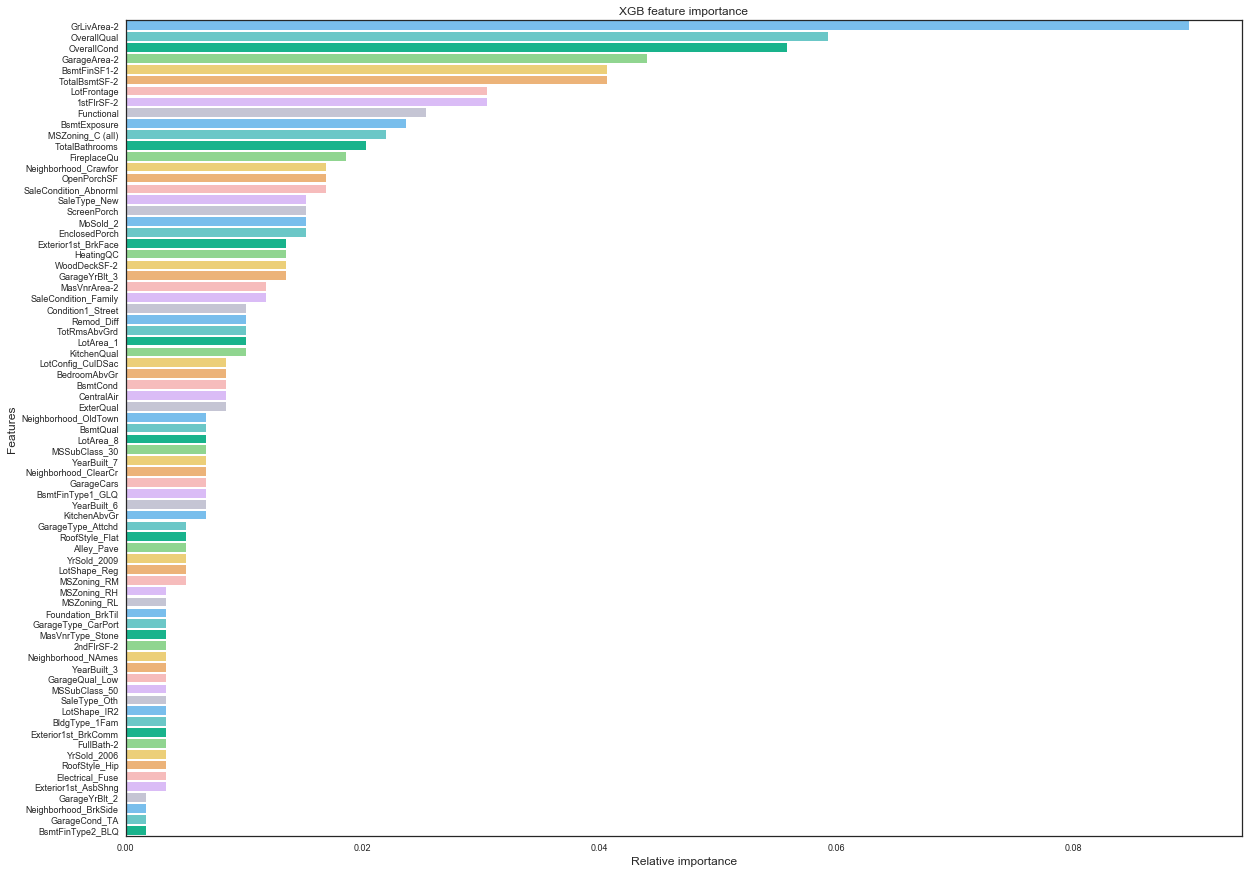

In [349]:
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(train, y_train)

# Sort feature importances from GBC model trained earlier
indices = np.argsort(model.feature_importances_)[::-1]
indices = indices[:75]

# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=train.columns[indices], x = model.feature_importances_[indices], orient='h', palette = mycols)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("XGB feature importance");

In [350]:
xgb_train = train.copy()
xgb_test = test.copy()

import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(xgb_train, y_train)

# Allow the feature importances attribute to select the most important features
xgb_feat_red = SelectFromModel(model, prefit = True)

# Reduce estimation, validation and test datasets
#筛选特征
xgb_train = xgb_feat_red.transform(xgb_train)
xgb_test = xgb_feat_red.transform(xgb_test)


print("Results of 'feature_importances_':")
print('X_train: ', xgb_train.shape, '\nX_test: ', xgb_test.shape)

Results of 'feature_importances_':
X_train:  (1456, 71) 
X_test:  (1459, 71)


In [351]:
# Next we want to sample our training data to test for performance of robustness ans accuracy, before applying to the test data
#划分训练集和验证集
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(xgb_train, y_train, test_size=0.3, random_state=42)

# X_train = predictor features for estimation dataset
# X_test = predictor variables for validation dataset
# Y_train = target variable for the estimation dataset
# Y_test = target variable for the estimation dataset

print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (1019, 71) 
X_test:  (437, 71) 
Y_train:  (1019,) 
Y_test:  (437,)


***

<a id='training'></a>
### 5.2 - Training

We are finally ready to train our models. For this analysis I am using 8 different algorithms:
- **Kernel Ridge Regression**
- **Elastic Net**
- **Lasso**
- **Gradient Boosting**
- **Bayesian Ridge**
- **Lasso Lars IC**
- **Random Forest Regressor**
- **XGBoost**

The method of measuring accuracy was chosen to be **Root Mean Squared Error**, as described within the competition.

In [352]:
import xgboost as xgb
#Machine Learning Algorithm (MLA) Selection and Initialization
#8种模型
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

# First I will use ShuffleSplit as a way of randomising the cross validation samples.
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#create table to compare MLA metrics
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
before_model_compare = pd.DataFrame(columns = columns)

#index through models and save performance to table
row_index = 0
for alg in models:

    #set name and parameters
    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index, 'Name'] = model_name
    before_model_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    alg.fit(X_train, Y_train)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    training_results = np.sqrt((-cross_val_score(alg, X_train, Y_train, cv = shuff, scoring= 'neg_mean_squared_error')).mean())
    test_results = np.sqrt(((Y_test-alg.predict(X_test))**2).mean())
    
    before_model_compare.loc[row_index, 'Train Accuracy Mean'] = (training_results)*100
    before_model_compare.loc[row_index, 'Test Accuracy'] = (test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
before_model_compare['Train Accuracy Mean'] = before_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare['Test Accuracy'] = before_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
before_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...
8 XGBRegressor trained...


Name  \
0                KernelRidge   
1                 ElasticNet   
2                      Lasso   
3  GradientBoostingRegressor   
4              BayesianRidge   
5                LassoLarsIC   
6      RandomForestRegressor   
7               XGBRegressor   

                                          Parameters  Train Accuracy Mean  \
0  {'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma':...               30.763   
1  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...               22.081   
2  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...               27.211   
3  {'alpha': 0.9, 'criterion': 'friedman_mse', 'i...               12.259   
4  {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...               11.229   
5  {'copy_X': True, 'criterion': 'aic', 'eps': 2....               12.552   
6  {'bootstrap': True, 'criterion': 'mse', 'max_d...               14.449   
7  {'base_score': 0.5, 'booster': 'gbtree', 'cols...               12.542   

   Test Accuracy  
0         32.917  
1         22.351  
2         27.333  
3         12.382  
4         11.759  
5         12.511  
6         14.172  
7         12.421

- We can see that each of the models performs with varying ability, with **Bayesian Ridge** having the best accuracy score on the training dataset and accuracy on the validation dataset.

***

<a id='optimisation'></a>
### 5.3 - Optimisation

- As you can see from the above table, the accuracy for these models is not quite as good as it could be.
- This is because we use the default configuration of parameters for each of the algorithms.

So now, we will use **GridSearchCV** to find the best combinations of parameters to produce the highest scoring models.

**Note**: GridSearchCV uses a grid of parameters to optimise the algorithms. This grid can get extremely large, and therefore requires a lot of computation power to complete. I have included a set of answers in the grids to cut down computation time, but these were not my final ones. I'll leave this up to you to find the best values. But in reality, you will have to fill these grids with appropriate values with the goal of trying to find the best combination.

In [353]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

KR_param_grid = {'alpha': [0.1], 'coef0': [100], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
LL_param_grid = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [100], 'copy_X': [True], 'precompute': ['auto'], 'eps': [0.000001]}
RFR_param_grid = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}
XGB_param_grid = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators': [300], 'booster': ['gbtree'], 'gamma': [0], 'reg_alpha': [0.1],
                  'reg_lambda': [0.7], 'max_delta_step': [0], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.2],
                  'scale_pos_weight': [1]}
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]

after_model_compare = pd.DataFrame(columns = columns)

row_index = 0
for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)

    #set name and parameters
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((Y_test-gs_alg.predict(X_test))**2).mean())
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = (after_training_results)*100
    after_model_compare.loc[row_index, 'Test Accuracy'] = (after_test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
after_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...
8 XGBRegressor trained...


Name  \
0                KernelRidge   
1                 ElasticNet   
2                      Lasso   
3  GradientBoostingRegressor   
4              BayesianRidge   
5                LassoLarsIC   
6      RandomForestRegressor   
7               XGBRegressor   

                                          Parameters  Train Accuracy Mean  \
0  {'alpha': 0.1, 'coef0': 100, 'degree': 1, 'gam...               11.212   
1  {'alpha': 0.001, 'copy_X': True, 'fit_intercep...               11.221   
2  {'alpha': 0.0005, 'copy_X': True, 'fit_interce...               11.209   
3  {'learning_rate': 0.1, 'loss': 'huber', 'max_d...               12.126   
4  {'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X':...               11.229   
5  {'copy_X': True, 'criterion': 'aic', 'eps': 1e...               12.552   
6  {'max_depth': None, 'max_features': 'auto', 'm...               13.552   
7  {'booster': 'gbtree', 'colsample_bylevel': 0.2...               12.073   

   Test Accuracy  
0         11.911  
1         11.924  
2         11.772  
3         12.153  
4         11.759  
5         12.511  
6         13.945  
7         11.789

Overall we can see that the training and test scores for each of the models have decreased, which is what we want.
- Now we have a set of highly tuned algorithms to use for **Stacking**.

***

<a id='stacking'></a>
### 5.4 - Stacking

Now that we have a set of highly tuned algorithms, a rather famous and successful technique to further improve the accuracy of these models, is to use **Stacking**. Let me explain what this means.

<img style="float: center;" src="1.png" width="100%">

If you hadn't figured it out already, our brick-laying friend enticed us in earlier on in order to explain **Stacking**.

Brick-laying is an art form. Where I live in London today, remain buildings that have stood for hundreds and even thousands of years. Without having a skilled brick-layer or to stack them properly, nobody would ever want to visit or live in this city. This animation shows the art of stacking bricks on top of one another to form something much greater, a wall, a house or even a building. **This is exactly what we are going to do by stacking several algorithms together, to form a much stronger one.**  

The steps for this technique are shown below:
1. **Create a set of algorithms ready for stacking** - We've done this...
2. **Split the original training data into a training and validation sample** - We've done this too...
3. **Train the algorithms on the training sample** - Also done this...
4. **For each algorithm, apply the trained models to the validation dataset and create a set of predictions**, 1 column for each model, as a new table. Call this the *new training dataset*.
5. **Also apply the trained algorithm to the test dataset and create a final set of predictions**, 1 column for each model, as a new table. Call this *new test dataset*.
6. **For the new training dataset, we have labeled outputs, in the form of Y_test**. Now we must train another model on these two feature sets: *new training dataset* and Y_test.
7. **Use this newly trained model to predict values** for *new test dataset*.

Now I understand that this sounds very confusing, and probably doesn't make much sense. Let me explain this further with some visualisations.

<img style="float: center;" src="2.png" width="100%">

# - Before I start with the stacking, I need to decide which algorithms to use as my base estimators, and which to use as the meta-model.

- Since **Lasso** performed the best after optimisation, I chose this to be the **meta-model**. All other models will be used as base estimators.

- So now, I will cycle through each optimised estimator, train them on the training dataset, apply to them the validation and test datasets, then finally outputting the predictions for validation and test into two new datasets: **stacked_validation_train** and **stacked_test_train**.

In [354]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
stacked_validation_train = pd.DataFrame()
stacked_test_train = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    stacked_validation_train.insert(loc = row_index, column = names[0], value = gs_best.predict(X_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking validation dataset...')
    
    stacked_test_train.insert(loc = row_index, column = names[0], value = gs_best.predict(xgb_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking test dataset...')
    print("-"*50)
    names.pop(0)
    
    row_index+=1
    
print('Done')

1 KernelRidge predictions added to stacking validation dataset...
1 KernelRidge predictions added to stacking test dataset...
--------------------------------------------------
2 ElasticNet predictions added to stacking validation dataset...
2 ElasticNet predictions added to stacking test dataset...
--------------------------------------------------
3 Lasso predictions added to stacking validation dataset...
3 Lasso predictions added to stacking test dataset...
--------------------------------------------------
4 GradientBoostingRegressor predictions added to stacking validation dataset...
4 GradientBoostingRegressor predictions added to stacking test dataset...
--------------------------------------------------
5 BayesianRidge predictions added to stacking validation dataset...
5 BayesianRidge predictions added to stacking test dataset...
--------------------------------------------------
6 LassoLarsIC predictions added to stacking validation dataset...
6 LassoLarsIC predictions added

- Let's take a quick look at what these new datasets look like:

In [355]:
stacked_validation_train.head()

KernelRidge  ElasticNet      Lasso  Gradient Boosting  Bayesian Ridge  \
0    12.095862   12.066708  12.076118          12.118402       12.107290   
1    11.934928   11.960117  11.957452          12.018334       11.924513   
2    11.785004   11.788987  11.792956          11.877250       11.786723   
3    11.786236   11.760447  11.764483          11.843397       11.787922   
4    11.294088   11.261771  11.268213          11.193234       11.293757   

   Lasso Lars IC  Random Forest    XGBoost  
0      12.104415      12.101039  12.052008  
1      12.006002      12.099819  12.089571  
2      11.781243      11.909035  11.829840  
3      11.839399      11.791935  11.734825  
4      11.302433      11.330688  11.294683

- The new training dataset is 438 rows of predictions from the 8 algorithms we decided to use.

In [356]:
stacked_test_train.head()

KernelRidge  ElasticNet      Lasso  Gradient Boosting  Bayesian Ridge  \
0    11.666129   11.688047  11.684277          11.737250       11.663755   
1    12.048428   12.057380  12.054638          11.955923       12.046563   
2    12.114796   12.112544  12.115646          12.137456       12.116697   
3    12.207342   12.210900  12.211829          12.134427       12.209729   
4    12.127530   12.141738  12.135086          12.129930       12.114497   

   Lasso Lars IC  Random Forest    XGBoost  
0      11.644445      11.716527  11.766223  
1      11.998478      11.977305  12.078956  
2      12.057223      12.086181  12.132909  
3      12.129703      12.119094  12.199221  
4      12.172302      12.171162  12.102457

- The new test dataset is 1459 rows of predictions from the 8 algorithms we decided to use.
- I will use these two datasets to train and produce predictions for the meta-model, Lasso.

In [357]:
# First drop the Lasso results from the table, as we will be using Lasso as the meta-model
drop = ['Lasso']
#将lasso作为基模型使用
stacked_validation_train.drop(drop, axis=1, inplace=True)
stacked_test_train.drop(drop, axis=1, inplace=True)

# Now fit the meta model and generate predictions
meta_model = make_pipeline(RobustScaler(), Lasso(alpha=0.00001, copy_X = True, fit_intercept = True,
                                              normalize = False, precompute = False, max_iter = 10000,
                                              tol = 0.0001, selection = 'random', random_state = None))
meta_model.fit(stacked_validation_train, Y_test)

#复原经过log1p变换的目标值
meta_model_pred = np.expm1(meta_model.predict(stacked_test_train))
print("Meta-model trained and applied!...")

Meta-model trained and applied!...


***

<a id='ensemble'></a>
### 5.5 - Ensemble

- However, another famous and successful technique for Machine Learning are **Ensemble methods**.
    - These are effective when using many different models of varying degrees of accuracy. 
    - They work on the idea that many weak learners, can produce a strong learner.
- Therefore, using the meta-model that I will create, I will also combine this with the results of the individual optimised models to create an ensemble.
- In order to create this ensemble, I must collect the final predictions of each of the optimised models. I will do this now.

In [358]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
final_predictions = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(stacked_validation_train, Y_test)
    gs_best = gs_alg.best_estimator_
    final_predictions.insert(loc = row_index, column = names[0], value = np.expm1(gs_best.predict(stacked_test_train)))
    print(row_index+1, alg.__class__.__name__, 'final results predicted added to table...')
    names.pop(0)
    
    row_index+=1

print("-"*50)
print("Done")
    
final_predictions.head()

1 KernelRidge final results predicted added to table...
2 ElasticNet final results predicted added to table...
3 Lasso final results predicted added to table...
4 GradientBoostingRegressor final results predicted added to table...
5 BayesianRidge final results predicted added to table...
6 LassoLarsIC final results predicted added to table...
7 RandomForestRegressor final results predicted added to table...
8 XGBRegressor final results predicted added to table...
--------------------------------------------------
Done


KernelRidge     ElasticNet          Lasso  Gradient Boosting  \
0  121682.762326  122551.983115  121098.704251      124057.724745   
1  168464.569412  169022.109124  168991.338755      164296.520460   
2  184448.370240  184589.192223  183954.032802      184349.999843   
3  196598.336783  196805.711699  196999.892725      182478.165106   
4  183779.110799  183980.649465  183844.836727      183586.896908   

   Bayesian Ridge  Lasso Lars IC  Random Forest        XGBoost  
0   122648.765725  121563.139869  116637.662846  118308.445312  
1   169192.449749  168518.607664  164508.753984  162478.671875  
2   185722.462270  184839.448141  182581.663126  186149.843750  
3   197814.867046  196830.423674  175585.326676  177067.250000  
4   182298.624197  182513.040837  181653.759111  187797.812500

- As you can see, each of the models produces results that vary quite widely. This is the beauty of using a combination of many different models.
- Some models will be much better at catching certain signals in the data, whereas others may perform better in other situations. 
- By creating an ensemble of all of these results, it helps to create a more generalised model that is resistant to noise.
- Now, I will finish by creating an ensemble of the meta-model and optimised models, for my final submission.

***

<a id='submission'></a>
### 5.6 - Submission

In [359]:
#ensemble的比例是怎么分配的呢？
ensemble = meta_model_pred*(1/10) + final_predictions['XGBoost']*(1.5/10) + final_predictions['Gradient Boosting']*(2/10) + final_predictions['Bayesian Ridge']*(1/10) + final_predictions['Lasso']*(1/10) + final_predictions['KernelRidge']*(1/10) + final_predictions['Lasso Lars IC']*(1/10) + final_predictions['Random Forest']*(1.5/10)

submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = ensemble
#submission.to_csv('final_submission.csv',index=False)
print("Submission file, created!")

Submission file, created!


***

<a id='conclusion'></a>
# 6. 
## Conclusion

- Throughout this notebook, I wanted to focus mainly on **feature engineering** and the **stacking** technique. I think stacking is a very useful tool to have within your Data Science toolkit, and I hope this has helped you to understand how it works.
- This is just my solution, but I'd be interested to hear your comments and thoughts on my work and also how you'd do it differently.

***

## Acknowledgements

- The Ames Housing dataset, by Dean De Cock: https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
- Curve fitting with linear and nonlinear regression: http://blog.minitab.com/blog/adventures-in-statistics-2/curve-fitting-with-linear-and-nonlinear-regression
- Stacking: https://www.coursera.org/learn/competitive-data-science/lecture/Qdtt6/stacking

**Useful Kernels**:
- Juliencs: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
- Serigne: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
- Alexandru Papiu: https://www.kaggle.com/apapiu/regularized-linear-models